- **one hot vetcor** # based on the dictionary to get.
- **word embedding model** # present more knowlege about words in order to do comparison. 1- cbow 2- N-gram model 3- skip-gram
- **t-SNE data visualization** algorithm to draw the word embedding vectors after projecting them onto a two-dimensional space.
- **cosine similarity**, [-1,1] # 1 means vectors are identical. o means perpendicular, -1 means opposite directions.
- ** language model**  build the joint probability function. 


1. N-gram model
2. CBOW- ignore the order of words in the sequence, using the average value of the word embeddings of the context to predict the current words.
3. Skip-gram model.- use one word to predict possible word embedding of context.

** N-gram** 
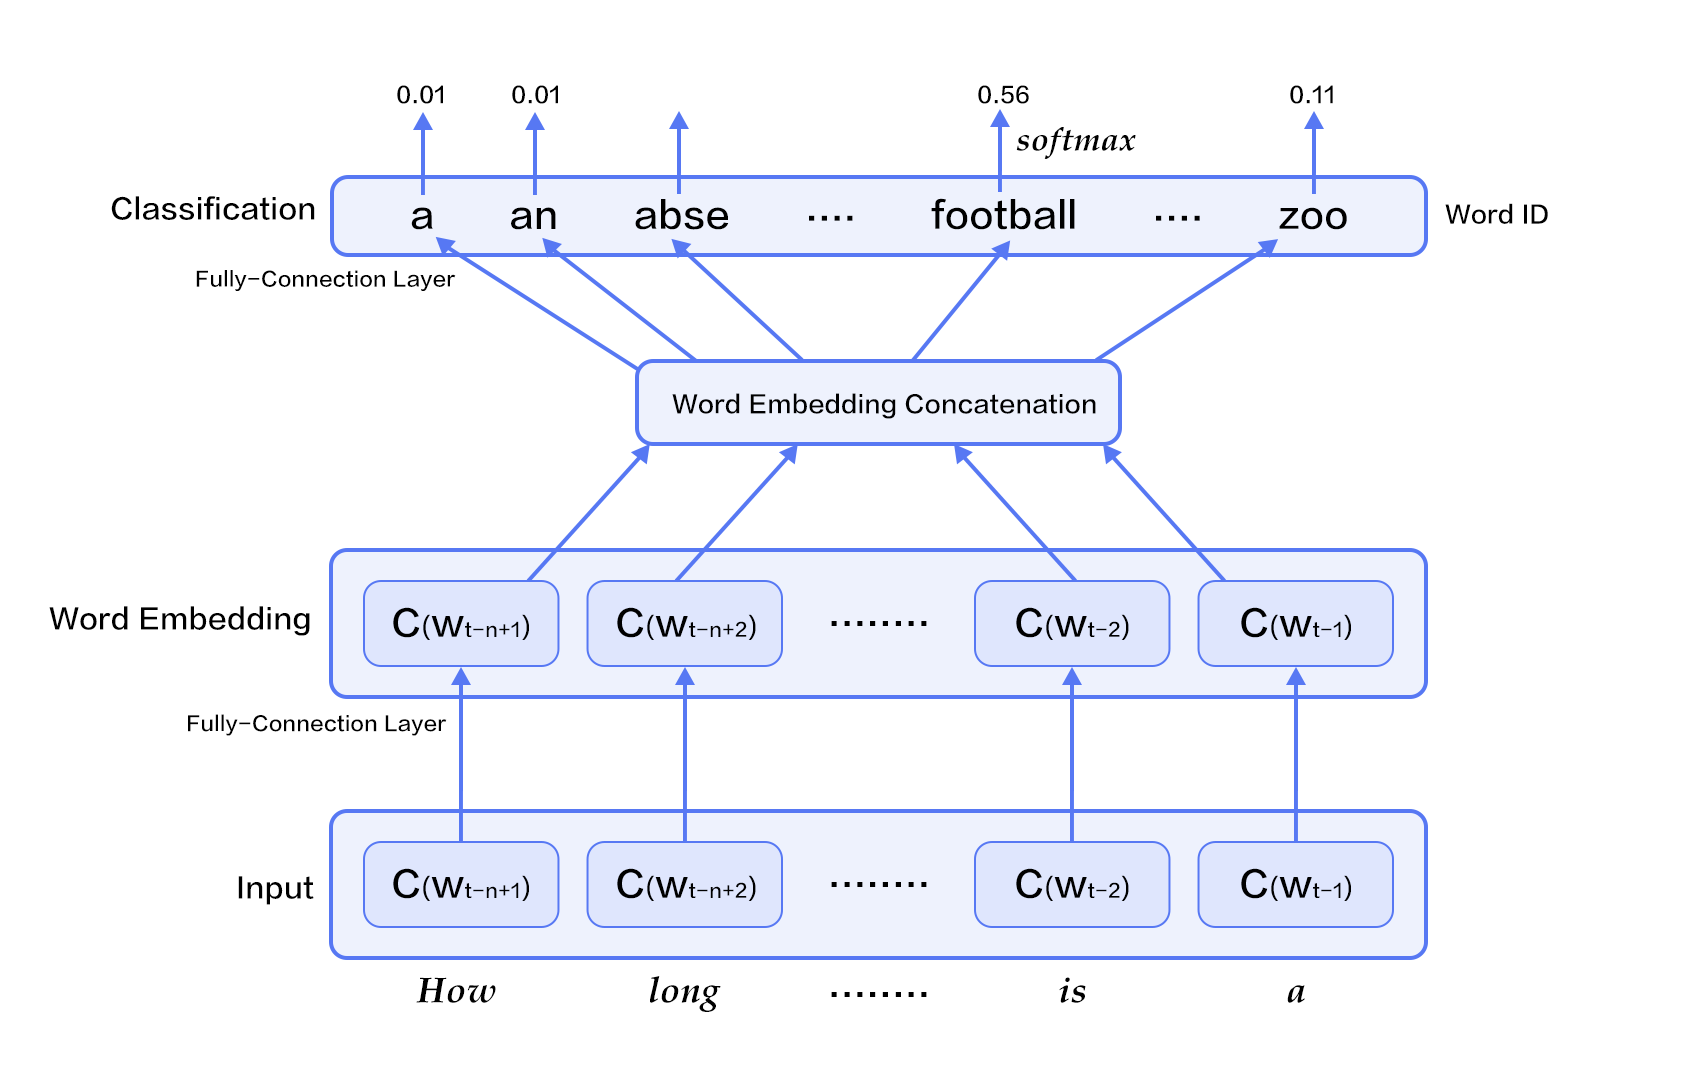

In [1]:
# n-gram model
import math
import paddle.v2 as paddle

In [2]:
# congigure parameter
embsize = 32 # word vector dimension
hiddensize = 256 # hidden layer dimension
N = 5 # train 5-gram

In [3]:
# save and load word dict and embedding table
def save_dict_and_embedding(word_dict, embeddings):
    with open("word_dict", "w") as f:
        for key in word_dict:
            f.write(key + " " + str(word_dict[key]) + "\n")
    with open("embedding_table", "w") as f:
        numpy.savetxt(f, embeddings, delimiter=',', newline='\n')


def load_dict_and_embedding():
    word_dict = dict()
    with open("word_dict", "r") as f:
        for line in f:
            key, value = line.strip().split(" ")
            word_dict[key] = int(value)

    embeddings = numpy.loadtxt("embedding_table", delimiter=",")
    return word_dict, embeddings

In [4]:
def wordemb(inlayer):
    wordemb = paddle.layer.table_projection(
        input=inlayer,
        size=embsize,
        param_attr=paddle.attr.Param(
            name="_proj",
            initial_std=0.001,
            learning_rate=1,
            l2_rate=0,
            sparse_update=True))
    return wordemb

In [5]:
paddle.init(use_gpu=False, trainer_count=3)
word_dict = paddle.dataset.imikolov.build_dict()
dict_size = len(word_dict)
# Every layer takes integer value of range [0, dict_size)
firstword = paddle.layer.data(
    name="firstw", type=paddle.data_type.integer_value(dict_size))
secondword = paddle.layer.data(
    name="secondw", type=paddle.data_type.integer_value(dict_size))
thirdword = paddle.layer.data(
    name="thirdw", type=paddle.data_type.integer_value(dict_size))
fourthword = paddle.layer.data(
    name="fourthw", type=paddle.data_type.integer_value(dict_size))
nextword = paddle.layer.data(
    name="fifthw", type=paddle.data_type.integer_value(dict_size))

Efirst = wordemb(firstword)
Esecond = wordemb(secondword)
Ethird = wordemb(thirdword)
Efourth = wordemb(fourthword)

In [6]:
# Concatenate n-1 word embedding vectors into a single feature vector.
contextemb = paddle.layer.concat(input=[Efirst, Esecond, Ethird, Efourth])

In [7]:
# Feature vector will go through a fully connected layer which outputs a hidden feature vector.
hidden1 = paddle.layer.fc(input=contextemb,
                          size=hiddensize,
                          act=paddle.activation.Sigmoid(),
                          layer_attr=paddle.attr.Extra(drop_rate=0.5),
                          bias_attr=paddle.attr.Param(learning_rate=2),
                          param_attr=paddle.attr.Param(
                                initial_std=1. / math.sqrt(embsize * 8),
                                learning_rate=1))

In [8]:
# Hidden feature vector will go through another fully conected layer, turn into a |V| dimensional vector. At the same time softmax will be applied to get the probability of each word being generated.
predictword = paddle.layer.fc(input=hidden1,
                              size=dict_size,
                              bias_attr=paddle.attr.Param(learning_rate=2),
                              act=paddle.activation.Softmax())

In [9]:
# use cross-entropy cost function.
cost = paddle.layer.classification_cost(input=predictword, label=nextword)

In [10]:
# create parameter,optimizer and trainer.
parameters = paddle.parameters.create(cost)
adagrad = paddle.optimizer.AdaGrad(
    learning_rate=3e-3,
    regularization=paddle.optimizer.L2Regularization(8e-4))
trainer = paddle.trainer.SGD(cost, parameters, adagrad)

In [11]:
def event_handler(event):
    if isinstance(event, paddle.event.EndIteration):
        if event.batch_id % 100 == 0:
            print "Pass %d, Batch %d, Cost %f, %s" % (
                event.pass_id, event.batch_id, event.cost, event.metrics)

    if isinstance(event, paddle.event.EndPass):
        result = trainer.test(
                    paddle.batch(
                        paddle.dataset.imikolov.test(word_dict, N), 32))
        print "Pass %d, Testing metrics %s" % (event.pass_id, result.metrics)
        with open("model_%d.tar"%event.pass_id, 'w') as f:
            trainer.save_parameter_to_tar(f)

trainer.train(
    paddle.batch(paddle.dataset.imikolov.train(word_dict, N), 32),
    num_passes=100,
    event_handler=event_handler)

Pass 0, Batch 0, Cost 7.917494, {'classification_error_evaluator': 1.0}
Pass 0, Batch 100, Cost 6.071079, {'classification_error_evaluator': 0.8125}
Pass 0, Batch 200, Cost 5.784702, {'classification_error_evaluator': 0.8125}
Pass 0, Batch 300, Cost 5.434321, {'classification_error_evaluator': 0.90625}
Pass 0, Batch 400, Cost 4.254411, {'classification_error_evaluator': 0.5625}
Pass 0, Batch 500, Cost 5.888997, {'classification_error_evaluator': 0.875}
Pass 0, Batch 600, Cost 6.103899, {'classification_error_evaluator': 0.875}
Pass 0, Batch 700, Cost 5.895082, {'classification_error_evaluator': 0.78125}
Pass 0, Batch 800, Cost 6.015155, {'classification_error_evaluator': 0.9375}
Pass 0, Batch 900, Cost 5.839024, {'classification_error_evaluator': 0.6875}
Pass 0, Batch 1000, Cost 5.781264, {'classification_error_evaluator': 0.9375}
Pass 0, Batch 1100, Cost 5.626380, {'classification_error_evaluator': 0.75}
Pass 0, Batch 1200, Cost 5.868928, {'classification_error_evaluator': 0.84375}
Pa

Pass 0, Batch 10600, Cost 3.911773, {'classification_error_evaluator': 0.625}
Pass 0, Batch 10700, Cost 5.418509, {'classification_error_evaluator': 0.84375}
Pass 0, Batch 10800, Cost 5.613924, {'classification_error_evaluator': 0.90625}
Pass 0, Batch 10900, Cost 4.878586, {'classification_error_evaluator': 0.8125}
Pass 0, Batch 11000, Cost 4.286072, {'classification_error_evaluator': 0.5625}
Pass 0, Batch 11100, Cost 5.722651, {'classification_error_evaluator': 0.78125}
Pass 0, Batch 11200, Cost 5.193228, {'classification_error_evaluator': 0.90625}
Pass 0, Batch 11300, Cost 5.118118, {'classification_error_evaluator': 0.875}
Pass 0, Batch 11400, Cost 5.588238, {'classification_error_evaluator': 0.8125}
Pass 0, Batch 11500, Cost 5.097806, {'classification_error_evaluator': 0.875}
Pass 0, Batch 11600, Cost 5.074416, {'classification_error_evaluator': 0.71875}
Pass 0, Batch 11700, Cost 5.112112, {'classification_error_evaluator': 0.875}
Pass 0, Batch 11800, Cost 5.206672, {'classificatio

Pass 0, Batch 21000, Cost 4.741863, {'classification_error_evaluator': 0.875}
Pass 0, Batch 21100, Cost 5.585576, {'classification_error_evaluator': 0.96875}
Pass 0, Batch 21200, Cost 4.963542, {'classification_error_evaluator': 0.96875}
Pass 0, Batch 21300, Cost 4.976852, {'classification_error_evaluator': 0.78125}
Pass 0, Batch 21400, Cost 4.775665, {'classification_error_evaluator': 0.78125}
Pass 0, Batch 21500, Cost 5.762726, {'classification_error_evaluator': 0.90625}
Pass 0, Batch 21600, Cost 5.494312, {'classification_error_evaluator': 0.84375}
Pass 0, Batch 21700, Cost 4.560194, {'classification_error_evaluator': 0.75}
Pass 0, Batch 21800, Cost 6.308197, {'classification_error_evaluator': 0.9375}
Pass 0, Batch 21900, Cost 5.339639, {'classification_error_evaluator': 0.8125}
Pass 0, Batch 22000, Cost 5.581989, {'classification_error_evaluator': 0.90625}
Pass 0, Batch 22100, Cost 5.204538, {'classification_error_evaluator': 0.8125}
Pass 0, Batch 22200, Cost 5.157015, {'classifica

Pass 1, Batch 6200, Cost 5.958371, {'classification_error_evaluator': 1.0}
Pass 1, Batch 6300, Cost 5.825973, {'classification_error_evaluator': 0.875}
Pass 1, Batch 6400, Cost 4.999030, {'classification_error_evaluator': 0.75}
Pass 1, Batch 6500, Cost 5.532143, {'classification_error_evaluator': 0.90625}
Pass 1, Batch 6600, Cost 5.948341, {'classification_error_evaluator': 0.875}
Pass 1, Batch 6700, Cost 4.964829, {'classification_error_evaluator': 0.8125}
Pass 1, Batch 6800, Cost 5.769822, {'classification_error_evaluator': 0.875}
Pass 1, Batch 6900, Cost 4.369907, {'classification_error_evaluator': 0.75}
Pass 1, Batch 7000, Cost 5.609946, {'classification_error_evaluator': 0.84375}
Pass 1, Batch 7100, Cost 4.990608, {'classification_error_evaluator': 0.8125}
Pass 1, Batch 7200, Cost 6.096882, {'classification_error_evaluator': 0.9375}
Pass 1, Batch 7300, Cost 5.272151, {'classification_error_evaluator': 0.84375}
Pass 1, Batch 7400, Cost 4.621850, {'classification_error_evaluator': 0

Pass 1, Batch 16700, Cost 5.841147, {'classification_error_evaluator': 0.90625}
Pass 1, Batch 16800, Cost 5.597503, {'classification_error_evaluator': 0.875}
Pass 1, Batch 16900, Cost 5.876526, {'classification_error_evaluator': 0.875}
Pass 1, Batch 17000, Cost 5.787472, {'classification_error_evaluator': 0.75}
Pass 1, Batch 17100, Cost 4.961159, {'classification_error_evaluator': 0.8125}
Pass 1, Batch 17200, Cost 5.296582, {'classification_error_evaluator': 0.71875}
Pass 1, Batch 17300, Cost 6.409404, {'classification_error_evaluator': 0.96875}
Pass 1, Batch 17400, Cost 4.901454, {'classification_error_evaluator': 0.8125}
Pass 1, Batch 17500, Cost 5.441617, {'classification_error_evaluator': 0.875}
Pass 1, Batch 17600, Cost 5.751024, {'classification_error_evaluator': 0.90625}
Pass 1, Batch 17700, Cost 4.865259, {'classification_error_evaluator': 0.625}
Pass 1, Batch 17800, Cost 4.715881, {'classification_error_evaluator': 0.71875}
Pass 1, Batch 17900, Cost 4.839258, {'classification_

Pass 2, Batch 1900, Cost 5.975825, {'classification_error_evaluator': 0.84375}
Pass 2, Batch 2000, Cost 6.253643, {'classification_error_evaluator': 0.875}
Pass 2, Batch 2100, Cost 4.787033, {'classification_error_evaluator': 0.78125}
Pass 2, Batch 2200, Cost 4.624969, {'classification_error_evaluator': 0.75}
Pass 2, Batch 2300, Cost 4.878312, {'classification_error_evaluator': 0.84375}
Pass 2, Batch 2400, Cost 4.181593, {'classification_error_evaluator': 0.625}
Pass 2, Batch 2500, Cost 4.982740, {'classification_error_evaluator': 0.8125}
Pass 2, Batch 2600, Cost 5.821396, {'classification_error_evaluator': 0.875}
Pass 2, Batch 2700, Cost 5.586416, {'classification_error_evaluator': 0.875}
Pass 2, Batch 2800, Cost 4.479376, {'classification_error_evaluator': 0.71875}
Pass 2, Batch 2900, Cost 5.323256, {'classification_error_evaluator': 0.8125}
Pass 2, Batch 3000, Cost 5.384779, {'classification_error_evaluator': 0.875}
Pass 2, Batch 3100, Cost 5.076448, {'classification_error_evaluator

Pass 2, Batch 12400, Cost 4.654079, {'classification_error_evaluator': 0.71875}
Pass 2, Batch 12500, Cost 4.770351, {'classification_error_evaluator': 0.75}
Pass 2, Batch 12600, Cost 4.094661, {'classification_error_evaluator': 0.78125}
Pass 2, Batch 12700, Cost 5.059680, {'classification_error_evaluator': 0.8125}
Pass 2, Batch 12800, Cost 6.011877, {'classification_error_evaluator': 0.9375}
Pass 2, Batch 12900, Cost 6.472337, {'classification_error_evaluator': 0.9375}
Pass 2, Batch 13000, Cost 4.607948, {'classification_error_evaluator': 0.75}
Pass 2, Batch 13100, Cost 4.934951, {'classification_error_evaluator': 0.84375}
Pass 2, Batch 13200, Cost 4.693274, {'classification_error_evaluator': 0.84375}
Pass 2, Batch 13300, Cost 4.603999, {'classification_error_evaluator': 0.75}
Pass 2, Batch 13400, Cost 5.641078, {'classification_error_evaluator': 0.90625}
Pass 2, Batch 13500, Cost 5.300823, {'classification_error_evaluator': 0.875}
Pass 2, Batch 13600, Cost 5.401010, {'classification_e

Pass 2, Batch 22800, Cost 5.216254, {'classification_error_evaluator': 0.78125}
Pass 2, Batch 22900, Cost 3.948435, {'classification_error_evaluator': 0.65625}
Pass 2, Batch 23000, Cost 3.803067, {'classification_error_evaluator': 0.625}
Pass 2, Batch 23100, Cost 4.302910, {'classification_error_evaluator': 0.625}
Pass 2, Batch 23200, Cost 6.125802, {'classification_error_evaluator': 0.9375}
Pass 2, Batch 23300, Cost 3.406494, {'classification_error_evaluator': 0.59375}
Pass 2, Batch 23400, Cost 4.659412, {'classification_error_evaluator': 0.84375}
Pass 2, Batch 23500, Cost 5.380706, {'classification_error_evaluator': 0.875}
Pass 2, Batch 23600, Cost 5.525395, {'classification_error_evaluator': 0.84375}
Pass 2, Batch 23700, Cost 3.966330, {'classification_error_evaluator': 0.6875}
Pass 2, Batch 23800, Cost 4.261446, {'classification_error_evaluator': 0.6875}
Pass 2, Batch 23900, Cost 3.813351, {'classification_error_evaluator': 0.65625}
Pass 2, Batch 24000, Cost 5.688036, {'classificat

Pass 3, Batch 8000, Cost 4.353734, {'classification_error_evaluator': 0.65625}
Pass 3, Batch 8100, Cost 4.734871, {'classification_error_evaluator': 0.78125}
Pass 3, Batch 8200, Cost 5.912652, {'classification_error_evaluator': 0.9375}
Pass 3, Batch 8300, Cost 4.592142, {'classification_error_evaluator': 0.625}
Pass 3, Batch 8400, Cost 4.897799, {'classification_error_evaluator': 0.75}
Pass 3, Batch 8500, Cost 5.698887, {'classification_error_evaluator': 0.875}
Pass 3, Batch 8600, Cost 5.306285, {'classification_error_evaluator': 0.875}
Pass 3, Batch 8700, Cost 5.449518, {'classification_error_evaluator': 0.875}
Pass 3, Batch 8800, Cost 4.497344, {'classification_error_evaluator': 0.65625}
Pass 3, Batch 8900, Cost 4.831007, {'classification_error_evaluator': 0.75}
Pass 3, Batch 9000, Cost 5.137914, {'classification_error_evaluator': 0.8125}
Pass 3, Batch 9100, Cost 5.050578, {'classification_error_evaluator': 0.8125}
Pass 3, Batch 9200, Cost 5.426733, {'classification_error_evaluator':

Pass 3, Batch 18500, Cost 4.772375, {'classification_error_evaluator': 0.78125}
Pass 3, Batch 18600, Cost 4.726253, {'classification_error_evaluator': 0.71875}
Pass 3, Batch 18700, Cost 5.351768, {'classification_error_evaluator': 0.875}
Pass 3, Batch 18800, Cost 5.367232, {'classification_error_evaluator': 0.78125}
Pass 3, Batch 18900, Cost 5.734152, {'classification_error_evaluator': 0.875}
Pass 3, Batch 19000, Cost 5.348693, {'classification_error_evaluator': 0.8125}
Pass 3, Batch 19100, Cost 5.336829, {'classification_error_evaluator': 0.84375}
Pass 3, Batch 19200, Cost 5.663478, {'classification_error_evaluator': 0.875}
Pass 3, Batch 19300, Cost 5.664876, {'classification_error_evaluator': 0.84375}
Pass 3, Batch 19400, Cost 6.160777, {'classification_error_evaluator': 1.0}
Pass 3, Batch 19500, Cost 6.154390, {'classification_error_evaluator': 0.96875}
Pass 3, Batch 19600, Cost 4.729242, {'classification_error_evaluator': 0.71875}
Pass 3, Batch 19700, Cost 5.082956, {'classificatio

Pass 4, Batch 3700, Cost 4.713370, {'classification_error_evaluator': 0.71875}
Pass 4, Batch 3800, Cost 5.224138, {'classification_error_evaluator': 0.84375}
Pass 4, Batch 3900, Cost 5.696964, {'classification_error_evaluator': 0.875}
Pass 4, Batch 4000, Cost 5.552086, {'classification_error_evaluator': 0.8125}
Pass 4, Batch 4100, Cost 4.738629, {'classification_error_evaluator': 0.8125}
Pass 4, Batch 4200, Cost 5.910954, {'classification_error_evaluator': 0.90625}
Pass 4, Batch 4300, Cost 5.174443, {'classification_error_evaluator': 0.75}
Pass 4, Batch 4400, Cost 5.826714, {'classification_error_evaluator': 0.90625}
Pass 4, Batch 4500, Cost 4.937107, {'classification_error_evaluator': 0.8125}
Pass 4, Batch 4600, Cost 4.813124, {'classification_error_evaluator': 0.78125}
Pass 4, Batch 4700, Cost 4.403262, {'classification_error_evaluator': 0.71875}
Pass 4, Batch 4800, Cost 4.494792, {'classification_error_evaluator': 0.75}
Pass 4, Batch 4900, Cost 5.115582, {'classification_error_evalu

Pass 4, Batch 14200, Cost 3.933972, {'classification_error_evaluator': 0.59375}
Pass 4, Batch 14300, Cost 5.283541, {'classification_error_evaluator': 0.875}
Pass 4, Batch 14400, Cost 5.178828, {'classification_error_evaluator': 0.78125}
Pass 4, Batch 14500, Cost 3.702941, {'classification_error_evaluator': 0.59375}
Pass 4, Batch 14600, Cost 5.014684, {'classification_error_evaluator': 0.71875}
Pass 4, Batch 14700, Cost 5.513165, {'classification_error_evaluator': 0.84375}
Pass 4, Batch 14800, Cost 5.816264, {'classification_error_evaluator': 0.9375}
Pass 4, Batch 14900, Cost 5.644932, {'classification_error_evaluator': 0.84375}
Pass 4, Batch 15000, Cost 4.013347, {'classification_error_evaluator': 0.71875}
Pass 4, Batch 15100, Cost 4.064686, {'classification_error_evaluator': 0.65625}
Pass 4, Batch 15200, Cost 5.143182, {'classification_error_evaluator': 0.90625}
Pass 4, Batch 15300, Cost 5.271605, {'classification_error_evaluator': 0.84375}
Pass 4, Batch 15400, Cost 4.809437, {'class

Pass 4, Batch 24600, Cost 4.906312, {'classification_error_evaluator': 0.78125}
Pass 4, Batch 24700, Cost 4.888126, {'classification_error_evaluator': 0.8125}
Pass 4, Batch 24800, Cost 3.925968, {'classification_error_evaluator': 0.625}
Pass 4, Batch 24900, Cost 4.542135, {'classification_error_evaluator': 0.75}
Pass 4, Batch 25000, Cost 5.211510, {'classification_error_evaluator': 0.875}
Pass 4, Batch 25100, Cost 5.134125, {'classification_error_evaluator': 0.78125}
Pass 4, Testing metrics {'classification_error_evaluator': 0.7957054972648621}
Pass 5, Batch 0, Cost 2.705606, {'classification_error_evaluator': 0.28125}
Pass 5, Batch 100, Cost 5.577968, {'classification_error_evaluator': 0.8125}
Pass 5, Batch 200, Cost 5.186017, {'classification_error_evaluator': 0.75}
Pass 5, Batch 300, Cost 5.087914, {'classification_error_evaluator': 0.90625}
Pass 5, Batch 400, Cost 4.031064, {'classification_error_evaluator': 0.59375}
Pass 5, Batch 500, Cost 5.482292, {'classification_error_evaluato

Pass 5, Batch 9900, Cost 5.623142, {'classification_error_evaluator': 0.9375}
Pass 5, Batch 10000, Cost 6.252179, {'classification_error_evaluator': 0.84375}
Pass 5, Batch 10100, Cost 5.967877, {'classification_error_evaluator': 0.875}
Pass 5, Batch 10200, Cost 5.023770, {'classification_error_evaluator': 0.6875}
Pass 5, Batch 10300, Cost 6.004245, {'classification_error_evaluator': 0.90625}
Pass 5, Batch 10400, Cost 5.368393, {'classification_error_evaluator': 0.78125}
Pass 5, Batch 10500, Cost 4.391029, {'classification_error_evaluator': 0.6875}
Pass 5, Batch 10600, Cost 3.653914, {'classification_error_evaluator': 0.59375}
Pass 5, Batch 10700, Cost 5.321914, {'classification_error_evaluator': 0.8125}
Pass 5, Batch 10800, Cost 5.346137, {'classification_error_evaluator': 0.84375}
Pass 5, Batch 10900, Cost 4.521973, {'classification_error_evaluator': 0.8125}
Pass 5, Batch 11000, Cost 3.988491, {'classification_error_evaluator': 0.5625}
Pass 5, Batch 11100, Cost 5.545277, {'classificat

Pass 5, Batch 20300, Cost 5.089816, {'classification_error_evaluator': 0.78125}
Pass 5, Batch 20400, Cost 5.258893, {'classification_error_evaluator': 0.875}
Pass 5, Batch 20500, Cost 4.977346, {'classification_error_evaluator': 0.8125}
Pass 5, Batch 20600, Cost 4.256940, {'classification_error_evaluator': 0.65625}
Pass 5, Batch 20700, Cost 5.072024, {'classification_error_evaluator': 0.8125}
Pass 5, Batch 20800, Cost 4.847927, {'classification_error_evaluator': 0.78125}
Pass 5, Batch 20900, Cost 5.021523, {'classification_error_evaluator': 0.8125}
Pass 5, Batch 21000, Cost 4.169772, {'classification_error_evaluator': 0.75}
Pass 5, Batch 21100, Cost 4.916826, {'classification_error_evaluator': 0.84375}
Pass 5, Batch 21200, Cost 4.588560, {'classification_error_evaluator': 0.75}
Pass 5, Batch 21300, Cost 4.884402, {'classification_error_evaluator': 0.78125}
Pass 5, Batch 21400, Cost 4.451787, {'classification_error_evaluator': 0.75}
Pass 5, Batch 21500, Cost 5.410504, {'classification_e

Pass 6, Batch 5500, Cost 5.430650, {'classification_error_evaluator': 0.84375}
Pass 6, Batch 5600, Cost 4.151673, {'classification_error_evaluator': 0.6875}
Pass 6, Batch 5700, Cost 5.729133, {'classification_error_evaluator': 0.8125}
Pass 6, Batch 5800, Cost 4.342660, {'classification_error_evaluator': 0.75}
Pass 6, Batch 5900, Cost 4.795015, {'classification_error_evaluator': 0.75}
Pass 6, Batch 6000, Cost 4.874603, {'classification_error_evaluator': 0.84375}
Pass 6, Batch 6100, Cost 4.280218, {'classification_error_evaluator': 0.71875}
Pass 6, Batch 6200, Cost 5.653242, {'classification_error_evaluator': 0.9375}
Pass 6, Batch 6300, Cost 5.753293, {'classification_error_evaluator': 0.875}
Pass 6, Batch 6400, Cost 4.743595, {'classification_error_evaluator': 0.71875}
Pass 6, Batch 6500, Cost 5.376160, {'classification_error_evaluator': 0.9375}
Pass 6, Batch 6600, Cost 5.848875, {'classification_error_evaluator': 0.875}
Pass 6, Batch 6700, Cost 4.566175, {'classification_error_evaluato

Pass 6, Batch 15900, Cost 5.148728, {'classification_error_evaluator': 0.8125}
Pass 6, Batch 16000, Cost 5.172068, {'classification_error_evaluator': 0.8125}
Pass 6, Batch 16100, Cost 5.816482, {'classification_error_evaluator': 0.90625}
Pass 6, Batch 16200, Cost 5.282343, {'classification_error_evaluator': 0.8125}
Pass 6, Batch 16300, Cost 5.053975, {'classification_error_evaluator': 0.75}
Pass 6, Batch 16400, Cost 6.078060, {'classification_error_evaluator': 0.9375}
Pass 6, Batch 16500, Cost 3.841455, {'classification_error_evaluator': 0.71875}
Pass 6, Batch 16600, Cost 5.019721, {'classification_error_evaluator': 0.875}
Pass 6, Batch 16700, Cost 5.743266, {'classification_error_evaluator': 0.90625}
Pass 6, Batch 16800, Cost 5.359916, {'classification_error_evaluator': 0.84375}
Pass 6, Batch 16900, Cost 5.671471, {'classification_error_evaluator': 0.875}
Pass 6, Batch 17000, Cost 5.680066, {'classification_error_evaluator': 0.75}
Pass 6, Batch 17100, Cost 4.528051, {'classification_e

Pass 7, Batch 1000, Cost 5.289587, {'classification_error_evaluator': 0.8125}
Pass 7, Batch 1100, Cost 5.195904, {'classification_error_evaluator': 0.71875}
Pass 7, Batch 1200, Cost 5.463225, {'classification_error_evaluator': 0.8125}
Pass 7, Batch 1300, Cost 4.785698, {'classification_error_evaluator': 0.78125}
Pass 7, Batch 1400, Cost 5.416958, {'classification_error_evaluator': 0.84375}
Pass 7, Batch 1500, Cost 5.675112, {'classification_error_evaluator': 0.8125}
Pass 7, Batch 1600, Cost 4.904625, {'classification_error_evaluator': 0.71875}
Pass 7, Batch 1700, Cost 5.322021, {'classification_error_evaluator': 0.8125}
Pass 7, Batch 1800, Cost 5.400960, {'classification_error_evaluator': 0.875}
Pass 7, Batch 1900, Cost 5.763486, {'classification_error_evaluator': 0.84375}
Pass 7, Batch 2000, Cost 6.192554, {'classification_error_evaluator': 0.90625}
Pass 7, Batch 2100, Cost 4.388899, {'classification_error_evaluator': 0.75}
Pass 7, Batch 2200, Cost 4.244671, {'classification_error_eva

Pass 7, Batch 11500, Cost 4.379486, {'classification_error_evaluator': 0.75}
Pass 7, Batch 11600, Cost 4.847743, {'classification_error_evaluator': 0.71875}
Pass 7, Batch 11700, Cost 4.665262, {'classification_error_evaluator': 0.84375}
Pass 7, Batch 11800, Cost 4.876348, {'classification_error_evaluator': 0.78125}
Pass 7, Batch 11900, Cost 5.232838, {'classification_error_evaluator': 0.84375}
Pass 7, Batch 12000, Cost 4.552010, {'classification_error_evaluator': 0.8125}
Pass 7, Batch 12100, Cost 4.373729, {'classification_error_evaluator': 0.75}
Pass 7, Batch 12200, Cost 4.634843, {'classification_error_evaluator': 0.8125}
Pass 7, Batch 12300, Cost 4.466150, {'classification_error_evaluator': 0.71875}
Pass 7, Batch 12400, Cost 4.393149, {'classification_error_evaluator': 0.75}
Pass 7, Batch 12500, Cost 4.582170, {'classification_error_evaluator': 0.71875}
Pass 7, Batch 12600, Cost 3.490693, {'classification_error_evaluator': 0.71875}
Pass 7, Batch 12700, Cost 4.872409, {'classificatio

Pass 7, Batch 21900, Cost 4.822221, {'classification_error_evaluator': 0.84375}
Pass 7, Batch 22000, Cost 5.077071, {'classification_error_evaluator': 0.84375}
Pass 7, Batch 22100, Cost 4.809793, {'classification_error_evaluator': 0.78125}
Pass 7, Batch 22200, Cost 4.992189, {'classification_error_evaluator': 0.78125}
Pass 7, Batch 22300, Cost 4.452068, {'classification_error_evaluator': 0.75}
Pass 7, Batch 22400, Cost 4.749347, {'classification_error_evaluator': 0.8125}
Pass 7, Batch 22500, Cost 5.447751, {'classification_error_evaluator': 0.8125}
Pass 7, Batch 22600, Cost 5.234853, {'classification_error_evaluator': 0.71875}
Pass 7, Batch 22700, Cost 5.128391, {'classification_error_evaluator': 0.84375}
Pass 7, Batch 22800, Cost 5.017075, {'classification_error_evaluator': 0.75}
Pass 7, Batch 22900, Cost 3.523252, {'classification_error_evaluator': 0.6875}
Pass 7, Batch 23000, Cost 3.824369, {'classification_error_evaluator': 0.59375}
Pass 7, Batch 23100, Cost 4.084832, {'classificat

Pass 8, Batch 7100, Cost 4.734162, {'classification_error_evaluator': 0.8125}
Pass 8, Batch 7200, Cost 5.747062, {'classification_error_evaluator': 0.9375}
Pass 8, Batch 7300, Cost 4.847329, {'classification_error_evaluator': 0.78125}
Pass 8, Batch 7400, Cost 4.561886, {'classification_error_evaluator': 0.625}
Pass 8, Batch 7500, Cost 5.568711, {'classification_error_evaluator': 0.875}
Pass 8, Batch 7600, Cost 5.485715, {'classification_error_evaluator': 0.84375}
Pass 8, Batch 7700, Cost 4.620174, {'classification_error_evaluator': 0.78125}
Pass 8, Batch 7800, Cost 4.348214, {'classification_error_evaluator': 0.71875}
Pass 8, Batch 7900, Cost 4.892757, {'classification_error_evaluator': 0.8125}
Pass 8, Batch 8000, Cost 4.106254, {'classification_error_evaluator': 0.625}
Pass 8, Batch 8100, Cost 4.721386, {'classification_error_evaluator': 0.78125}
Pass 8, Batch 8200, Cost 5.673116, {'classification_error_evaluator': 0.9375}
Pass 8, Batch 8300, Cost 4.707339, {'classification_error_eval

Pass 8, Batch 17500, Cost 4.921854, {'classification_error_evaluator': 0.84375}
Pass 8, Batch 17600, Cost 5.559013, {'classification_error_evaluator': 0.90625}
Pass 8, Batch 17700, Cost 4.810044, {'classification_error_evaluator': 0.65625}
Pass 8, Batch 17800, Cost 4.629725, {'classification_error_evaluator': 0.75}
Pass 8, Batch 17900, Cost 4.665011, {'classification_error_evaluator': 0.78125}
Pass 8, Batch 18000, Cost 3.697701, {'classification_error_evaluator': 0.71875}
Pass 8, Batch 18100, Cost 5.418606, {'classification_error_evaluator': 0.75}
Pass 8, Batch 18200, Cost 5.129695, {'classification_error_evaluator': 0.84375}
Pass 8, Batch 18300, Cost 4.497793, {'classification_error_evaluator': 0.71875}
Pass 8, Batch 18400, Cost 3.017584, {'classification_error_evaluator': 0.5625}
Pass 8, Batch 18500, Cost 4.717331, {'classification_error_evaluator': 0.8125}
Pass 8, Batch 18600, Cost 4.612588, {'classification_error_evaluator': 0.71875}
Pass 8, Batch 18700, Cost 5.171250, {'classifica

Pass 9, Batch 2600, Cost 5.555669, {'classification_error_evaluator': 0.875}
Pass 9, Batch 2700, Cost 5.347476, {'classification_error_evaluator': 0.8125}
Pass 9, Batch 2800, Cost 4.196424, {'classification_error_evaluator': 0.75}
Pass 9, Batch 2900, Cost 5.132348, {'classification_error_evaluator': 0.75}
Pass 9, Batch 3000, Cost 5.067024, {'classification_error_evaluator': 0.875}
Pass 9, Batch 3100, Cost 5.019126, {'classification_error_evaluator': 0.84375}
Pass 9, Batch 3200, Cost 5.476128, {'classification_error_evaluator': 0.84375}
Pass 9, Batch 3300, Cost 5.526832, {'classification_error_evaluator': 0.875}
Pass 9, Batch 3400, Cost 4.581619, {'classification_error_evaluator': 0.8125}
Pass 9, Batch 3500, Cost 4.230213, {'classification_error_evaluator': 0.625}
Pass 9, Batch 3600, Cost 4.647794, {'classification_error_evaluator': 0.8125}
Pass 9, Batch 3700, Cost 4.473989, {'classification_error_evaluator': 0.71875}
Pass 9, Batch 3800, Cost 5.156801, {'classification_error_evaluator':

Pass 9, Batch 13100, Cost 4.645092, {'classification_error_evaluator': 0.875}
Pass 9, Batch 13200, Cost 4.436233, {'classification_error_evaluator': 0.875}
Pass 9, Batch 13300, Cost 4.320733, {'classification_error_evaluator': 0.71875}
Pass 9, Batch 13400, Cost 5.278865, {'classification_error_evaluator': 0.84375}
Pass 9, Batch 13500, Cost 5.000371, {'classification_error_evaluator': 0.84375}
Pass 9, Batch 13600, Cost 5.095411, {'classification_error_evaluator': 0.8125}
Pass 9, Batch 13700, Cost 4.305820, {'classification_error_evaluator': 0.8125}
Pass 9, Batch 13800, Cost 4.872373, {'classification_error_evaluator': 0.8125}
Pass 9, Batch 13900, Cost 5.740698, {'classification_error_evaluator': 0.875}
Pass 9, Batch 14000, Cost 4.417846, {'classification_error_evaluator': 0.71875}
Pass 9, Batch 14100, Cost 5.694838, {'classification_error_evaluator': 0.875}
Pass 9, Batch 14200, Cost 3.773102, {'classification_error_evaluator': 0.625}
Pass 9, Batch 14300, Cost 5.066875, {'classification_

Pass 9, Batch 23500, Cost 5.017958, {'classification_error_evaluator': 0.8125}
Pass 9, Batch 23600, Cost 5.270219, {'classification_error_evaluator': 0.8125}
Pass 9, Batch 23700, Cost 3.698304, {'classification_error_evaluator': 0.65625}
Pass 9, Batch 23800, Cost 4.050847, {'classification_error_evaluator': 0.71875}
Pass 9, Batch 23900, Cost 3.314989, {'classification_error_evaluator': 0.625}
Pass 9, Batch 24000, Cost 5.432052, {'classification_error_evaluator': 0.875}
Pass 9, Batch 24100, Cost 4.935565, {'classification_error_evaluator': 0.8125}
Pass 9, Batch 24200, Cost 3.326722, {'classification_error_evaluator': 0.6875}
Pass 9, Batch 24300, Cost 5.501752, {'classification_error_evaluator': 0.84375}
Pass 9, Batch 24400, Cost 5.154281, {'classification_error_evaluator': 0.75}
Pass 9, Batch 24500, Cost 4.905331, {'classification_error_evaluator': 0.8125}
Pass 9, Batch 24600, Cost 4.701766, {'classification_error_evaluator': 0.78125}
Pass 9, Batch 24700, Cost 4.912276, {'classification

Pass 10, Batch 8600, Cost 5.120271, {'classification_error_evaluator': 0.84375}
Pass 10, Batch 8700, Cost 5.604248, {'classification_error_evaluator': 0.90625}
Pass 10, Batch 8800, Cost 4.489844, {'classification_error_evaluator': 0.625}
Pass 10, Batch 8900, Cost 4.852253, {'classification_error_evaluator': 0.75}
Pass 10, Batch 9000, Cost 4.911877, {'classification_error_evaluator': 0.8125}
Pass 10, Batch 9100, Cost 4.838804, {'classification_error_evaluator': 0.78125}
Pass 10, Batch 9200, Cost 5.173783, {'classification_error_evaluator': 0.8125}
Pass 10, Batch 9300, Cost 5.688937, {'classification_error_evaluator': 0.84375}
Pass 10, Batch 9400, Cost 3.841830, {'classification_error_evaluator': 0.59375}
Pass 10, Batch 9500, Cost 4.435287, {'classification_error_evaluator': 0.75}
Pass 10, Batch 9600, Cost 6.051095, {'classification_error_evaluator': 0.84375}
Pass 10, Batch 9700, Cost 4.910053, {'classification_error_evaluator': 0.8125}
Pass 10, Batch 9800, Cost 4.494911, {'classificatio

Pass 10, Batch 18900, Cost 5.549010, {'classification_error_evaluator': 0.84375}
Pass 10, Batch 19000, Cost 5.152642, {'classification_error_evaluator': 0.8125}
Pass 10, Batch 19100, Cost 5.098170, {'classification_error_evaluator': 0.8125}
Pass 10, Batch 19200, Cost 5.575707, {'classification_error_evaluator': 0.90625}
Pass 10, Batch 19300, Cost 5.600177, {'classification_error_evaluator': 0.84375}
Pass 10, Batch 19400, Cost 6.144402, {'classification_error_evaluator': 0.90625}
Pass 10, Batch 19500, Cost 6.157516, {'classification_error_evaluator': 1.0}
Pass 10, Batch 19600, Cost 4.644327, {'classification_error_evaluator': 0.8125}
Pass 10, Batch 19700, Cost 5.043504, {'classification_error_evaluator': 0.75}
Pass 10, Batch 19800, Cost 4.129898, {'classification_error_evaluator': 0.65625}
Pass 10, Batch 19900, Cost 4.645506, {'classification_error_evaluator': 0.71875}
Pass 10, Batch 20000, Cost 4.656533, {'classification_error_evaluator': 0.75}
Pass 10, Batch 20100, Cost 4.507397, {'cl

Pass 11, Batch 4000, Cost 5.399609, {'classification_error_evaluator': 0.78125}
Pass 11, Batch 4100, Cost 4.715225, {'classification_error_evaluator': 0.84375}
Pass 11, Batch 4200, Cost 5.759443, {'classification_error_evaluator': 0.875}
Pass 11, Batch 4300, Cost 5.126314, {'classification_error_evaluator': 0.8125}
Pass 11, Batch 4400, Cost 5.625906, {'classification_error_evaluator': 0.875}
Pass 11, Batch 4500, Cost 4.960773, {'classification_error_evaluator': 0.84375}
Pass 11, Batch 4600, Cost 4.665188, {'classification_error_evaluator': 0.75}
Pass 11, Batch 4700, Cost 4.384257, {'classification_error_evaluator': 0.78125}
Pass 11, Batch 4800, Cost 4.402848, {'classification_error_evaluator': 0.71875}
Pass 11, Batch 4900, Cost 5.117405, {'classification_error_evaluator': 0.8125}
Pass 11, Batch 5000, Cost 6.056921, {'classification_error_evaluator': 0.90625}
Pass 11, Batch 5100, Cost 4.676002, {'classification_error_evaluator': 0.75}
Pass 11, Batch 5200, Cost 4.604771, {'classification

Pass 11, Batch 14300, Cost 5.224200, {'classification_error_evaluator': 0.90625}
Pass 11, Batch 14400, Cost 4.877908, {'classification_error_evaluator': 0.8125}
Pass 11, Batch 14500, Cost 3.598744, {'classification_error_evaluator': 0.59375}
Pass 11, Batch 14600, Cost 4.884303, {'classification_error_evaluator': 0.6875}
Pass 11, Batch 14700, Cost 5.363503, {'classification_error_evaluator': 0.84375}
Pass 11, Batch 14800, Cost 5.660385, {'classification_error_evaluator': 0.9375}
Pass 11, Batch 14900, Cost 5.487287, {'classification_error_evaluator': 0.875}
Pass 11, Batch 15000, Cost 3.940357, {'classification_error_evaluator': 0.75}
Pass 11, Batch 15100, Cost 3.933352, {'classification_error_evaluator': 0.65625}
Pass 11, Batch 15200, Cost 5.105821, {'classification_error_evaluator': 0.875}
Pass 11, Batch 15300, Cost 4.935325, {'classification_error_evaluator': 0.84375}
Pass 11, Batch 15400, Cost 4.408196, {'classification_error_evaluator': 0.8125}
Pass 11, Batch 15500, Cost 4.603134, {'

Pass 11, Batch 24600, Cost 4.764310, {'classification_error_evaluator': 0.75}
Pass 11, Batch 24700, Cost 4.832839, {'classification_error_evaluator': 0.8125}
Pass 11, Batch 24800, Cost 3.906403, {'classification_error_evaluator': 0.625}
Pass 11, Batch 24900, Cost 4.418081, {'classification_error_evaluator': 0.75}
Pass 11, Batch 25000, Cost 4.982965, {'classification_error_evaluator': 0.9375}
Pass 11, Batch 25100, Cost 5.073539, {'classification_error_evaluator': 0.78125}
Pass 11, Testing metrics {'classification_error_evaluator': 0.7861238121986389}
Pass 12, Batch 0, Cost 2.745143, {'classification_error_evaluator': 0.3125}
Pass 12, Batch 100, Cost 5.517332, {'classification_error_evaluator': 0.84375}
Pass 12, Batch 200, Cost 5.078538, {'classification_error_evaluator': 0.75}
Pass 12, Batch 300, Cost 4.838888, {'classification_error_evaluator': 0.875}
Pass 12, Batch 400, Cost 3.922581, {'classification_error_evaluator': 0.625}
Pass 12, Batch 500, Cost 5.392671, {'classification_error_e

Pass 12, Batch 9700, Cost 4.805910, {'classification_error_evaluator': 0.84375}
Pass 12, Batch 9800, Cost 4.529687, {'classification_error_evaluator': 0.8125}
Pass 12, Batch 9900, Cost 5.615109, {'classification_error_evaluator': 0.96875}
Pass 12, Batch 10000, Cost 6.032171, {'classification_error_evaluator': 0.875}
Pass 12, Batch 10100, Cost 5.813755, {'classification_error_evaluator': 0.875}
Pass 12, Batch 10200, Cost 4.815112, {'classification_error_evaluator': 0.75}
Pass 12, Batch 10300, Cost 6.031564, {'classification_error_evaluator': 0.875}
Pass 12, Batch 10400, Cost 5.438532, {'classification_error_evaluator': 0.8125}
Pass 12, Batch 10500, Cost 4.298892, {'classification_error_evaluator': 0.65625}
Pass 12, Batch 10600, Cost 3.550158, {'classification_error_evaluator': 0.59375}
Pass 12, Batch 10700, Cost 5.037817, {'classification_error_evaluator': 0.78125}
Pass 12, Batch 10800, Cost 5.035134, {'classification_error_evaluator': 0.8125}
Pass 12, Batch 10900, Cost 4.348168, {'clas

Pass 12, Batch 20000, Cost 4.446047, {'classification_error_evaluator': 0.71875}
Pass 12, Batch 20100, Cost 4.485684, {'classification_error_evaluator': 0.78125}
Pass 12, Batch 20200, Cost 5.395647, {'classification_error_evaluator': 0.78125}
Pass 12, Batch 20300, Cost 5.144397, {'classification_error_evaluator': 0.71875}
Pass 12, Batch 20400, Cost 5.110646, {'classification_error_evaluator': 0.875}
Pass 12, Batch 20500, Cost 5.024042, {'classification_error_evaluator': 0.8125}
Pass 12, Batch 20600, Cost 4.182647, {'classification_error_evaluator': 0.71875}
Pass 12, Batch 20700, Cost 5.016908, {'classification_error_evaluator': 0.84375}
Pass 12, Batch 20800, Cost 4.765252, {'classification_error_evaluator': 0.75}
Pass 12, Batch 20900, Cost 4.990486, {'classification_error_evaluator': 0.78125}
Pass 12, Batch 21000, Cost 3.855540, {'classification_error_evaluator': 0.6875}
Pass 12, Batch 21100, Cost 4.790204, {'classification_error_evaluator': 0.875}
Pass 12, Batch 21200, Cost 4.388399, 

Pass 13, Batch 5100, Cost 4.604290, {'classification_error_evaluator': 0.78125}
Pass 13, Batch 5200, Cost 4.472290, {'classification_error_evaluator': 0.6875}
Pass 13, Batch 5300, Cost 4.356503, {'classification_error_evaluator': 0.71875}
Pass 13, Batch 5400, Cost 5.449858, {'classification_error_evaluator': 0.84375}
Pass 13, Batch 5500, Cost 5.429963, {'classification_error_evaluator': 0.84375}
Pass 13, Batch 5600, Cost 4.144215, {'classification_error_evaluator': 0.59375}
Pass 13, Batch 5700, Cost 5.688883, {'classification_error_evaluator': 0.8125}
Pass 13, Batch 5800, Cost 4.170825, {'classification_error_evaluator': 0.71875}
Pass 13, Batch 5900, Cost 4.698753, {'classification_error_evaluator': 0.78125}
Pass 13, Batch 6000, Cost 4.710149, {'classification_error_evaluator': 0.84375}
Pass 13, Batch 6100, Cost 4.197637, {'classification_error_evaluator': 0.71875}
Pass 13, Batch 6200, Cost 5.457730, {'classification_error_evaluator': 0.84375}
Pass 13, Batch 6300, Cost 5.550727, {'clas

Pass 13, Batch 15400, Cost 4.531772, {'classification_error_evaluator': 0.8125}
Pass 13, Batch 15500, Cost 4.496652, {'classification_error_evaluator': 0.65625}
Pass 13, Batch 15600, Cost 5.248078, {'classification_error_evaluator': 0.8125}
Pass 13, Batch 15700, Cost 5.030056, {'classification_error_evaluator': 0.875}
Pass 13, Batch 15800, Cost 4.974585, {'classification_error_evaluator': 0.84375}
Pass 13, Batch 15900, Cost 5.188480, {'classification_error_evaluator': 0.8125}
Pass 13, Batch 16000, Cost 5.060756, {'classification_error_evaluator': 0.8125}
Pass 13, Batch 16100, Cost 5.924587, {'classification_error_evaluator': 0.875}
Pass 13, Batch 16200, Cost 5.297863, {'classification_error_evaluator': 0.75}
Pass 13, Batch 16300, Cost 4.946647, {'classification_error_evaluator': 0.78125}
Pass 13, Batch 16400, Cost 5.885654, {'classification_error_evaluator': 0.96875}
Pass 13, Batch 16500, Cost 3.751779, {'classification_error_evaluator': 0.6875}
Pass 13, Batch 16600, Cost 4.840759, {'c

Pass 14, Batch 400, Cost 3.913135, {'classification_error_evaluator': 0.65625}
Pass 14, Batch 500, Cost 5.347932, {'classification_error_evaluator': 0.84375}
Pass 14, Batch 600, Cost 5.582436, {'classification_error_evaluator': 0.84375}
Pass 14, Batch 700, Cost 5.412427, {'classification_error_evaluator': 0.8125}
Pass 14, Batch 800, Cost 5.341130, {'classification_error_evaluator': 0.9375}
Pass 14, Batch 900, Cost 5.083650, {'classification_error_evaluator': 0.6875}
Pass 14, Batch 1000, Cost 5.368135, {'classification_error_evaluator': 0.84375}
Pass 14, Batch 1100, Cost 5.068041, {'classification_error_evaluator': 0.75}
Pass 14, Batch 1200, Cost 5.225686, {'classification_error_evaluator': 0.84375}
Pass 14, Batch 1300, Cost 4.767475, {'classification_error_evaluator': 0.75}
Pass 14, Batch 1400, Cost 5.330279, {'classification_error_evaluator': 0.875}
Pass 14, Batch 1500, Cost 5.462048, {'classification_error_evaluator': 0.78125}
Pass 14, Batch 1600, Cost 4.788357, {'classification_erro

Pass 14, Batch 10800, Cost 4.916046, {'classification_error_evaluator': 0.78125}
Pass 14, Batch 10900, Cost 4.502769, {'classification_error_evaluator': 0.8125}
Pass 14, Batch 11000, Cost 4.143380, {'classification_error_evaluator': 0.5625}
Pass 14, Batch 11100, Cost 5.333923, {'classification_error_evaluator': 0.75}
Pass 14, Batch 11200, Cost 4.326243, {'classification_error_evaluator': 0.78125}
Pass 14, Batch 11300, Cost 4.805079, {'classification_error_evaluator': 0.875}
Pass 14, Batch 11400, Cost 5.181343, {'classification_error_evaluator': 0.8125}
Pass 14, Batch 11500, Cost 4.201010, {'classification_error_evaluator': 0.71875}
Pass 14, Batch 11600, Cost 4.816978, {'classification_error_evaluator': 0.6875}
Pass 14, Batch 11700, Cost 4.624451, {'classification_error_evaluator': 0.84375}
Pass 14, Batch 11800, Cost 4.870207, {'classification_error_evaluator': 0.78125}
Pass 14, Batch 11900, Cost 5.146443, {'classification_error_evaluator': 0.8125}
Pass 14, Batch 12000, Cost 4.389635, {

Pass 14, Batch 21100, Cost 4.674170, {'classification_error_evaluator': 0.84375}
Pass 14, Batch 21200, Cost 4.263026, {'classification_error_evaluator': 0.78125}
Pass 14, Batch 21300, Cost 4.692533, {'classification_error_evaluator': 0.78125}
Pass 14, Batch 21400, Cost 4.429600, {'classification_error_evaluator': 0.71875}
Pass 14, Batch 21500, Cost 5.353878, {'classification_error_evaluator': 0.75}
Pass 14, Batch 21600, Cost 5.129028, {'classification_error_evaluator': 0.84375}
Pass 14, Batch 21700, Cost 4.401234, {'classification_error_evaluator': 0.71875}
Pass 14, Batch 21800, Cost 6.079866, {'classification_error_evaluator': 0.90625}
Pass 14, Batch 21900, Cost 4.846963, {'classification_error_evaluator': 0.84375}
Pass 14, Batch 22000, Cost 4.780805, {'classification_error_evaluator': 0.8125}
Pass 14, Batch 22100, Cost 4.714710, {'classification_error_evaluator': 0.75}
Pass 14, Batch 22200, Cost 5.005372, {'classification_error_evaluator': 0.71875}
Pass 14, Batch 22300, Cost 4.361072

Pass 15, Batch 6200, Cost 5.366266, {'classification_error_evaluator': 0.875}
Pass 15, Batch 6300, Cost 5.547013, {'classification_error_evaluator': 0.84375}
Pass 15, Batch 6400, Cost 4.559302, {'classification_error_evaluator': 0.8125}
Pass 15, Batch 6500, Cost 5.136063, {'classification_error_evaluator': 0.875}
Pass 15, Batch 6600, Cost 5.590886, {'classification_error_evaluator': 0.84375}
Pass 15, Batch 6700, Cost 4.431717, {'classification_error_evaluator': 0.8125}
Pass 15, Batch 6800, Cost 5.697041, {'classification_error_evaluator': 0.90625}
Pass 15, Batch 6900, Cost 3.963367, {'classification_error_evaluator': 0.6875}
Pass 15, Batch 7000, Cost 4.948364, {'classification_error_evaluator': 0.78125}
Pass 15, Batch 7100, Cost 4.666053, {'classification_error_evaluator': 0.8125}
Pass 15, Batch 7200, Cost 5.522045, {'classification_error_evaluator': 0.90625}
Pass 15, Batch 7300, Cost 4.767886, {'classification_error_evaluator': 0.75}
Pass 15, Batch 7400, Cost 4.451424, {'classificatio

Pass 15, Batch 16500, Cost 3.576190, {'classification_error_evaluator': 0.625}
Pass 15, Batch 16600, Cost 4.962650, {'classification_error_evaluator': 0.84375}
Pass 15, Batch 16700, Cost 5.510449, {'classification_error_evaluator': 0.875}
Pass 15, Batch 16800, Cost 5.157628, {'classification_error_evaluator': 0.8125}
Pass 15, Batch 16900, Cost 5.335915, {'classification_error_evaluator': 0.8125}
Pass 15, Batch 17000, Cost 5.571834, {'classification_error_evaluator': 0.75}
Pass 15, Batch 17100, Cost 4.467177, {'classification_error_evaluator': 0.71875}
Pass 15, Batch 17200, Cost 5.157690, {'classification_error_evaluator': 0.75}
Pass 15, Batch 17300, Cost 6.239564, {'classification_error_evaluator': 0.90625}
Pass 15, Batch 17400, Cost 4.747386, {'classification_error_evaluator': 0.71875}
Pass 15, Batch 17500, Cost 4.834295, {'classification_error_evaluator': 0.84375}
Pass 15, Batch 17600, Cost 5.518132, {'classification_error_evaluator': 0.90625}
Pass 15, Batch 17700, Cost 4.841217, {'c

Pass 16, Batch 1500, Cost 5.492052, {'classification_error_evaluator': 0.8125}
Pass 16, Batch 1600, Cost 4.761452, {'classification_error_evaluator': 0.71875}
Pass 16, Batch 1700, Cost 5.257182, {'classification_error_evaluator': 0.8125}
Pass 16, Batch 1800, Cost 5.432548, {'classification_error_evaluator': 0.84375}
Pass 16, Batch 1900, Cost 5.525317, {'classification_error_evaluator': 0.84375}
Pass 16, Batch 2000, Cost 6.225836, {'classification_error_evaluator': 0.9375}
Pass 16, Batch 2100, Cost 4.222195, {'classification_error_evaluator': 0.71875}
Pass 16, Batch 2200, Cost 4.114695, {'classification_error_evaluator': 0.71875}
Pass 16, Batch 2300, Cost 4.555408, {'classification_error_evaluator': 0.84375}
Pass 16, Batch 2400, Cost 3.976174, {'classification_error_evaluator': 0.625}
Pass 16, Batch 2500, Cost 4.622440, {'classification_error_evaluator': 0.8125}
Pass 16, Batch 2600, Cost 5.499250, {'classification_error_evaluator': 0.875}
Pass 16, Batch 2700, Cost 5.207115, {'classifica

Pass 16, Batch 11900, Cost 5.078034, {'classification_error_evaluator': 0.84375}
Pass 16, Batch 12000, Cost 4.389970, {'classification_error_evaluator': 0.78125}
Pass 16, Batch 12100, Cost 4.285679, {'classification_error_evaluator': 0.75}
Pass 16, Batch 12200, Cost 4.573170, {'classification_error_evaluator': 0.78125}
Pass 16, Batch 12300, Cost 4.411003, {'classification_error_evaluator': 0.75}
Pass 16, Batch 12400, Cost 4.499249, {'classification_error_evaluator': 0.78125}
Pass 16, Batch 12500, Cost 4.423624, {'classification_error_evaluator': 0.71875}
Pass 16, Batch 12600, Cost 3.220683, {'classification_error_evaluator': 0.6875}
Pass 16, Batch 12700, Cost 4.782696, {'classification_error_evaluator': 0.78125}
Pass 16, Batch 12800, Cost 5.807179, {'classification_error_evaluator': 0.84375}
Pass 16, Batch 12900, Cost 6.109537, {'classification_error_evaluator': 0.90625}
Pass 16, Batch 13000, Cost 4.289274, {'classification_error_evaluator': 0.78125}
Pass 16, Batch 13100, Cost 4.411912

Pass 16, Batch 22200, Cost 4.881335, {'classification_error_evaluator': 0.65625}
Pass 16, Batch 22300, Cost 4.368574, {'classification_error_evaluator': 0.78125}
Pass 16, Batch 22400, Cost 4.721255, {'classification_error_evaluator': 0.78125}
Pass 16, Batch 22500, Cost 5.414492, {'classification_error_evaluator': 0.75}
Pass 16, Batch 22600, Cost 5.141490, {'classification_error_evaluator': 0.6875}
Pass 16, Batch 22700, Cost 4.942333, {'classification_error_evaluator': 0.8125}
Pass 16, Batch 22800, Cost 5.076417, {'classification_error_evaluator': 0.75}
Pass 16, Batch 22900, Cost 3.418411, {'classification_error_evaluator': 0.71875}
Pass 16, Batch 23000, Cost 3.650339, {'classification_error_evaluator': 0.5625}
Pass 16, Batch 23100, Cost 4.182099, {'classification_error_evaluator': 0.59375}
Pass 16, Batch 23200, Cost 5.863517, {'classification_error_evaluator': 0.875}
Pass 16, Batch 23300, Cost 3.285047, {'classification_error_evaluator': 0.5625}
Pass 16, Batch 23400, Cost 4.123362, {'c

Pass 17, Batch 7300, Cost 4.793746, {'classification_error_evaluator': 0.8125}
Pass 17, Batch 7400, Cost 4.500622, {'classification_error_evaluator': 0.71875}
Pass 17, Batch 7500, Cost 5.411982, {'classification_error_evaluator': 0.84375}
Pass 17, Batch 7600, Cost 5.341947, {'classification_error_evaluator': 0.90625}
Pass 17, Batch 7700, Cost 4.668784, {'classification_error_evaluator': 0.78125}
Pass 17, Batch 7800, Cost 4.414153, {'classification_error_evaluator': 0.75}
Pass 17, Batch 7900, Cost 4.801935, {'classification_error_evaluator': 0.6875}
Pass 17, Batch 8000, Cost 4.128910, {'classification_error_evaluator': 0.625}
Pass 17, Batch 8100, Cost 4.778002, {'classification_error_evaluator': 0.8125}
Pass 17, Batch 8200, Cost 5.521210, {'classification_error_evaluator': 0.9375}
Pass 17, Batch 8300, Cost 4.515285, {'classification_error_evaluator': 0.625}
Pass 17, Batch 8400, Cost 4.793269, {'classification_error_evaluator': 0.75}
Pass 17, Batch 8500, Cost 5.343029, {'classification_e

Pass 17, Batch 17600, Cost 5.355538, {'classification_error_evaluator': 0.90625}
Pass 17, Batch 17700, Cost 4.695572, {'classification_error_evaluator': 0.65625}
Pass 17, Batch 17800, Cost 4.508659, {'classification_error_evaluator': 0.71875}
Pass 17, Batch 17900, Cost 4.357478, {'classification_error_evaluator': 0.71875}
Pass 17, Batch 18000, Cost 3.639956, {'classification_error_evaluator': 0.6875}
Pass 17, Batch 18100, Cost 5.450510, {'classification_error_evaluator': 0.8125}
Pass 17, Batch 18200, Cost 4.984622, {'classification_error_evaluator': 0.8125}
Pass 17, Batch 18300, Cost 4.453211, {'classification_error_evaluator': 0.75}
Pass 17, Batch 18400, Cost 3.257473, {'classification_error_evaluator': 0.65625}
Pass 17, Batch 18500, Cost 4.564624, {'classification_error_evaluator': 0.8125}
Pass 17, Batch 18600, Cost 4.546635, {'classification_error_evaluator': 0.75}
Pass 17, Batch 18700, Cost 5.059953, {'classification_error_evaluator': 0.875}
Pass 17, Batch 18800, Cost 5.308877, {'c

Pass 18, Batch 2600, Cost 5.412896, {'classification_error_evaluator': 0.875}
Pass 18, Batch 2700, Cost 5.357724, {'classification_error_evaluator': 0.875}
Pass 18, Batch 2800, Cost 4.129850, {'classification_error_evaluator': 0.6875}
Pass 18, Batch 2900, Cost 4.968061, {'classification_error_evaluator': 0.78125}
Pass 18, Batch 3000, Cost 4.864129, {'classification_error_evaluator': 0.78125}
Pass 18, Batch 3100, Cost 4.974648, {'classification_error_evaluator': 0.84375}
Pass 18, Batch 3200, Cost 5.294126, {'classification_error_evaluator': 0.84375}
Pass 18, Batch 3300, Cost 5.487213, {'classification_error_evaluator': 0.875}
Pass 18, Batch 3400, Cost 4.577785, {'classification_error_evaluator': 0.75}
Pass 18, Batch 3500, Cost 4.137355, {'classification_error_evaluator': 0.6875}
Pass 18, Batch 3600, Cost 4.563395, {'classification_error_evaluator': 0.78125}
Pass 18, Batch 3700, Cost 4.437140, {'classification_error_evaluator': 0.6875}
Pass 18, Batch 3800, Cost 5.001643, {'classification

Pass 18, Batch 13000, Cost 4.393464, {'classification_error_evaluator': 0.75}
Pass 18, Batch 13100, Cost 4.385145, {'classification_error_evaluator': 0.8125}
Pass 18, Batch 13200, Cost 4.298115, {'classification_error_evaluator': 0.84375}
Pass 18, Batch 13300, Cost 4.347214, {'classification_error_evaluator': 0.75}
Pass 18, Batch 13400, Cost 5.208254, {'classification_error_evaluator': 0.875}
Pass 18, Batch 13500, Cost 5.074211, {'classification_error_evaluator': 0.8125}
Pass 18, Batch 13600, Cost 4.950336, {'classification_error_evaluator': 0.84375}
Pass 18, Batch 13700, Cost 4.187071, {'classification_error_evaluator': 0.8125}
Pass 18, Batch 13800, Cost 4.859472, {'classification_error_evaluator': 0.8125}
Pass 18, Batch 13900, Cost 5.563286, {'classification_error_evaluator': 0.84375}
Pass 18, Batch 14000, Cost 4.629720, {'classification_error_evaluator': 0.78125}
Pass 18, Batch 14100, Cost 5.550351, {'classification_error_evaluator': 0.875}
Pass 18, Batch 14200, Cost 3.706099, {'cla

Pass 18, Batch 23300, Cost 3.260806, {'classification_error_evaluator': 0.5625}
Pass 18, Batch 23400, Cost 4.009908, {'classification_error_evaluator': 0.84375}
Pass 18, Batch 23500, Cost 4.936558, {'classification_error_evaluator': 0.8125}
Pass 18, Batch 23600, Cost 5.269476, {'classification_error_evaluator': 0.8125}
Pass 18, Batch 23700, Cost 3.490786, {'classification_error_evaluator': 0.65625}
Pass 18, Batch 23800, Cost 3.878186, {'classification_error_evaluator': 0.71875}
Pass 18, Batch 23900, Cost 3.328096, {'classification_error_evaluator': 0.65625}
Pass 18, Batch 24000, Cost 5.363953, {'classification_error_evaluator': 0.875}
Pass 18, Batch 24100, Cost 4.837370, {'classification_error_evaluator': 0.84375}
Pass 18, Batch 24200, Cost 3.168870, {'classification_error_evaluator': 0.6875}
Pass 18, Batch 24300, Cost 5.449140, {'classification_error_evaluator': 0.84375}
Pass 18, Batch 24400, Cost 4.966500, {'classification_error_evaluator': 0.8125}
Pass 18, Batch 24500, Cost 4.924992

Pass 19, Batch 8400, Cost 4.780356, {'classification_error_evaluator': 0.71875}
Pass 19, Batch 8500, Cost 5.372010, {'classification_error_evaluator': 0.78125}
Pass 19, Batch 8600, Cost 5.072512, {'classification_error_evaluator': 0.84375}
Pass 19, Batch 8700, Cost 5.369170, {'classification_error_evaluator': 0.90625}
Pass 19, Batch 8800, Cost 4.303728, {'classification_error_evaluator': 0.625}
Pass 19, Batch 8900, Cost 4.626533, {'classification_error_evaluator': 0.75}
Pass 19, Batch 9000, Cost 4.897076, {'classification_error_evaluator': 0.78125}
Pass 19, Batch 9100, Cost 4.749627, {'classification_error_evaluator': 0.78125}
Pass 19, Batch 9200, Cost 5.037384, {'classification_error_evaluator': 0.75}
Pass 19, Batch 9300, Cost 5.633701, {'classification_error_evaluator': 0.90625}
Pass 19, Batch 9400, Cost 3.721066, {'classification_error_evaluator': 0.5625}
Pass 19, Batch 9500, Cost 4.294983, {'classification_error_evaluator': 0.75}
Pass 19, Batch 9600, Cost 6.121937, {'classification

Pass 19, Batch 18700, Cost 5.108319, {'classification_error_evaluator': 0.875}
Pass 19, Batch 18800, Cost 5.277850, {'classification_error_evaluator': 0.84375}
Pass 19, Batch 18900, Cost 5.497252, {'classification_error_evaluator': 0.90625}
Pass 19, Batch 19000, Cost 5.087715, {'classification_error_evaluator': 0.8125}
Pass 19, Batch 19100, Cost 5.140246, {'classification_error_evaluator': 0.84375}
Pass 19, Batch 19200, Cost 5.547879, {'classification_error_evaluator': 0.90625}
Pass 19, Batch 19300, Cost 5.511768, {'classification_error_evaluator': 0.84375}
Pass 19, Batch 19400, Cost 6.055914, {'classification_error_evaluator': 0.96875}
Pass 19, Batch 19500, Cost 6.052528, {'classification_error_evaluator': 0.9375}
Pass 19, Batch 19600, Cost 4.448296, {'classification_error_evaluator': 0.75}
Pass 19, Batch 19700, Cost 4.914496, {'classification_error_evaluator': 0.75}
Pass 19, Batch 19800, Cost 4.280362, {'classification_error_evaluator': 0.6875}
Pass 19, Batch 19900, Cost 4.546474, {'

Pass 20, Batch 3700, Cost 4.401412, {'classification_error_evaluator': 0.75}
Pass 20, Batch 3800, Cost 5.035572, {'classification_error_evaluator': 0.875}
Pass 20, Batch 3900, Cost 5.485215, {'classification_error_evaluator': 0.8125}
Pass 20, Batch 4000, Cost 5.282209, {'classification_error_evaluator': 0.8125}
Pass 20, Batch 4100, Cost 4.543570, {'classification_error_evaluator': 0.8125}
Pass 20, Batch 4200, Cost 5.747886, {'classification_error_evaluator': 0.8125}
Pass 20, Batch 4300, Cost 5.079961, {'classification_error_evaluator': 0.8125}
Pass 20, Batch 4400, Cost 5.511295, {'classification_error_evaluator': 0.875}
Pass 20, Batch 4500, Cost 4.716437, {'classification_error_evaluator': 0.84375}
Pass 20, Batch 4600, Cost 4.568915, {'classification_error_evaluator': 0.78125}
Pass 20, Batch 4700, Cost 4.349647, {'classification_error_evaluator': 0.71875}
Pass 20, Batch 4800, Cost 4.392780, {'classification_error_evaluator': 0.71875}
Pass 20, Batch 4900, Cost 4.925375, {'classification

Pass 20, Batch 14100, Cost 5.466180, {'classification_error_evaluator': 0.875}
Pass 20, Batch 14200, Cost 3.698558, {'classification_error_evaluator': 0.625}
Pass 20, Batch 14300, Cost 5.033156, {'classification_error_evaluator': 0.875}
Pass 20, Batch 14400, Cost 4.767076, {'classification_error_evaluator': 0.78125}
Pass 20, Batch 14500, Cost 3.594742, {'classification_error_evaluator': 0.625}
Pass 20, Batch 14600, Cost 4.998872, {'classification_error_evaluator': 0.6875}
Pass 20, Batch 14700, Cost 5.291801, {'classification_error_evaluator': 0.8125}
Pass 20, Batch 14800, Cost 5.524263, {'classification_error_evaluator': 0.9375}
Pass 20, Batch 14900, Cost 5.347394, {'classification_error_evaluator': 0.84375}
Pass 20, Batch 15000, Cost 3.754220, {'classification_error_evaluator': 0.71875}
Pass 20, Batch 15100, Cost 3.904306, {'classification_error_evaluator': 0.65625}
Pass 20, Batch 15200, Cost 4.954159, {'classification_error_evaluator': 0.84375}
Pass 20, Batch 15300, Cost 4.825199, {'

Pass 20, Batch 24400, Cost 4.998737, {'classification_error_evaluator': 0.75}
Pass 20, Batch 24500, Cost 4.832617, {'classification_error_evaluator': 0.8125}
Pass 20, Batch 24600, Cost 4.561368, {'classification_error_evaluator': 0.78125}
Pass 20, Batch 24700, Cost 4.824109, {'classification_error_evaluator': 0.75}
Pass 20, Batch 24800, Cost 3.731493, {'classification_error_evaluator': 0.625}
Pass 20, Batch 24900, Cost 4.298539, {'classification_error_evaluator': 0.78125}
Pass 20, Batch 25000, Cost 4.985423, {'classification_error_evaluator': 0.9375}
Pass 20, Batch 25100, Cost 5.082040, {'classification_error_evaluator': 0.8125}
Pass 20, Testing metrics {'classification_error_evaluator': 0.7819612622261047}
Pass 21, Batch 0, Cost 2.648722, {'classification_error_evaluator': 0.3125}
Pass 21, Batch 100, Cost 5.405392, {'classification_error_evaluator': 0.84375}
Pass 21, Batch 200, Cost 5.038672, {'classification_error_evaluator': 0.71875}
Pass 21, Batch 300, Cost 4.831485, {'classificati

Pass 21, Batch 9500, Cost 4.315719, {'classification_error_evaluator': 0.75}
Pass 21, Batch 9600, Cost 5.959867, {'classification_error_evaluator': 0.8125}
Pass 21, Batch 9700, Cost 4.817040, {'classification_error_evaluator': 0.84375}
Pass 21, Batch 9800, Cost 4.218941, {'classification_error_evaluator': 0.75}
Pass 21, Batch 9900, Cost 5.665392, {'classification_error_evaluator': 0.96875}
Pass 21, Batch 10000, Cost 5.906527, {'classification_error_evaluator': 0.875}
Pass 21, Batch 10100, Cost 5.658726, {'classification_error_evaluator': 0.84375}
Pass 21, Batch 10200, Cost 4.718392, {'classification_error_evaluator': 0.6875}
Pass 21, Batch 10300, Cost 5.936047, {'classification_error_evaluator': 0.84375}
Pass 21, Batch 10400, Cost 5.329014, {'classification_error_evaluator': 0.78125}
Pass 21, Batch 10500, Cost 4.332600, {'classification_error_evaluator': 0.75}
Pass 21, Batch 10600, Cost 3.657096, {'classification_error_evaluator': 0.59375}
Pass 21, Batch 10700, Cost 5.007193, {'classif

Pass 21, Batch 19800, Cost 4.250502, {'classification_error_evaluator': 0.625}
Pass 21, Batch 19900, Cost 4.571437, {'classification_error_evaluator': 0.6875}
Pass 21, Batch 20000, Cost 4.413665, {'classification_error_evaluator': 0.75}
Pass 21, Batch 20100, Cost 4.441174, {'classification_error_evaluator': 0.75}
Pass 21, Batch 20200, Cost 5.423375, {'classification_error_evaluator': 0.8125}
Pass 21, Batch 20300, Cost 5.156875, {'classification_error_evaluator': 0.78125}
Pass 21, Batch 20400, Cost 5.080206, {'classification_error_evaluator': 0.9375}
Pass 21, Batch 20500, Cost 4.923389, {'classification_error_evaluator': 0.78125}
Pass 21, Batch 20600, Cost 4.137628, {'classification_error_evaluator': 0.6875}
Pass 21, Batch 20700, Cost 4.979575, {'classification_error_evaluator': 0.875}
Pass 21, Batch 20800, Cost 4.665678, {'classification_error_evaluator': 0.71875}
Pass 21, Batch 20900, Cost 5.032644, {'classification_error_evaluator': 0.78125}
Pass 21, Batch 21000, Cost 3.664280, {'cla

Pass 22, Batch 4900, Cost 4.982856, {'classification_error_evaluator': 0.78125}
Pass 22, Batch 5000, Cost 5.715441, {'classification_error_evaluator': 0.875}
Pass 22, Batch 5100, Cost 4.644662, {'classification_error_evaluator': 0.8125}
Pass 22, Batch 5200, Cost 4.463583, {'classification_error_evaluator': 0.71875}
Pass 22, Batch 5300, Cost 4.355279, {'classification_error_evaluator': 0.71875}
Pass 22, Batch 5400, Cost 5.443156, {'classification_error_evaluator': 0.875}
Pass 22, Batch 5500, Cost 5.452088, {'classification_error_evaluator': 0.78125}
Pass 22, Batch 5600, Cost 4.100662, {'classification_error_evaluator': 0.625}
Pass 22, Batch 5700, Cost 5.598333, {'classification_error_evaluator': 0.8125}
Pass 22, Batch 5800, Cost 4.073833, {'classification_error_evaluator': 0.71875}
Pass 22, Batch 5900, Cost 4.637776, {'classification_error_evaluator': 0.75}
Pass 22, Batch 6000, Cost 4.718029, {'classification_error_evaluator': 0.84375}
Pass 22, Batch 6100, Cost 4.092604, {'classificatio

Pass 22, Batch 15300, Cost 4.737739, {'classification_error_evaluator': 0.84375}
Pass 22, Batch 15400, Cost 4.299381, {'classification_error_evaluator': 0.84375}
Pass 22, Batch 15500, Cost 4.291240, {'classification_error_evaluator': 0.75}
Pass 22, Batch 15600, Cost 5.304913, {'classification_error_evaluator': 0.84375}
Pass 22, Batch 15700, Cost 4.962667, {'classification_error_evaluator': 0.875}
Pass 22, Batch 15800, Cost 4.859981, {'classification_error_evaluator': 0.8125}
Pass 22, Batch 15900, Cost 5.268547, {'classification_error_evaluator': 0.84375}
Pass 22, Batch 16000, Cost 5.043091, {'classification_error_evaluator': 0.8125}
Pass 22, Batch 16100, Cost 5.776723, {'classification_error_evaluator': 0.875}
Pass 22, Batch 16200, Cost 5.165320, {'classification_error_evaluator': 0.75}
Pass 22, Batch 16300, Cost 4.954859, {'classification_error_evaluator': 0.78125}
Pass 22, Batch 16400, Cost 5.711494, {'classification_error_evaluator': 0.90625}
Pass 22, Batch 16500, Cost 3.640218, {'c

Pass 23, Batch 300, Cost 4.862186, {'classification_error_evaluator': 0.84375}
Pass 23, Batch 400, Cost 3.972208, {'classification_error_evaluator': 0.6875}
Pass 23, Batch 500, Cost 5.324723, {'classification_error_evaluator': 0.875}
Pass 23, Batch 600, Cost 5.472025, {'classification_error_evaluator': 0.84375}
Pass 23, Batch 700, Cost 5.447506, {'classification_error_evaluator': 0.78125}
Pass 23, Batch 800, Cost 5.238312, {'classification_error_evaluator': 0.9375}
Pass 23, Batch 900, Cost 5.107689, {'classification_error_evaluator': 0.65625}
Pass 23, Batch 1000, Cost 5.226667, {'classification_error_evaluator': 0.78125}
Pass 23, Batch 1100, Cost 4.903871, {'classification_error_evaluator': 0.75}
Pass 23, Batch 1200, Cost 5.290260, {'classification_error_evaluator': 0.8125}
Pass 23, Batch 1300, Cost 4.683298, {'classification_error_evaluator': 0.78125}
Pass 23, Batch 1400, Cost 5.276560, {'classification_error_evaluator': 0.875}
Pass 23, Batch 1500, Cost 5.478294, {'classification_erro

Pass 23, Batch 10700, Cost 4.908193, {'classification_error_evaluator': 0.78125}
Pass 23, Batch 10800, Cost 4.974999, {'classification_error_evaluator': 0.8125}
Pass 23, Batch 10900, Cost 4.265627, {'classification_error_evaluator': 0.8125}
Pass 23, Batch 11000, Cost 4.031208, {'classification_error_evaluator': 0.5625}
Pass 23, Batch 11100, Cost 5.387782, {'classification_error_evaluator': 0.8125}
Pass 23, Batch 11200, Cost 4.288749, {'classification_error_evaluator': 0.8125}
Pass 23, Batch 11300, Cost 4.635705, {'classification_error_evaluator': 0.8125}
Pass 23, Batch 11400, Cost 5.085419, {'classification_error_evaluator': 0.8125}
Pass 23, Batch 11500, Cost 4.086508, {'classification_error_evaluator': 0.71875}
Pass 23, Batch 11600, Cost 4.650366, {'classification_error_evaluator': 0.6875}
Pass 23, Batch 11700, Cost 4.585195, {'classification_error_evaluator': 0.8125}
Pass 23, Batch 11800, Cost 4.697655, {'classification_error_evaluator': 0.78125}
Pass 23, Batch 11900, Cost 5.017713, 

Pass 23, Batch 21000, Cost 3.829804, {'classification_error_evaluator': 0.75}
Pass 23, Batch 21100, Cost 4.559484, {'classification_error_evaluator': 0.84375}
Pass 23, Batch 21200, Cost 4.196425, {'classification_error_evaluator': 0.78125}
Pass 23, Batch 21300, Cost 4.726069, {'classification_error_evaluator': 0.78125}
Pass 23, Batch 21400, Cost 4.416667, {'classification_error_evaluator': 0.78125}
Pass 23, Batch 21500, Cost 5.357708, {'classification_error_evaluator': 0.84375}
Pass 23, Batch 21600, Cost 5.119461, {'classification_error_evaluator': 0.84375}
Pass 23, Batch 21700, Cost 4.234027, {'classification_error_evaluator': 0.78125}
Pass 23, Batch 21800, Cost 5.909998, {'classification_error_evaluator': 0.9375}
Pass 23, Batch 21900, Cost 4.753636, {'classification_error_evaluator': 0.84375}
Pass 23, Batch 22000, Cost 4.742014, {'classification_error_evaluator': 0.84375}
Pass 23, Batch 22100, Cost 4.701098, {'classification_error_evaluator': 0.8125}
Pass 23, Batch 22200, Cost 4.7948

Pass 24, Batch 6000, Cost 4.678515, {'classification_error_evaluator': 0.84375}
Pass 24, Batch 6100, Cost 4.072492, {'classification_error_evaluator': 0.71875}
Pass 24, Batch 6200, Cost 5.323150, {'classification_error_evaluator': 0.875}
Pass 24, Batch 6300, Cost 5.612162, {'classification_error_evaluator': 0.875}
Pass 24, Batch 6400, Cost 4.568806, {'classification_error_evaluator': 0.6875}
Pass 24, Batch 6500, Cost 5.172669, {'classification_error_evaluator': 0.90625}
Pass 24, Batch 6600, Cost 5.415766, {'classification_error_evaluator': 0.875}
Pass 24, Batch 6700, Cost 4.484699, {'classification_error_evaluator': 0.78125}
Pass 24, Batch 6800, Cost 5.639780, {'classification_error_evaluator': 0.875}
Pass 24, Batch 6900, Cost 3.951555, {'classification_error_evaluator': 0.65625}
Pass 24, Batch 7000, Cost 4.975106, {'classification_error_evaluator': 0.84375}
Pass 24, Batch 7100, Cost 4.753751, {'classification_error_evaluator': 0.8125}
Pass 24, Batch 7200, Cost 5.423068, {'classificati

Pass 24, Batch 16300, Cost 4.899818, {'classification_error_evaluator': 0.75}
Pass 24, Batch 16400, Cost 5.721951, {'classification_error_evaluator': 0.90625}
Pass 24, Batch 16500, Cost 3.598970, {'classification_error_evaluator': 0.65625}
Pass 24, Batch 16600, Cost 4.947466, {'classification_error_evaluator': 0.84375}
Pass 24, Batch 16700, Cost 5.437865, {'classification_error_evaluator': 0.875}
Pass 24, Batch 16800, Cost 4.975523, {'classification_error_evaluator': 0.8125}
Pass 24, Batch 16900, Cost 5.321903, {'classification_error_evaluator': 0.8125}
Pass 24, Batch 17000, Cost 5.352206, {'classification_error_evaluator': 0.75}
Pass 24, Batch 17100, Cost 4.410090, {'classification_error_evaluator': 0.78125}
Pass 24, Batch 17200, Cost 5.216391, {'classification_error_evaluator': 0.78125}
Pass 24, Batch 17300, Cost 6.165434, {'classification_error_evaluator': 0.90625}
Pass 24, Batch 17400, Cost 4.573484, {'classification_error_evaluator': 0.71875}
Pass 24, Batch 17500, Cost 4.845180, {

Pass 25, Batch 1300, Cost 4.719894, {'classification_error_evaluator': 0.75}
Pass 25, Batch 1400, Cost 5.340633, {'classification_error_evaluator': 0.84375}
Pass 25, Batch 1500, Cost 5.521310, {'classification_error_evaluator': 0.84375}
Pass 25, Batch 1600, Cost 4.798025, {'classification_error_evaluator': 0.71875}
Pass 25, Batch 1700, Cost 5.204174, {'classification_error_evaluator': 0.8125}
Pass 25, Batch 1800, Cost 5.257687, {'classification_error_evaluator': 0.78125}
Pass 25, Batch 1900, Cost 5.499460, {'classification_error_evaluator': 0.875}
Pass 25, Batch 2000, Cost 6.269425, {'classification_error_evaluator': 0.90625}
Pass 25, Batch 2100, Cost 4.242613, {'classification_error_evaluator': 0.71875}
Pass 25, Batch 2200, Cost 4.158769, {'classification_error_evaluator': 0.71875}
Pass 25, Batch 2300, Cost 4.593469, {'classification_error_evaluator': 0.78125}
Pass 25, Batch 2400, Cost 3.919411, {'classification_error_evaluator': 0.625}
Pass 25, Batch 2500, Cost 4.517634, {'classifica

Pass 25, Batch 11700, Cost 4.580900, {'classification_error_evaluator': 0.8125}
Pass 25, Batch 11800, Cost 4.682028, {'classification_error_evaluator': 0.8125}
Pass 25, Batch 11900, Cost 4.904172, {'classification_error_evaluator': 0.78125}
Pass 25, Batch 12000, Cost 4.385940, {'classification_error_evaluator': 0.75}
Pass 25, Batch 12100, Cost 4.202479, {'classification_error_evaluator': 0.71875}
Pass 25, Batch 12200, Cost 4.538233, {'classification_error_evaluator': 0.75}
Pass 25, Batch 12300, Cost 4.485596, {'classification_error_evaluator': 0.71875}
Pass 25, Batch 12400, Cost 4.346617, {'classification_error_evaluator': 0.71875}
Pass 25, Batch 12500, Cost 4.377439, {'classification_error_evaluator': 0.6875}
Pass 25, Batch 12600, Cost 3.211181, {'classification_error_evaluator': 0.65625}
Pass 25, Batch 12700, Cost 4.736473, {'classification_error_evaluator': 0.8125}
Pass 25, Batch 12800, Cost 5.777564, {'classification_error_evaluator': 0.875}
Pass 25, Batch 12900, Cost 5.880418, {'c

Pass 25, Batch 22000, Cost 4.802239, {'classification_error_evaluator': 0.8125}
Pass 25, Batch 22100, Cost 4.637243, {'classification_error_evaluator': 0.8125}
Pass 25, Batch 22200, Cost 4.859202, {'classification_error_evaluator': 0.65625}
Pass 25, Batch 22300, Cost 4.400237, {'classification_error_evaluator': 0.75}
Pass 25, Batch 22400, Cost 4.772189, {'classification_error_evaluator': 0.8125}
Pass 25, Batch 22500, Cost 5.355530, {'classification_error_evaluator': 0.75}
Pass 25, Batch 22600, Cost 5.005805, {'classification_error_evaluator': 0.6875}
Pass 25, Batch 22700, Cost 4.994747, {'classification_error_evaluator': 0.84375}
Pass 25, Batch 22800, Cost 5.034890, {'classification_error_evaluator': 0.84375}
Pass 25, Batch 22900, Cost 3.263269, {'classification_error_evaluator': 0.65625}
Pass 25, Batch 23000, Cost 3.704504, {'classification_error_evaluator': 0.59375}
Pass 25, Batch 23100, Cost 4.238644, {'classification_error_evaluator': 0.59375}
Pass 25, Batch 23200, Cost 5.949791, {

Pass 26, Batch 7100, Cost 4.600966, {'classification_error_evaluator': 0.78125}
Pass 26, Batch 7200, Cost 5.494617, {'classification_error_evaluator': 0.90625}
Pass 26, Batch 7300, Cost 4.647204, {'classification_error_evaluator': 0.75}
Pass 26, Batch 7400, Cost 4.412516, {'classification_error_evaluator': 0.65625}
Pass 26, Batch 7500, Cost 5.326743, {'classification_error_evaluator': 0.84375}
Pass 26, Batch 7600, Cost 5.451293, {'classification_error_evaluator': 0.84375}
Pass 26, Batch 7700, Cost 4.490266, {'classification_error_evaluator': 0.78125}
Pass 26, Batch 7800, Cost 4.390579, {'classification_error_evaluator': 0.75}
Pass 26, Batch 7900, Cost 4.749594, {'classification_error_evaluator': 0.75}
Pass 26, Batch 8000, Cost 3.948960, {'classification_error_evaluator': 0.5625}
Pass 26, Batch 8100, Cost 4.808632, {'classification_error_evaluator': 0.8125}
Pass 26, Batch 8200, Cost 5.396200, {'classification_error_evaluator': 0.875}
Pass 26, Batch 8300, Cost 4.257859, {'classification_

Pass 26, Batch 17400, Cost 4.409700, {'classification_error_evaluator': 0.71875}
Pass 26, Batch 17500, Cost 4.836020, {'classification_error_evaluator': 0.875}
Pass 26, Batch 17600, Cost 5.305970, {'classification_error_evaluator': 0.875}
Pass 26, Batch 17700, Cost 4.770594, {'classification_error_evaluator': 0.6875}
Pass 26, Batch 17800, Cost 4.503743, {'classification_error_evaluator': 0.75}
Pass 26, Batch 17900, Cost 4.197192, {'classification_error_evaluator': 0.6875}
Pass 26, Batch 18000, Cost 3.502322, {'classification_error_evaluator': 0.65625}
Pass 26, Batch 18100, Cost 5.389341, {'classification_error_evaluator': 0.875}
Pass 26, Batch 18200, Cost 4.929256, {'classification_error_evaluator': 0.8125}
Pass 26, Batch 18300, Cost 4.419302, {'classification_error_evaluator': 0.6875}
Pass 26, Batch 18400, Cost 3.125295, {'classification_error_evaluator': 0.59375}
Pass 26, Batch 18500, Cost 4.554935, {'classification_error_evaluator': 0.8125}
Pass 26, Batch 18600, Cost 4.430977, {'cla

Pass 27, Batch 2400, Cost 3.842442, {'classification_error_evaluator': 0.625}
Pass 27, Batch 2500, Cost 4.451264, {'classification_error_evaluator': 0.78125}
Pass 27, Batch 2600, Cost 5.348302, {'classification_error_evaluator': 0.90625}
Pass 27, Batch 2700, Cost 5.122096, {'classification_error_evaluator': 0.84375}
Pass 27, Batch 2800, Cost 4.045172, {'classification_error_evaluator': 0.71875}
Pass 27, Batch 2900, Cost 5.088177, {'classification_error_evaluator': 0.78125}
Pass 27, Batch 3000, Cost 4.846444, {'classification_error_evaluator': 0.8125}
Pass 27, Batch 3100, Cost 4.839739, {'classification_error_evaluator': 0.8125}
Pass 27, Batch 3200, Cost 5.303310, {'classification_error_evaluator': 0.8125}
Pass 27, Batch 3300, Cost 5.393363, {'classification_error_evaluator': 0.90625}
Pass 27, Batch 3400, Cost 4.509548, {'classification_error_evaluator': 0.8125}
Pass 27, Batch 3500, Cost 4.173962, {'classification_error_evaluator': 0.65625}
Pass 27, Batch 3600, Cost 4.594051, {'classifi

Pass 27, Batch 12800, Cost 5.721704, {'classification_error_evaluator': 0.90625}
Pass 27, Batch 12900, Cost 5.863816, {'classification_error_evaluator': 0.875}
Pass 27, Batch 13000, Cost 4.275632, {'classification_error_evaluator': 0.8125}
Pass 27, Batch 13100, Cost 4.468135, {'classification_error_evaluator': 0.78125}
Pass 27, Batch 13200, Cost 4.277789, {'classification_error_evaluator': 0.84375}
Pass 27, Batch 13300, Cost 4.235905, {'classification_error_evaluator': 0.71875}
Pass 27, Batch 13400, Cost 5.099900, {'classification_error_evaluator': 0.875}
Pass 27, Batch 13500, Cost 5.012402, {'classification_error_evaluator': 0.84375}
Pass 27, Batch 13600, Cost 5.041332, {'classification_error_evaluator': 0.875}
Pass 27, Batch 13700, Cost 4.102184, {'classification_error_evaluator': 0.71875}
Pass 27, Batch 13800, Cost 4.799237, {'classification_error_evaluator': 0.78125}
Pass 27, Batch 13900, Cost 5.472111, {'classification_error_evaluator': 0.84375}
Pass 27, Batch 14000, Cost 4.383762

Pass 27, Batch 23100, Cost 4.109645, {'classification_error_evaluator': 0.625}
Pass 27, Batch 23200, Cost 5.971601, {'classification_error_evaluator': 0.875}
Pass 27, Batch 23300, Cost 3.134962, {'classification_error_evaluator': 0.53125}
Pass 27, Batch 23400, Cost 3.895149, {'classification_error_evaluator': 0.875}
Pass 27, Batch 23500, Cost 4.838453, {'classification_error_evaluator': 0.78125}
Pass 27, Batch 23600, Cost 5.183400, {'classification_error_evaluator': 0.8125}
Pass 27, Batch 23700, Cost 3.553888, {'classification_error_evaluator': 0.65625}
Pass 27, Batch 23800, Cost 3.771881, {'classification_error_evaluator': 0.65625}
Pass 27, Batch 23900, Cost 3.208977, {'classification_error_evaluator': 0.625}
Pass 27, Batch 24000, Cost 5.278807, {'classification_error_evaluator': 0.8125}
Pass 27, Batch 24100, Cost 4.797428, {'classification_error_evaluator': 0.875}
Pass 27, Batch 24200, Cost 3.204437, {'classification_error_evaluator': 0.625}
Pass 27, Batch 24300, Cost 5.326702, {'cla

Pass 28, Batch 8200, Cost 5.445145, {'classification_error_evaluator': 0.90625}
Pass 28, Batch 8300, Cost 4.365315, {'classification_error_evaluator': 0.59375}
Pass 28, Batch 8400, Cost 4.753693, {'classification_error_evaluator': 0.71875}
Pass 28, Batch 8500, Cost 5.244925, {'classification_error_evaluator': 0.78125}
Pass 28, Batch 8600, Cost 4.959360, {'classification_error_evaluator': 0.84375}
Pass 28, Batch 8700, Cost 5.411399, {'classification_error_evaluator': 0.875}
Pass 28, Batch 8800, Cost 4.223125, {'classification_error_evaluator': 0.59375}
Pass 28, Batch 8900, Cost 4.612357, {'classification_error_evaluator': 0.71875}
Pass 28, Batch 9000, Cost 4.743262, {'classification_error_evaluator': 0.78125}
Pass 28, Batch 9100, Cost 4.655319, {'classification_error_evaluator': 0.84375}
Pass 28, Batch 9200, Cost 4.961256, {'classification_error_evaluator': 0.75}
Pass 28, Batch 9300, Cost 5.702922, {'classification_error_evaluator': 0.90625}
Pass 28, Batch 9400, Cost 3.776526, {'classif

Pass 28, Batch 18500, Cost 4.603908, {'classification_error_evaluator': 0.78125}
Pass 28, Batch 18600, Cost 4.381539, {'classification_error_evaluator': 0.78125}
Pass 28, Batch 18700, Cost 5.032324, {'classification_error_evaluator': 0.875}
Pass 28, Batch 18800, Cost 5.312852, {'classification_error_evaluator': 0.84375}
Pass 28, Batch 18900, Cost 5.253646, {'classification_error_evaluator': 0.8125}
Pass 28, Batch 19000, Cost 5.061059, {'classification_error_evaluator': 0.8125}
Pass 28, Batch 19100, Cost 5.216972, {'classification_error_evaluator': 0.84375}
Pass 28, Batch 19200, Cost 5.399141, {'classification_error_evaluator': 0.90625}
Pass 28, Batch 19300, Cost 5.355030, {'classification_error_evaluator': 0.8125}
Pass 28, Batch 19400, Cost 6.093635, {'classification_error_evaluator': 0.96875}
Pass 28, Batch 19500, Cost 6.095482, {'classification_error_evaluator': 0.96875}
Pass 28, Batch 19600, Cost 4.348849, {'classification_error_evaluator': 0.71875}
Pass 28, Batch 19700, Cost 4.8539

Pass 29, Batch 3500, Cost 4.045748, {'classification_error_evaluator': 0.59375}
Pass 29, Batch 3600, Cost 4.468743, {'classification_error_evaluator': 0.71875}
Pass 29, Batch 3700, Cost 4.298412, {'classification_error_evaluator': 0.6875}
Pass 29, Batch 3800, Cost 5.003424, {'classification_error_evaluator': 0.875}
Pass 29, Batch 3900, Cost 5.399599, {'classification_error_evaluator': 0.84375}
Pass 29, Batch 4000, Cost 5.207790, {'classification_error_evaluator': 0.78125}
Pass 29, Batch 4100, Cost 4.619027, {'classification_error_evaluator': 0.8125}
Pass 29, Batch 4200, Cost 5.696805, {'classification_error_evaluator': 0.8125}
Pass 29, Batch 4300, Cost 5.152473, {'classification_error_evaluator': 0.8125}
Pass 29, Batch 4400, Cost 5.498054, {'classification_error_evaluator': 0.84375}
Pass 29, Batch 4500, Cost 4.598071, {'classification_error_evaluator': 0.8125}
Pass 29, Batch 4600, Cost 4.632780, {'classification_error_evaluator': 0.78125}
Pass 29, Batch 4700, Cost 4.275609, {'classific

Pass 29, Batch 13800, Cost 4.728213, {'classification_error_evaluator': 0.84375}
Pass 29, Batch 13900, Cost 5.488304, {'classification_error_evaluator': 0.84375}
Pass 29, Batch 14000, Cost 4.494106, {'classification_error_evaluator': 0.6875}
Pass 29, Batch 14100, Cost 5.416943, {'classification_error_evaluator': 0.84375}
Pass 29, Batch 14200, Cost 3.652138, {'classification_error_evaluator': 0.625}
Pass 29, Batch 14300, Cost 4.915929, {'classification_error_evaluator': 0.84375}
Pass 29, Batch 14400, Cost 4.673165, {'classification_error_evaluator': 0.78125}
Pass 29, Batch 14500, Cost 3.602301, {'classification_error_evaluator': 0.59375}
Pass 29, Batch 14600, Cost 4.831678, {'classification_error_evaluator': 0.71875}
Pass 29, Batch 14700, Cost 5.232464, {'classification_error_evaluator': 0.8125}
Pass 29, Batch 14800, Cost 5.415149, {'classification_error_evaluator': 0.90625}
Pass 29, Batch 14900, Cost 5.390082, {'classification_error_evaluator': 0.875}
Pass 29, Batch 15000, Cost 3.74245

Pass 29, Batch 24100, Cost 4.780941, {'classification_error_evaluator': 0.84375}
Pass 29, Batch 24200, Cost 3.132805, {'classification_error_evaluator': 0.65625}
Pass 29, Batch 24300, Cost 5.278134, {'classification_error_evaluator': 0.84375}
Pass 29, Batch 24400, Cost 4.780868, {'classification_error_evaluator': 0.78125}
Pass 29, Batch 24500, Cost 4.822085, {'classification_error_evaluator': 0.78125}
Pass 29, Batch 24600, Cost 4.558873, {'classification_error_evaluator': 0.8125}
Pass 29, Batch 24700, Cost 4.645291, {'classification_error_evaluator': 0.8125}
Pass 29, Batch 24800, Cost 3.820428, {'classification_error_evaluator': 0.625}
Pass 29, Batch 24900, Cost 4.293391, {'classification_error_evaluator': 0.75}
Pass 29, Batch 25000, Cost 4.709449, {'classification_error_evaluator': 0.875}
Pass 29, Batch 25100, Cost 5.018750, {'classification_error_evaluator': 0.78125}
Pass 29, Testing metrics {'classification_error_evaluator': 0.7796836495399475}
Pass 30, Batch 0, Cost 2.748827, {'cla

Pass 30, Batch 9200, Cost 4.936237, {'classification_error_evaluator': 0.78125}
Pass 30, Batch 9300, Cost 5.569001, {'classification_error_evaluator': 0.875}
Pass 30, Batch 9400, Cost 3.665385, {'classification_error_evaluator': 0.625}
Pass 30, Batch 9500, Cost 4.283723, {'classification_error_evaluator': 0.78125}
Pass 30, Batch 9600, Cost 5.967247, {'classification_error_evaluator': 0.8125}
Pass 30, Batch 9700, Cost 4.709246, {'classification_error_evaluator': 0.78125}
Pass 30, Batch 9800, Cost 4.278207, {'classification_error_evaluator': 0.78125}
Pass 30, Batch 9900, Cost 5.606780, {'classification_error_evaluator': 0.9375}
Pass 30, Batch 10000, Cost 5.888327, {'classification_error_evaluator': 0.875}
Pass 30, Batch 10100, Cost 5.553596, {'classification_error_evaluator': 0.8125}
Pass 30, Batch 10200, Cost 4.770980, {'classification_error_evaluator': 0.75}
Pass 30, Batch 10300, Cost 5.935227, {'classification_error_evaluator': 0.875}
Pass 30, Batch 10400, Cost 5.194392, {'classificat

Pass 30, Batch 19500, Cost 6.023897, {'classification_error_evaluator': 0.9375}
Pass 30, Batch 19600, Cost 4.431347, {'classification_error_evaluator': 0.6875}
Pass 30, Batch 19700, Cost 4.893350, {'classification_error_evaluator': 0.6875}
Pass 30, Batch 19800, Cost 4.170508, {'classification_error_evaluator': 0.625}
Pass 30, Batch 19900, Cost 4.599090, {'classification_error_evaluator': 0.71875}
Pass 30, Batch 20000, Cost 4.330595, {'classification_error_evaluator': 0.75}
Pass 30, Batch 20100, Cost 4.356960, {'classification_error_evaluator': 0.75}
Pass 30, Batch 20200, Cost 5.321810, {'classification_error_evaluator': 0.75}
Pass 30, Batch 20300, Cost 5.096250, {'classification_error_evaluator': 0.78125}
Pass 30, Batch 20400, Cost 4.861475, {'classification_error_evaluator': 0.84375}
Pass 30, Batch 20500, Cost 4.922576, {'classification_error_evaluator': 0.78125}
Pass 30, Batch 20600, Cost 4.136364, {'classification_error_evaluator': 0.6875}
Pass 30, Batch 20700, Cost 4.826914, {'clas

Pass 31, Batch 4500, Cost 4.651685, {'classification_error_evaluator': 0.8125}
Pass 31, Batch 4600, Cost 4.636855, {'classification_error_evaluator': 0.8125}
Pass 31, Batch 4700, Cost 4.351378, {'classification_error_evaluator': 0.78125}
Pass 31, Batch 4800, Cost 4.271286, {'classification_error_evaluator': 0.71875}
Pass 31, Batch 4900, Cost 4.875121, {'classification_error_evaluator': 0.75}
Pass 31, Batch 5000, Cost 5.679426, {'classification_error_evaluator': 0.875}
Pass 31, Batch 5100, Cost 4.519720, {'classification_error_evaluator': 0.75}
Pass 31, Batch 5200, Cost 4.334218, {'classification_error_evaluator': 0.625}
Pass 31, Batch 5300, Cost 4.332949, {'classification_error_evaluator': 0.75}
Pass 31, Batch 5400, Cost 5.401279, {'classification_error_evaluator': 0.84375}
Pass 31, Batch 5500, Cost 5.386635, {'classification_error_evaluator': 0.84375}
Pass 31, Batch 5600, Cost 4.129050, {'classification_error_evaluator': 0.65625}
Pass 31, Batch 5700, Cost 5.572069, {'classification_er

Pass 31, Batch 14900, Cost 5.370733, {'classification_error_evaluator': 0.8125}
Pass 31, Batch 15000, Cost 3.830128, {'classification_error_evaluator': 0.71875}
Pass 31, Batch 15100, Cost 3.887779, {'classification_error_evaluator': 0.65625}
Pass 31, Batch 15200, Cost 4.976663, {'classification_error_evaluator': 0.8125}
Pass 31, Batch 15300, Cost 4.922189, {'classification_error_evaluator': 0.8125}
Pass 31, Batch 15400, Cost 4.389212, {'classification_error_evaluator': 0.8125}
Pass 31, Batch 15500, Cost 4.388017, {'classification_error_evaluator': 0.71875}
Pass 31, Batch 15600, Cost 5.060394, {'classification_error_evaluator': 0.84375}
Pass 31, Batch 15700, Cost 4.870045, {'classification_error_evaluator': 0.8125}
Pass 31, Batch 15800, Cost 4.722322, {'classification_error_evaluator': 0.75}
Pass 31, Batch 15900, Cost 5.346617, {'classification_error_evaluator': 0.875}
Pass 31, Batch 16000, Cost 4.964446, {'classification_error_evaluator': 0.8125}
Pass 31, Batch 16100, Cost 5.828505, {'

Pass 31, Testing metrics {'classification_error_evaluator': 0.77914959192276}
Pass 32, Batch 0, Cost 2.539847, {'classification_error_evaluator': 0.3125}
Pass 32, Batch 100, Cost 5.502661, {'classification_error_evaluator': 0.84375}
Pass 32, Batch 200, Cost 4.836043, {'classification_error_evaluator': 0.75}
Pass 32, Batch 300, Cost 4.806325, {'classification_error_evaluator': 0.875}
Pass 32, Batch 400, Cost 3.834835, {'classification_error_evaluator': 0.625}
Pass 32, Batch 500, Cost 5.357385, {'classification_error_evaluator': 0.875}
Pass 32, Batch 600, Cost 5.445058, {'classification_error_evaluator': 0.84375}
Pass 32, Batch 700, Cost 5.393429, {'classification_error_evaluator': 0.78125}
Pass 32, Batch 800, Cost 5.171574, {'classification_error_evaluator': 0.90625}
Pass 32, Batch 900, Cost 5.115826, {'classification_error_evaluator': 0.65625}
Pass 32, Batch 1000, Cost 5.225226, {'classification_error_evaluator': 0.78125}
Pass 32, Batch 1100, Cost 4.847737, {'classification_error_evalu

Pass 32, Batch 10300, Cost 6.110444, {'classification_error_evaluator': 0.90625}
Pass 32, Batch 10400, Cost 5.323171, {'classification_error_evaluator': 0.75}
Pass 32, Batch 10500, Cost 4.413008, {'classification_error_evaluator': 0.78125}
Pass 32, Batch 10600, Cost 3.637031, {'classification_error_evaluator': 0.59375}
Pass 32, Batch 10700, Cost 4.953076, {'classification_error_evaluator': 0.75}
Pass 32, Batch 10800, Cost 4.913802, {'classification_error_evaluator': 0.71875}
Pass 32, Batch 10900, Cost 4.221292, {'classification_error_evaluator': 0.75}
Pass 32, Batch 11000, Cost 4.042539, {'classification_error_evaluator': 0.59375}
Pass 32, Batch 11100, Cost 5.349641, {'classification_error_evaluator': 0.78125}
Pass 32, Batch 11200, Cost 4.152400, {'classification_error_evaluator': 0.78125}
Pass 32, Batch 11300, Cost 4.616759, {'classification_error_evaluator': 0.875}
Pass 32, Batch 11400, Cost 5.056623, {'classification_error_evaluator': 0.8125}
Pass 32, Batch 11500, Cost 4.039939, {'c

Pass 32, Batch 20600, Cost 4.117657, {'classification_error_evaluator': 0.6875}
Pass 32, Batch 20700, Cost 4.827692, {'classification_error_evaluator': 0.78125}
Pass 32, Batch 20800, Cost 4.623500, {'classification_error_evaluator': 0.8125}
Pass 32, Batch 20900, Cost 4.829987, {'classification_error_evaluator': 0.78125}
Pass 32, Batch 21000, Cost 3.630583, {'classification_error_evaluator': 0.71875}
Pass 32, Batch 21100, Cost 4.528978, {'classification_error_evaluator': 0.84375}
Pass 32, Batch 21200, Cost 4.193912, {'classification_error_evaluator': 0.71875}
Pass 32, Batch 21300, Cost 4.693301, {'classification_error_evaluator': 0.78125}
Pass 32, Batch 21400, Cost 4.481030, {'classification_error_evaluator': 0.78125}
Pass 32, Batch 21500, Cost 5.142451, {'classification_error_evaluator': 0.71875}
Pass 32, Batch 21600, Cost 5.038661, {'classification_error_evaluator': 0.8125}
Pass 32, Batch 21700, Cost 4.553141, {'classification_error_evaluator': 0.75}
Pass 32, Batch 21800, Cost 5.96495

Pass 33, Batch 5700, Cost 5.554485, {'classification_error_evaluator': 0.8125}
Pass 33, Batch 5800, Cost 4.092247, {'classification_error_evaluator': 0.78125}
Pass 33, Batch 5900, Cost 4.615539, {'classification_error_evaluator': 0.78125}
Pass 33, Batch 6000, Cost 4.657576, {'classification_error_evaluator': 0.84375}
Pass 33, Batch 6100, Cost 4.066128, {'classification_error_evaluator': 0.78125}
Pass 33, Batch 6200, Cost 5.365664, {'classification_error_evaluator': 0.8125}
Pass 33, Batch 6300, Cost 5.562245, {'classification_error_evaluator': 0.84375}
Pass 33, Batch 6400, Cost 4.535830, {'classification_error_evaluator': 0.75}
Pass 33, Batch 6500, Cost 4.957300, {'classification_error_evaluator': 0.90625}
Pass 33, Batch 6600, Cost 5.461194, {'classification_error_evaluator': 0.875}
Pass 33, Batch 6700, Cost 4.366993, {'classification_error_evaluator': 0.78125}
Pass 33, Batch 6800, Cost 5.628059, {'classification_error_evaluator': 0.90625}
Pass 33, Batch 6900, Cost 4.006767, {'classific

Pass 33, Batch 16000, Cost 4.904356, {'classification_error_evaluator': 0.84375}
Pass 33, Batch 16100, Cost 5.667296, {'classification_error_evaluator': 0.84375}
Pass 33, Batch 16200, Cost 5.174295, {'classification_error_evaluator': 0.78125}
Pass 33, Batch 16300, Cost 4.910885, {'classification_error_evaluator': 0.78125}
Pass 33, Batch 16400, Cost 5.676268, {'classification_error_evaluator': 0.90625}
Pass 33, Batch 16500, Cost 3.595217, {'classification_error_evaluator': 0.65625}
Pass 33, Batch 16600, Cost 4.728555, {'classification_error_evaluator': 0.8125}
Pass 33, Batch 16700, Cost 5.406670, {'classification_error_evaluator': 0.875}
Pass 33, Batch 16800, Cost 5.034356, {'classification_error_evaluator': 0.8125}
Pass 33, Batch 16900, Cost 5.386570, {'classification_error_evaluator': 0.84375}
Pass 33, Batch 17000, Cost 5.344090, {'classification_error_evaluator': 0.78125}
Pass 33, Batch 17100, Cost 4.329392, {'classification_error_evaluator': 0.75}
Pass 33, Batch 17200, Cost 5.153440

Pass 34, Batch 1000, Cost 5.209288, {'classification_error_evaluator': 0.78125}
Pass 34, Batch 1100, Cost 4.812689, {'classification_error_evaluator': 0.8125}
Pass 34, Batch 1200, Cost 5.292067, {'classification_error_evaluator': 0.8125}
Pass 34, Batch 1300, Cost 4.701421, {'classification_error_evaluator': 0.75}
Pass 34, Batch 1400, Cost 5.367548, {'classification_error_evaluator': 0.84375}
Pass 34, Batch 1500, Cost 5.485167, {'classification_error_evaluator': 0.84375}
Pass 34, Batch 1600, Cost 4.729970, {'classification_error_evaluator': 0.71875}
Pass 34, Batch 1700, Cost 5.247677, {'classification_error_evaluator': 0.84375}
Pass 34, Batch 1800, Cost 5.233475, {'classification_error_evaluator': 0.8125}
Pass 34, Batch 1900, Cost 5.481341, {'classification_error_evaluator': 0.84375}
Pass 34, Batch 2000, Cost 6.263690, {'classification_error_evaluator': 0.875}
Pass 34, Batch 2100, Cost 4.287277, {'classification_error_evaluator': 0.71875}
Pass 34, Batch 2200, Cost 4.037803, {'classifica

Pass 34, Batch 11400, Cost 5.119232, {'classification_error_evaluator': 0.8125}
Pass 34, Batch 11500, Cost 4.089606, {'classification_error_evaluator': 0.75}
Pass 34, Batch 11600, Cost 4.734751, {'classification_error_evaluator': 0.75}
Pass 34, Batch 11700, Cost 4.490112, {'classification_error_evaluator': 0.78125}
Pass 34, Batch 11800, Cost 4.550617, {'classification_error_evaluator': 0.75}
Pass 34, Batch 11900, Cost 5.020730, {'classification_error_evaluator': 0.75}
Pass 34, Batch 12000, Cost 4.376131, {'classification_error_evaluator': 0.78125}
Pass 34, Batch 12100, Cost 4.151902, {'classification_error_evaluator': 0.6875}
Pass 34, Batch 12200, Cost 4.485189, {'classification_error_evaluator': 0.78125}
Pass 34, Batch 12300, Cost 4.565471, {'classification_error_evaluator': 0.75}
Pass 34, Batch 12400, Cost 4.418646, {'classification_error_evaluator': 0.75}
Pass 34, Batch 12500, Cost 4.395967, {'classification_error_evaluator': 0.6875}
Pass 34, Batch 12600, Cost 3.109338, {'classifica

Pass 34, Batch 21700, Cost 4.269820, {'classification_error_evaluator': 0.75}
Pass 34, Batch 21800, Cost 5.958927, {'classification_error_evaluator': 0.9375}
Pass 34, Batch 21900, Cost 4.775856, {'classification_error_evaluator': 0.84375}
Pass 34, Batch 22000, Cost 4.699222, {'classification_error_evaluator': 0.8125}
Pass 34, Batch 22100, Cost 4.682280, {'classification_error_evaluator': 0.78125}
Pass 34, Batch 22200, Cost 4.821154, {'classification_error_evaluator': 0.65625}
Pass 34, Batch 22300, Cost 4.403603, {'classification_error_evaluator': 0.75}
Pass 34, Batch 22400, Cost 4.748339, {'classification_error_evaluator': 0.84375}
Pass 34, Batch 22500, Cost 5.321418, {'classification_error_evaluator': 0.78125}
Pass 34, Batch 22600, Cost 5.016710, {'classification_error_evaluator': 0.71875}
Pass 34, Batch 22700, Cost 4.780717, {'classification_error_evaluator': 0.78125}
Pass 34, Batch 22800, Cost 5.075953, {'classification_error_evaluator': 0.75}
Pass 34, Batch 22900, Cost 3.332327, {'

Pass 35, Batch 6800, Cost 5.511764, {'classification_error_evaluator': 0.84375}
Pass 35, Batch 6900, Cost 3.988638, {'classification_error_evaluator': 0.6875}
Pass 35, Batch 7000, Cost 4.808156, {'classification_error_evaluator': 0.8125}
Pass 35, Batch 7100, Cost 4.495783, {'classification_error_evaluator': 0.78125}
Pass 35, Batch 7200, Cost 5.406429, {'classification_error_evaluator': 0.875}
Pass 35, Batch 7300, Cost 4.716739, {'classification_error_evaluator': 0.8125}
Pass 35, Batch 7400, Cost 4.403645, {'classification_error_evaluator': 0.71875}
Pass 35, Batch 7500, Cost 5.274323, {'classification_error_evaluator': 0.84375}
Pass 35, Batch 7600, Cost 5.207119, {'classification_error_evaluator': 0.875}
Pass 35, Batch 7700, Cost 4.537043, {'classification_error_evaluator': 0.75}
Pass 35, Batch 7800, Cost 4.362336, {'classification_error_evaluator': 0.71875}
Pass 35, Batch 7900, Cost 4.826816, {'classification_error_evaluator': 0.75}
Pass 35, Batch 8000, Cost 3.991070, {'classification_

Pass 35, Batch 17100, Cost 4.325737, {'classification_error_evaluator': 0.71875}
Pass 35, Batch 17200, Cost 5.183319, {'classification_error_evaluator': 0.78125}
Pass 35, Batch 17300, Cost 6.156910, {'classification_error_evaluator': 0.9375}
Pass 35, Batch 17400, Cost 4.477646, {'classification_error_evaluator': 0.71875}
Pass 35, Batch 17500, Cost 4.970896, {'classification_error_evaluator': 0.875}
Pass 35, Batch 17600, Cost 5.244357, {'classification_error_evaluator': 0.84375}
Pass 35, Batch 17700, Cost 4.725675, {'classification_error_evaluator': 0.71875}
Pass 35, Batch 17800, Cost 4.226362, {'classification_error_evaluator': 0.71875}
Pass 35, Batch 17900, Cost 4.078314, {'classification_error_evaluator': 0.6875}
Pass 35, Batch 18000, Cost 3.346984, {'classification_error_evaluator': 0.6875}
Pass 35, Batch 18100, Cost 5.293480, {'classification_error_evaluator': 0.78125}
Pass 35, Batch 18200, Cost 4.800576, {'classification_error_evaluator': 0.78125}
Pass 35, Batch 18300, Cost 4.4014

Pass 36, Batch 2100, Cost 4.193055, {'classification_error_evaluator': 0.75}
Pass 36, Batch 2200, Cost 4.120651, {'classification_error_evaluator': 0.75}
Pass 36, Batch 2300, Cost 4.547571, {'classification_error_evaluator': 0.78125}
Pass 36, Batch 2400, Cost 3.846640, {'classification_error_evaluator': 0.625}
Pass 36, Batch 2500, Cost 4.478005, {'classification_error_evaluator': 0.71875}
Pass 36, Batch 2600, Cost 5.365179, {'classification_error_evaluator': 0.90625}
Pass 36, Batch 2700, Cost 5.128512, {'classification_error_evaluator': 0.8125}
Pass 36, Batch 2800, Cost 3.930331, {'classification_error_evaluator': 0.65625}
Pass 36, Batch 2900, Cost 4.975107, {'classification_error_evaluator': 0.71875}
Pass 36, Batch 3000, Cost 4.636242, {'classification_error_evaluator': 0.78125}
Pass 36, Batch 3100, Cost 4.848655, {'classification_error_evaluator': 0.8125}
Pass 36, Batch 3200, Cost 5.221414, {'classification_error_evaluator': 0.84375}
Pass 36, Batch 3300, Cost 5.362501, {'classificati

Pass 36, Batch 12500, Cost 4.276642, {'classification_error_evaluator': 0.6875}
Pass 36, Batch 12600, Cost 3.121358, {'classification_error_evaluator': 0.65625}
Pass 36, Batch 12700, Cost 4.636963, {'classification_error_evaluator': 0.8125}
Pass 36, Batch 12800, Cost 5.746530, {'classification_error_evaluator': 0.8125}
Pass 36, Batch 12900, Cost 5.829190, {'classification_error_evaluator': 0.84375}
Pass 36, Batch 13000, Cost 4.347405, {'classification_error_evaluator': 0.8125}
Pass 36, Batch 13100, Cost 4.577862, {'classification_error_evaluator': 0.84375}
Pass 36, Batch 13200, Cost 4.237259, {'classification_error_evaluator': 0.84375}
Pass 36, Batch 13300, Cost 4.259744, {'classification_error_evaluator': 0.71875}
Pass 36, Batch 13400, Cost 5.086894, {'classification_error_evaluator': 0.90625}
Pass 36, Batch 13500, Cost 5.011355, {'classification_error_evaluator': 0.8125}
Pass 36, Batch 13600, Cost 5.070056, {'classification_error_evaluator': 0.90625}
Pass 36, Batch 13700, Cost 4.1893

Pass 36, Batch 22700, Cost 4.725203, {'classification_error_evaluator': 0.78125}
Pass 36, Batch 22800, Cost 5.076189, {'classification_error_evaluator': 0.75}
Pass 36, Batch 22900, Cost 3.365139, {'classification_error_evaluator': 0.6875}
Pass 36, Batch 23000, Cost 3.806984, {'classification_error_evaluator': 0.59375}
Pass 36, Batch 23100, Cost 4.092863, {'classification_error_evaluator': 0.59375}
Pass 36, Batch 23200, Cost 5.828416, {'classification_error_evaluator': 0.90625}
Pass 36, Batch 23300, Cost 3.173634, {'classification_error_evaluator': 0.5625}
Pass 36, Batch 23400, Cost 3.738863, {'classification_error_evaluator': 0.875}
Pass 36, Batch 23500, Cost 4.940696, {'classification_error_evaluator': 0.8125}
Pass 36, Batch 23600, Cost 5.181907, {'classification_error_evaluator': 0.78125}
Pass 36, Batch 23700, Cost 3.438879, {'classification_error_evaluator': 0.65625}
Pass 36, Batch 23800, Cost 3.769385, {'classification_error_evaluator': 0.625}
Pass 36, Batch 23900, Cost 3.272963, {

Pass 37, Batch 7800, Cost 4.257100, {'classification_error_evaluator': 0.625}
Pass 37, Batch 7900, Cost 4.788141, {'classification_error_evaluator': 0.8125}
Pass 37, Batch 8000, Cost 4.145185, {'classification_error_evaluator': 0.59375}
Pass 37, Batch 8100, Cost 4.783291, {'classification_error_evaluator': 0.78125}
Pass 37, Batch 8200, Cost 5.443135, {'classification_error_evaluator': 0.84375}
Pass 37, Batch 8300, Cost 4.329185, {'classification_error_evaluator': 0.625}
Pass 37, Batch 8400, Cost 4.821050, {'classification_error_evaluator': 0.71875}
Pass 37, Batch 8500, Cost 5.292140, {'classification_error_evaluator': 0.84375}
Pass 37, Batch 8600, Cost 4.922956, {'classification_error_evaluator': 0.84375}
Pass 37, Batch 8700, Cost 5.272998, {'classification_error_evaluator': 0.84375}
Pass 37, Batch 8800, Cost 4.231854, {'classification_error_evaluator': 0.59375}
Pass 37, Batch 8900, Cost 4.576514, {'classification_error_evaluator': 0.71875}
Pass 37, Batch 9000, Cost 4.652731, {'classif

Pass 37, Batch 18100, Cost 5.367527, {'classification_error_evaluator': 0.8125}
Pass 37, Batch 18200, Cost 4.802731, {'classification_error_evaluator': 0.78125}
Pass 37, Batch 18300, Cost 4.341866, {'classification_error_evaluator': 0.75}
Pass 37, Batch 18400, Cost 3.159619, {'classification_error_evaluator': 0.5625}
Pass 37, Batch 18500, Cost 4.449190, {'classification_error_evaluator': 0.78125}
Pass 37, Batch 18600, Cost 4.356656, {'classification_error_evaluator': 0.71875}
Pass 37, Batch 18700, Cost 5.104946, {'classification_error_evaluator': 0.875}
Pass 37, Batch 18800, Cost 5.270682, {'classification_error_evaluator': 0.78125}
Pass 37, Batch 18900, Cost 5.346548, {'classification_error_evaluator': 0.875}
Pass 37, Batch 19000, Cost 4.848299, {'classification_error_evaluator': 0.8125}
Pass 37, Batch 19100, Cost 5.030704, {'classification_error_evaluator': 0.78125}
Pass 37, Batch 19200, Cost 5.392540, {'classification_error_evaluator': 0.90625}
Pass 37, Batch 19300, Cost 5.422216, {

Pass 38, Batch 3100, Cost 4.791331, {'classification_error_evaluator': 0.8125}
Pass 38, Batch 3200, Cost 5.238194, {'classification_error_evaluator': 0.8125}
Pass 38, Batch 3300, Cost 5.333158, {'classification_error_evaluator': 0.90625}
Pass 38, Batch 3400, Cost 4.498981, {'classification_error_evaluator': 0.78125}
Pass 38, Batch 3500, Cost 4.148037, {'classification_error_evaluator': 0.65625}
Pass 38, Batch 3600, Cost 4.388422, {'classification_error_evaluator': 0.75}
Pass 38, Batch 3700, Cost 4.310941, {'classification_error_evaluator': 0.71875}
Pass 38, Batch 3800, Cost 4.833221, {'classification_error_evaluator': 0.84375}
Pass 38, Batch 3900, Cost 5.524444, {'classification_error_evaluator': 0.875}
Pass 38, Batch 4000, Cost 5.218315, {'classification_error_evaluator': 0.78125}
Pass 38, Batch 4100, Cost 4.565788, {'classification_error_evaluator': 0.84375}
Pass 38, Batch 4200, Cost 5.668728, {'classification_error_evaluator': 0.84375}
Pass 38, Batch 4300, Cost 5.127656, {'classific

Pass 38, Batch 13500, Cost 4.858919, {'classification_error_evaluator': 0.84375}
Pass 38, Batch 13600, Cost 4.912163, {'classification_error_evaluator': 0.875}
Pass 38, Batch 13700, Cost 4.109789, {'classification_error_evaluator': 0.8125}
Pass 38, Batch 13800, Cost 4.805227, {'classification_error_evaluator': 0.8125}
Pass 38, Batch 13900, Cost 5.489846, {'classification_error_evaluator': 0.8125}
Pass 38, Batch 14000, Cost 4.393888, {'classification_error_evaluator': 0.65625}
Pass 38, Batch 14100, Cost 5.389056, {'classification_error_evaluator': 0.84375}
Pass 38, Batch 14200, Cost 3.474269, {'classification_error_evaluator': 0.625}
Pass 38, Batch 14300, Cost 4.937357, {'classification_error_evaluator': 0.875}
Pass 38, Batch 14400, Cost 4.686418, {'classification_error_evaluator': 0.78125}
Pass 38, Batch 14500, Cost 3.548615, {'classification_error_evaluator': 0.65625}
Pass 38, Batch 14600, Cost 4.873175, {'classification_error_evaluator': 0.71875}
Pass 38, Batch 14700, Cost 5.110436, 

Pass 38, Batch 23800, Cost 3.824079, {'classification_error_evaluator': 0.65625}
Pass 38, Batch 23900, Cost 3.312264, {'classification_error_evaluator': 0.625}
Pass 38, Batch 24000, Cost 5.202621, {'classification_error_evaluator': 0.875}
Pass 38, Batch 24100, Cost 4.712663, {'classification_error_evaluator': 0.84375}
Pass 38, Batch 24200, Cost 3.100122, {'classification_error_evaluator': 0.65625}
Pass 38, Batch 24300, Cost 5.230917, {'classification_error_evaluator': 0.84375}
Pass 38, Batch 24400, Cost 4.776289, {'classification_error_evaluator': 0.75}
Pass 38, Batch 24500, Cost 4.847472, {'classification_error_evaluator': 0.78125}
Pass 38, Batch 24600, Cost 4.515329, {'classification_error_evaluator': 0.75}
Pass 38, Batch 24700, Cost 4.595929, {'classification_error_evaluator': 0.84375}
Pass 38, Batch 24800, Cost 3.898946, {'classification_error_evaluator': 0.625}
Pass 38, Batch 24900, Cost 4.350939, {'classification_error_evaluator': 0.75}
Pass 38, Batch 25000, Cost 4.751215, {'clas

Pass 39, Batch 8900, Cost 4.580397, {'classification_error_evaluator': 0.71875}
Pass 39, Batch 9000, Cost 4.788276, {'classification_error_evaluator': 0.78125}
Pass 39, Batch 9100, Cost 4.655298, {'classification_error_evaluator': 0.8125}
Pass 39, Batch 9200, Cost 4.930463, {'classification_error_evaluator': 0.75}
Pass 39, Batch 9300, Cost 5.523304, {'classification_error_evaluator': 0.84375}
Pass 39, Batch 9400, Cost 3.700560, {'classification_error_evaluator': 0.625}
Pass 39, Batch 9500, Cost 4.151294, {'classification_error_evaluator': 0.71875}
Pass 39, Batch 9600, Cost 5.853367, {'classification_error_evaluator': 0.8125}
Pass 39, Batch 9700, Cost 4.652497, {'classification_error_evaluator': 0.8125}
Pass 39, Batch 9800, Cost 4.210976, {'classification_error_evaluator': 0.78125}
Pass 39, Batch 9900, Cost 5.544871, {'classification_error_evaluator': 0.875}
Pass 39, Batch 10000, Cost 5.784420, {'classification_error_evaluator': 0.84375}
Pass 39, Batch 10100, Cost 5.671937, {'classifica

Pass 39, Batch 19200, Cost 5.404044, {'classification_error_evaluator': 0.90625}
Pass 39, Batch 19300, Cost 5.337335, {'classification_error_evaluator': 0.8125}
Pass 39, Batch 19400, Cost 5.921618, {'classification_error_evaluator': 0.96875}
Pass 39, Batch 19500, Cost 5.983741, {'classification_error_evaluator': 0.96875}
Pass 39, Batch 19600, Cost 4.342069, {'classification_error_evaluator': 0.6875}
Pass 39, Batch 19700, Cost 4.945531, {'classification_error_evaluator': 0.71875}
Pass 39, Batch 19800, Cost 4.234317, {'classification_error_evaluator': 0.6875}
Pass 39, Batch 19900, Cost 4.520087, {'classification_error_evaluator': 0.6875}
Pass 39, Batch 20000, Cost 4.287636, {'classification_error_evaluator': 0.71875}
Pass 39, Batch 20100, Cost 4.355595, {'classification_error_evaluator': 0.8125}
Pass 39, Batch 20200, Cost 5.240289, {'classification_error_evaluator': 0.78125}
Pass 39, Batch 20300, Cost 5.082369, {'classification_error_evaluator': 0.75}
Pass 39, Batch 20400, Cost 4.982846,

Pass 40, Batch 4300, Cost 5.125074, {'classification_error_evaluator': 0.78125}
Pass 40, Batch 4400, Cost 5.394433, {'classification_error_evaluator': 0.84375}
Pass 40, Batch 4500, Cost 4.477511, {'classification_error_evaluator': 0.875}
Pass 40, Batch 4600, Cost 4.648171, {'classification_error_evaluator': 0.75}
Pass 40, Batch 4700, Cost 4.278386, {'classification_error_evaluator': 0.71875}
Pass 40, Batch 4800, Cost 4.238956, {'classification_error_evaluator': 0.71875}
Pass 40, Batch 4900, Cost 4.982050, {'classification_error_evaluator': 0.71875}
Pass 40, Batch 5000, Cost 5.678608, {'classification_error_evaluator': 0.9375}
Pass 40, Batch 5100, Cost 4.571260, {'classification_error_evaluator': 0.8125}
Pass 40, Batch 5200, Cost 4.404898, {'classification_error_evaluator': 0.75}
Pass 40, Batch 5300, Cost 4.249334, {'classification_error_evaluator': 0.71875}
Pass 40, Batch 5400, Cost 5.413212, {'classification_error_evaluator': 0.875}
Pass 40, Batch 5500, Cost 5.403811, {'classification

Pass 40, Batch 14700, Cost 5.112014, {'classification_error_evaluator': 0.8125}
Pass 40, Batch 14800, Cost 5.544562, {'classification_error_evaluator': 0.90625}
Pass 40, Batch 14900, Cost 5.385983, {'classification_error_evaluator': 0.84375}
Pass 40, Batch 15000, Cost 3.837061, {'classification_error_evaluator': 0.6875}
Pass 40, Batch 15100, Cost 3.965102, {'classification_error_evaluator': 0.65625}
Pass 40, Batch 15200, Cost 4.884082, {'classification_error_evaluator': 0.78125}
Pass 40, Batch 15300, Cost 4.699423, {'classification_error_evaluator': 0.8125}
Pass 40, Batch 15400, Cost 4.355290, {'classification_error_evaluator': 0.84375}
Pass 40, Batch 15500, Cost 4.260171, {'classification_error_evaluator': 0.71875}
Pass 40, Batch 15600, Cost 5.127174, {'classification_error_evaluator': 0.8125}
Pass 40, Batch 15700, Cost 4.882512, {'classification_error_evaluator': 0.8125}
Pass 40, Batch 15800, Cost 4.710607, {'classification_error_evaluator': 0.75}
Pass 40, Batch 15900, Cost 5.217717,

Pass 40, Batch 25000, Cost 4.598134, {'classification_error_evaluator': 0.84375}
Pass 40, Batch 25100, Cost 4.913301, {'classification_error_evaluator': 0.78125}
Pass 40, Testing metrics {'classification_error_evaluator': 0.7774374485015869}
Pass 41, Batch 0, Cost 2.510087, {'classification_error_evaluator': 0.28125}
Pass 41, Batch 100, Cost 5.429394, {'classification_error_evaluator': 0.84375}
Pass 41, Batch 200, Cost 4.834202, {'classification_error_evaluator': 0.71875}
Pass 41, Batch 300, Cost 4.783100, {'classification_error_evaluator': 0.84375}
Pass 41, Batch 400, Cost 3.880239, {'classification_error_evaluator': 0.65625}
Pass 41, Batch 500, Cost 5.238979, {'classification_error_evaluator': 0.875}
Pass 41, Batch 600, Cost 5.375618, {'classification_error_evaluator': 0.84375}
Pass 41, Batch 700, Cost 5.324624, {'classification_error_evaluator': 0.75}
Pass 41, Batch 800, Cost 5.168597, {'classification_error_evaluator': 0.90625}
Pass 41, Batch 900, Cost 5.109077, {'classification_er

Pass 41, Batch 10100, Cost 5.687523, {'classification_error_evaluator': 0.84375}
Pass 41, Batch 10200, Cost 4.740984, {'classification_error_evaluator': 0.71875}
Pass 41, Batch 10300, Cost 5.989308, {'classification_error_evaluator': 0.84375}
Pass 41, Batch 10400, Cost 5.211421, {'classification_error_evaluator': 0.78125}
Pass 41, Batch 10500, Cost 4.268419, {'classification_error_evaluator': 0.6875}
Pass 41, Batch 10600, Cost 3.679933, {'classification_error_evaluator': 0.65625}
Pass 41, Batch 10700, Cost 4.837139, {'classification_error_evaluator': 0.78125}
Pass 41, Batch 10800, Cost 4.904626, {'classification_error_evaluator': 0.75}
Pass 41, Batch 10900, Cost 4.163958, {'classification_error_evaluator': 0.78125}
Pass 41, Batch 11000, Cost 3.969822, {'classification_error_evaluator': 0.5625}
Pass 41, Batch 11100, Cost 5.295380, {'classification_error_evaluator': 0.78125}
Pass 41, Batch 11200, Cost 4.225087, {'classification_error_evaluator': 0.75}
Pass 41, Batch 11300, Cost 4.675742,

Pass 41, Batch 20400, Cost 4.891175, {'classification_error_evaluator': 0.84375}
Pass 41, Batch 20500, Cost 4.884613, {'classification_error_evaluator': 0.78125}
Pass 41, Batch 20600, Cost 4.062267, {'classification_error_evaluator': 0.6875}
Pass 41, Batch 20700, Cost 4.756572, {'classification_error_evaluator': 0.78125}
Pass 41, Batch 20800, Cost 4.638128, {'classification_error_evaluator': 0.71875}
Pass 41, Batch 20900, Cost 4.818125, {'classification_error_evaluator': 0.8125}
Pass 41, Batch 21000, Cost 3.656238, {'classification_error_evaluator': 0.71875}
Pass 41, Batch 21100, Cost 4.438026, {'classification_error_evaluator': 0.84375}
Pass 41, Batch 21200, Cost 4.151075, {'classification_error_evaluator': 0.75}
Pass 41, Batch 21300, Cost 4.724019, {'classification_error_evaluator': 0.75}
Pass 41, Batch 21400, Cost 4.380800, {'classification_error_evaluator': 0.75}
Pass 41, Batch 21500, Cost 5.194973, {'classification_error_evaluator': 0.78125}
Pass 41, Batch 21600, Cost 5.085878, {'

Pass 42, Batch 5500, Cost 5.356523, {'classification_error_evaluator': 0.84375}
Pass 42, Batch 5600, Cost 4.079031, {'classification_error_evaluator': 0.625}
Pass 42, Batch 5700, Cost 5.480526, {'classification_error_evaluator': 0.8125}
Pass 42, Batch 5800, Cost 4.108082, {'classification_error_evaluator': 0.71875}
Pass 42, Batch 5900, Cost 4.547911, {'classification_error_evaluator': 0.71875}
Pass 42, Batch 6000, Cost 4.640558, {'classification_error_evaluator': 0.84375}
Pass 42, Batch 6100, Cost 3.976897, {'classification_error_evaluator': 0.6875}
Pass 42, Batch 6200, Cost 5.146362, {'classification_error_evaluator': 0.8125}
Pass 42, Batch 6300, Cost 5.356148, {'classification_error_evaluator': 0.84375}
Pass 42, Batch 6400, Cost 4.524948, {'classification_error_evaluator': 0.71875}
Pass 42, Batch 6500, Cost 4.981391, {'classification_error_evaluator': 0.90625}
Pass 42, Batch 6600, Cost 5.393349, {'classification_error_evaluator': 0.90625}
Pass 42, Batch 6700, Cost 4.302810, {'classif

Pass 42, Batch 15800, Cost 4.622671, {'classification_error_evaluator': 0.84375}
Pass 42, Batch 15900, Cost 5.237888, {'classification_error_evaluator': 0.78125}
Pass 42, Batch 16000, Cost 4.946546, {'classification_error_evaluator': 0.8125}
Pass 42, Batch 16100, Cost 5.621441, {'classification_error_evaluator': 0.90625}
Pass 42, Batch 16200, Cost 5.106147, {'classification_error_evaluator': 0.71875}
Pass 42, Batch 16300, Cost 4.859136, {'classification_error_evaluator': 0.78125}
Pass 42, Batch 16400, Cost 5.631227, {'classification_error_evaluator': 0.90625}
Pass 42, Batch 16500, Cost 3.569019, {'classification_error_evaluator': 0.6875}
Pass 42, Batch 16600, Cost 4.698330, {'classification_error_evaluator': 0.875}
Pass 42, Batch 16700, Cost 5.497090, {'classification_error_evaluator': 0.875}
Pass 42, Batch 16800, Cost 4.952102, {'classification_error_evaluator': 0.78125}
Pass 42, Batch 16900, Cost 5.373258, {'classification_error_evaluator': 0.84375}
Pass 42, Batch 17000, Cost 5.39467

Pass 43, Batch 800, Cost 5.175890, {'classification_error_evaluator': 0.9375}
Pass 43, Batch 900, Cost 5.014959, {'classification_error_evaluator': 0.625}
Pass 43, Batch 1000, Cost 5.276748, {'classification_error_evaluator': 0.84375}
Pass 43, Batch 1100, Cost 4.711344, {'classification_error_evaluator': 0.75}
Pass 43, Batch 1200, Cost 5.286249, {'classification_error_evaluator': 0.84375}
Pass 43, Batch 1300, Cost 4.658089, {'classification_error_evaluator': 0.78125}
Pass 43, Batch 1400, Cost 5.286368, {'classification_error_evaluator': 0.84375}
Pass 43, Batch 1500, Cost 5.392641, {'classification_error_evaluator': 0.8125}
Pass 43, Batch 1600, Cost 4.656434, {'classification_error_evaluator': 0.6875}
Pass 43, Batch 1700, Cost 5.153772, {'classification_error_evaluator': 0.8125}
Pass 43, Batch 1800, Cost 5.183957, {'classification_error_evaluator': 0.78125}
Pass 43, Batch 1900, Cost 5.405067, {'classification_error_evaluator': 0.8125}
Pass 43, Batch 2000, Cost 6.125296, {'classification

Pass 43, Batch 11200, Cost 4.220585, {'classification_error_evaluator': 0.71875}
Pass 43, Batch 11300, Cost 4.622396, {'classification_error_evaluator': 0.84375}
Pass 43, Batch 11400, Cost 5.072277, {'classification_error_evaluator': 0.8125}
Pass 43, Batch 11500, Cost 4.001700, {'classification_error_evaluator': 0.65625}
Pass 43, Batch 11600, Cost 4.522456, {'classification_error_evaluator': 0.6875}
Pass 43, Batch 11700, Cost 4.514275, {'classification_error_evaluator': 0.8125}
Pass 43, Batch 11800, Cost 4.633862, {'classification_error_evaluator': 0.78125}
Pass 43, Batch 11900, Cost 4.828283, {'classification_error_evaluator': 0.78125}
Pass 43, Batch 12000, Cost 4.302604, {'classification_error_evaluator': 0.78125}
Pass 43, Batch 12100, Cost 4.068095, {'classification_error_evaluator': 0.65625}
Pass 43, Batch 12200, Cost 4.410863, {'classification_error_evaluator': 0.78125}
Pass 43, Batch 12300, Cost 4.448467, {'classification_error_evaluator': 0.75}
Pass 43, Batch 12400, Cost 4.45077

Pass 43, Batch 21500, Cost 5.185360, {'classification_error_evaluator': 0.75}
Pass 43, Batch 21600, Cost 5.085830, {'classification_error_evaluator': 0.8125}
Pass 43, Batch 21700, Cost 4.268170, {'classification_error_evaluator': 0.75}
Pass 43, Batch 21800, Cost 5.975853, {'classification_error_evaluator': 0.9375}
Pass 43, Batch 21900, Cost 4.745443, {'classification_error_evaluator': 0.8125}
Pass 43, Batch 22000, Cost 4.739784, {'classification_error_evaluator': 0.84375}
Pass 43, Batch 22100, Cost 4.719356, {'classification_error_evaluator': 0.8125}
Pass 43, Batch 22200, Cost 4.871036, {'classification_error_evaluator': 0.71875}
Pass 43, Batch 22300, Cost 4.273992, {'classification_error_evaluator': 0.71875}
Pass 43, Batch 22400, Cost 4.663425, {'classification_error_evaluator': 0.8125}
Pass 43, Batch 22500, Cost 5.225479, {'classification_error_evaluator': 0.78125}
Pass 43, Batch 22600, Cost 5.045898, {'classification_error_evaluator': 0.6875}
Pass 43, Batch 22700, Cost 4.704613, {'c

Pass 44, Batch 6600, Cost 5.380954, {'classification_error_evaluator': 0.90625}
Pass 44, Batch 6700, Cost 4.275977, {'classification_error_evaluator': 0.78125}
Pass 44, Batch 6800, Cost 5.661749, {'classification_error_evaluator': 0.875}
Pass 44, Batch 6900, Cost 3.851544, {'classification_error_evaluator': 0.65625}
Pass 44, Batch 7000, Cost 4.864237, {'classification_error_evaluator': 0.84375}
Pass 44, Batch 7100, Cost 4.481979, {'classification_error_evaluator': 0.78125}
Pass 44, Batch 7200, Cost 5.384063, {'classification_error_evaluator': 0.90625}
Pass 44, Batch 7300, Cost 4.637115, {'classification_error_evaluator': 0.75}
Pass 44, Batch 7400, Cost 4.360002, {'classification_error_evaluator': 0.71875}
Pass 44, Batch 7500, Cost 5.176258, {'classification_error_evaluator': 0.84375}
Pass 44, Batch 7600, Cost 5.280397, {'classification_error_evaluator': 0.875}
Pass 44, Batch 7700, Cost 4.384133, {'classification_error_evaluator': 0.75}
Pass 44, Batch 7800, Cost 4.357344, {'classificati

Pass 44, Batch 16900, Cost 5.325899, {'classification_error_evaluator': 0.8125}
Pass 44, Batch 17000, Cost 5.209656, {'classification_error_evaluator': 0.75}
Pass 44, Batch 17100, Cost 4.258760, {'classification_error_evaluator': 0.75}
Pass 44, Batch 17200, Cost 5.146266, {'classification_error_evaluator': 0.75}
Pass 44, Batch 17300, Cost 6.112551, {'classification_error_evaluator': 0.90625}
Pass 44, Batch 17400, Cost 4.480914, {'classification_error_evaluator': 0.75}
Pass 44, Batch 17500, Cost 4.736251, {'classification_error_evaluator': 0.84375}
Pass 44, Batch 17600, Cost 5.221247, {'classification_error_evaluator': 0.96875}
Pass 44, Batch 17700, Cost 4.688590, {'classification_error_evaluator': 0.6875}
Pass 44, Batch 17800, Cost 4.352665, {'classification_error_evaluator': 0.75}
Pass 44, Batch 17900, Cost 4.135704, {'classification_error_evaluator': 0.75}
Pass 44, Batch 18000, Cost 3.328975, {'classification_error_evaluator': 0.71875}
Pass 44, Batch 18100, Cost 5.254180, {'classific

Pass 45, Batch 1900, Cost 5.529315, {'classification_error_evaluator': 0.90625}
Pass 45, Batch 2000, Cost 6.109474, {'classification_error_evaluator': 0.90625}
Pass 45, Batch 2100, Cost 4.127383, {'classification_error_evaluator': 0.71875}
Pass 45, Batch 2200, Cost 3.959030, {'classification_error_evaluator': 0.75}
Pass 45, Batch 2300, Cost 4.545780, {'classification_error_evaluator': 0.8125}
Pass 45, Batch 2400, Cost 3.950024, {'classification_error_evaluator': 0.625}
Pass 45, Batch 2500, Cost 4.386683, {'classification_error_evaluator': 0.78125}
Pass 45, Batch 2600, Cost 5.268030, {'classification_error_evaluator': 0.90625}
Pass 45, Batch 2700, Cost 5.163255, {'classification_error_evaluator': 0.875}
Pass 45, Batch 2800, Cost 3.916358, {'classification_error_evaluator': 0.6875}
Pass 45, Batch 2900, Cost 4.907163, {'classification_error_evaluator': 0.75}
Pass 45, Batch 3000, Cost 4.543156, {'classification_error_evaluator': 0.78125}
Pass 45, Batch 3100, Cost 4.914506, {'classification

Pass 45, Batch 12300, Cost 4.587377, {'classification_error_evaluator': 0.6875}
Pass 45, Batch 12400, Cost 4.321009, {'classification_error_evaluator': 0.75}
Pass 45, Batch 12500, Cost 4.338166, {'classification_error_evaluator': 0.65625}
Pass 45, Batch 12600, Cost 2.996411, {'classification_error_evaluator': 0.625}
Pass 45, Batch 12700, Cost 4.804099, {'classification_error_evaluator': 0.8125}
Pass 45, Batch 12800, Cost 5.748669, {'classification_error_evaluator': 0.90625}
Pass 45, Batch 12900, Cost 5.861825, {'classification_error_evaluator': 0.875}
Pass 45, Batch 13000, Cost 4.221063, {'classification_error_evaluator': 0.8125}
Pass 45, Batch 13100, Cost 4.415077, {'classification_error_evaluator': 0.8125}
Pass 45, Batch 13200, Cost 4.097275, {'classification_error_evaluator': 0.8125}
Pass 45, Batch 13300, Cost 4.069195, {'classification_error_evaluator': 0.6875}
Pass 45, Batch 13400, Cost 5.075676, {'classification_error_evaluator': 0.875}
Pass 45, Batch 13500, Cost 4.920650, {'clas

Pass 45, Batch 22600, Cost 5.024412, {'classification_error_evaluator': 0.6875}
Pass 45, Batch 22700, Cost 4.774690, {'classification_error_evaluator': 0.78125}
Pass 45, Batch 22800, Cost 4.875992, {'classification_error_evaluator': 0.71875}
Pass 45, Batch 22900, Cost 3.378178, {'classification_error_evaluator': 0.71875}
Pass 45, Batch 23000, Cost 3.787616, {'classification_error_evaluator': 0.65625}
Pass 45, Batch 23100, Cost 4.284541, {'classification_error_evaluator': 0.625}
Pass 45, Batch 23200, Cost 5.871612, {'classification_error_evaluator': 0.84375}
Pass 45, Batch 23300, Cost 3.168359, {'classification_error_evaluator': 0.5625}
Pass 45, Batch 23400, Cost 3.854843, {'classification_error_evaluator': 0.875}
Pass 45, Batch 23500, Cost 4.965674, {'classification_error_evaluator': 0.78125}
Pass 45, Batch 23600, Cost 5.210610, {'classification_error_evaluator': 0.8125}
Pass 45, Batch 23700, Cost 3.509360, {'classification_error_evaluator': 0.65625}
Pass 45, Batch 23800, Cost 3.783295

Pass 46, Batch 7700, Cost 4.464297, {'classification_error_evaluator': 0.78125}
Pass 46, Batch 7800, Cost 4.349501, {'classification_error_evaluator': 0.65625}
Pass 46, Batch 7900, Cost 4.732314, {'classification_error_evaluator': 0.75}
Pass 46, Batch 8000, Cost 3.988954, {'classification_error_evaluator': 0.65625}
Pass 46, Batch 8100, Cost 4.661873, {'classification_error_evaluator': 0.78125}
Pass 46, Batch 8200, Cost 5.397709, {'classification_error_evaluator': 0.90625}
Pass 46, Batch 8300, Cost 4.213299, {'classification_error_evaluator': 0.625}
Pass 46, Batch 8400, Cost 4.788986, {'classification_error_evaluator': 0.71875}
Pass 46, Batch 8500, Cost 5.185627, {'classification_error_evaluator': 0.8125}
Pass 46, Batch 8600, Cost 4.909263, {'classification_error_evaluator': 0.84375}
Pass 46, Batch 8700, Cost 5.213574, {'classification_error_evaluator': 0.875}
Pass 46, Batch 8800, Cost 4.135990, {'classification_error_evaluator': 0.59375}
Pass 46, Batch 8900, Cost 4.593435, {'classifica

Pass 46, Batch 18000, Cost 3.303698, {'classification_error_evaluator': 0.65625}
Pass 46, Batch 18100, Cost 5.195528, {'classification_error_evaluator': 0.8125}
Pass 46, Batch 18200, Cost 4.846629, {'classification_error_evaluator': 0.84375}
Pass 46, Batch 18300, Cost 4.427679, {'classification_error_evaluator': 0.78125}
Pass 46, Batch 18400, Cost 3.055798, {'classification_error_evaluator': 0.53125}
Pass 46, Batch 18500, Cost 4.443771, {'classification_error_evaluator': 0.8125}
Pass 46, Batch 18600, Cost 4.399221, {'classification_error_evaluator': 0.75}
Pass 46, Batch 18700, Cost 4.991699, {'classification_error_evaluator': 0.875}
Pass 46, Batch 18800, Cost 5.222957, {'classification_error_evaluator': 0.8125}
Pass 46, Batch 18900, Cost 5.293766, {'classification_error_evaluator': 0.875}
Pass 46, Batch 19000, Cost 4.989109, {'classification_error_evaluator': 0.8125}
Pass 46, Batch 19100, Cost 5.232891, {'classification_error_evaluator': 0.84375}
Pass 46, Batch 19200, Cost 5.336133, {'

Pass 47, Batch 3000, Cost 4.485381, {'classification_error_evaluator': 0.78125}
Pass 47, Batch 3100, Cost 4.912247, {'classification_error_evaluator': 0.8125}
Pass 47, Batch 3200, Cost 5.181681, {'classification_error_evaluator': 0.8125}
Pass 47, Batch 3300, Cost 5.271755, {'classification_error_evaluator': 0.9375}
Pass 47, Batch 3400, Cost 4.454031, {'classification_error_evaluator': 0.75}
Pass 47, Batch 3500, Cost 4.155498, {'classification_error_evaluator': 0.6875}
Pass 47, Batch 3600, Cost 4.223289, {'classification_error_evaluator': 0.75}
Pass 47, Batch 3700, Cost 4.317415, {'classification_error_evaluator': 0.65625}
Pass 47, Batch 3800, Cost 4.925170, {'classification_error_evaluator': 0.84375}
Pass 47, Batch 3900, Cost 5.386380, {'classification_error_evaluator': 0.8125}
Pass 47, Batch 4000, Cost 5.136792, {'classification_error_evaluator': 0.8125}
Pass 47, Batch 4100, Cost 4.523276, {'classification_error_evaluator': 0.8125}
Pass 47, Batch 4200, Cost 5.736748, {'classification_

Pass 47, Batch 13400, Cost 4.931796, {'classification_error_evaluator': 0.875}
Pass 47, Batch 13500, Cost 4.713632, {'classification_error_evaluator': 0.8125}
Pass 47, Batch 13600, Cost 4.885237, {'classification_error_evaluator': 0.875}
Pass 47, Batch 13700, Cost 4.057582, {'classification_error_evaluator': 0.78125}
Pass 47, Batch 13800, Cost 4.821517, {'classification_error_evaluator': 0.84375}
Pass 47, Batch 13900, Cost 5.445426, {'classification_error_evaluator': 0.8125}
Pass 47, Batch 14000, Cost 4.362356, {'classification_error_evaluator': 0.71875}
Pass 47, Batch 14100, Cost 5.339080, {'classification_error_evaluator': 0.84375}
Pass 47, Batch 14200, Cost 3.520095, {'classification_error_evaluator': 0.625}
Pass 47, Batch 14300, Cost 4.894320, {'classification_error_evaluator': 0.8125}
Pass 47, Batch 14400, Cost 4.671326, {'classification_error_evaluator': 0.78125}
Pass 47, Batch 14500, Cost 3.532138, {'classification_error_evaluator': 0.625}
Pass 47, Batch 14600, Cost 4.784563, {'

Pass 47, Batch 23700, Cost 3.543161, {'classification_error_evaluator': 0.65625}
Pass 47, Batch 23800, Cost 3.784524, {'classification_error_evaluator': 0.625}
Pass 47, Batch 23900, Cost 3.150492, {'classification_error_evaluator': 0.59375}
Pass 47, Batch 24000, Cost 5.113125, {'classification_error_evaluator': 0.875}
Pass 47, Batch 24100, Cost 4.846295, {'classification_error_evaluator': 0.84375}
Pass 47, Batch 24200, Cost 3.091050, {'classification_error_evaluator': 0.625}
Pass 47, Batch 24300, Cost 5.234279, {'classification_error_evaluator': 0.84375}
Pass 47, Batch 24400, Cost 4.909570, {'classification_error_evaluator': 0.75}
Pass 47, Batch 24500, Cost 4.782113, {'classification_error_evaluator': 0.78125}
Pass 47, Batch 24600, Cost 4.451572, {'classification_error_evaluator': 0.75}
Pass 47, Batch 24700, Cost 4.503469, {'classification_error_evaluator': 0.75}
Pass 47, Batch 24800, Cost 3.852435, {'classification_error_evaluator': 0.625}
Pass 47, Batch 24900, Cost 4.328684, {'classi

Pass 48, Batch 8800, Cost 4.110938, {'classification_error_evaluator': 0.625}
Pass 48, Batch 8900, Cost 4.432520, {'classification_error_evaluator': 0.75}
Pass 48, Batch 9000, Cost 4.767782, {'classification_error_evaluator': 0.75}
Pass 48, Batch 9100, Cost 4.623139, {'classification_error_evaluator': 0.8125}
Pass 48, Batch 9200, Cost 4.966026, {'classification_error_evaluator': 0.8125}
Pass 48, Batch 9300, Cost 5.535815, {'classification_error_evaluator': 0.84375}
Pass 48, Batch 9400, Cost 3.778239, {'classification_error_evaluator': 0.625}
Pass 48, Batch 9500, Cost 4.285082, {'classification_error_evaluator': 0.71875}
Pass 48, Batch 9600, Cost 5.857022, {'classification_error_evaluator': 0.8125}
Pass 48, Batch 9700, Cost 4.762369, {'classification_error_evaluator': 0.8125}
Pass 48, Batch 9800, Cost 4.213463, {'classification_error_evaluator': 0.78125}
Pass 48, Batch 9900, Cost 5.577685, {'classification_error_evaluator': 1.0}
Pass 48, Batch 10000, Cost 5.846848, {'classification_erro

Pass 48, Batch 19100, Cost 5.024010, {'classification_error_evaluator': 0.78125}
Pass 48, Batch 19200, Cost 5.222923, {'classification_error_evaluator': 0.90625}
Pass 48, Batch 19300, Cost 5.329139, {'classification_error_evaluator': 0.8125}
Pass 48, Batch 19400, Cost 6.006933, {'classification_error_evaluator': 0.96875}
Pass 48, Batch 19500, Cost 5.899675, {'classification_error_evaluator': 0.9375}
Pass 48, Batch 19600, Cost 4.257135, {'classification_error_evaluator': 0.6875}
Pass 48, Batch 19700, Cost 4.724377, {'classification_error_evaluator': 0.6875}
Pass 48, Batch 19800, Cost 4.150228, {'classification_error_evaluator': 0.625}
Pass 48, Batch 19900, Cost 4.590398, {'classification_error_evaluator': 0.78125}
Pass 48, Batch 20000, Cost 4.302853, {'classification_error_evaluator': 0.78125}
Pass 48, Batch 20100, Cost 4.235645, {'classification_error_evaluator': 0.78125}
Pass 48, Batch 20200, Cost 5.196408, {'classification_error_evaluator': 0.75}
Pass 48, Batch 20300, Cost 5.126426, 

Pass 49, Batch 4100, Cost 4.540581, {'classification_error_evaluator': 0.8125}
Pass 49, Batch 4200, Cost 5.494747, {'classification_error_evaluator': 0.8125}
Pass 49, Batch 4300, Cost 5.103483, {'classification_error_evaluator': 0.78125}
Pass 49, Batch 4400, Cost 5.344707, {'classification_error_evaluator': 0.90625}
Pass 49, Batch 4500, Cost 4.478308, {'classification_error_evaluator': 0.78125}
Pass 49, Batch 4600, Cost 4.573427, {'classification_error_evaluator': 0.78125}
Pass 49, Batch 4700, Cost 4.181299, {'classification_error_evaluator': 0.65625}
Pass 49, Batch 4800, Cost 4.207544, {'classification_error_evaluator': 0.71875}
Pass 49, Batch 4900, Cost 4.829562, {'classification_error_evaluator': 0.78125}
Pass 49, Batch 5000, Cost 5.779857, {'classification_error_evaluator': 0.90625}
Pass 49, Batch 5100, Cost 4.590172, {'classification_error_evaluator': 0.75}
Pass 49, Batch 5200, Cost 4.401708, {'classification_error_evaluator': 0.65625}
Pass 49, Batch 5300, Cost 4.239497, {'classif

Pass 49, Batch 14500, Cost 3.530352, {'classification_error_evaluator': 0.625}
Pass 49, Batch 14600, Cost 4.768348, {'classification_error_evaluator': 0.6875}
Pass 49, Batch 14700, Cost 5.089795, {'classification_error_evaluator': 0.8125}
Pass 49, Batch 14800, Cost 5.357490, {'classification_error_evaluator': 0.875}
Pass 49, Batch 14900, Cost 5.351407, {'classification_error_evaluator': 0.8125}
Pass 49, Batch 15000, Cost 3.786782, {'classification_error_evaluator': 0.71875}
Pass 49, Batch 15100, Cost 3.840425, {'classification_error_evaluator': 0.65625}
Pass 49, Batch 15200, Cost 4.994477, {'classification_error_evaluator': 0.875}
Pass 49, Batch 15300, Cost 4.643921, {'classification_error_evaluator': 0.875}
Pass 49, Batch 15400, Cost 4.239060, {'classification_error_evaluator': 0.84375}
Pass 49, Batch 15500, Cost 4.305793, {'classification_error_evaluator': 0.75}
Pass 49, Batch 15600, Cost 5.036619, {'classification_error_evaluator': 0.84375}
Pass 49, Batch 15700, Cost 4.800776, {'cla

Pass 49, Batch 24800, Cost 3.767775, {'classification_error_evaluator': 0.59375}
Pass 49, Batch 24900, Cost 4.163903, {'classification_error_evaluator': 0.71875}
Pass 49, Batch 25000, Cost 4.562992, {'classification_error_evaluator': 0.875}
Pass 49, Batch 25100, Cost 4.832466, {'classification_error_evaluator': 0.8125}
Pass 49, Testing metrics {'classification_error_evaluator': 0.7764635682106018}
Pass 50, Batch 0, Cost 2.505206, {'classification_error_evaluator': 0.34375}
Pass 50, Batch 100, Cost 5.470691, {'classification_error_evaluator': 0.84375}
Pass 50, Batch 200, Cost 4.912664, {'classification_error_evaluator': 0.75}
Pass 50, Batch 300, Cost 4.711464, {'classification_error_evaluator': 0.8125}
Pass 50, Batch 400, Cost 3.880711, {'classification_error_evaluator': 0.625}
Pass 50, Batch 500, Cost 5.206872, {'classification_error_evaluator': 0.84375}
Pass 50, Batch 600, Cost 5.423510, {'classification_error_evaluator': 0.8125}
Pass 50, Batch 700, Cost 5.294734, {'classification_err

Pass 50, Batch 9900, Cost 5.443395, {'classification_error_evaluator': 1.0}
Pass 50, Batch 10000, Cost 5.786283, {'classification_error_evaluator': 0.875}
Pass 50, Batch 10100, Cost 5.529207, {'classification_error_evaluator': 0.8125}
Pass 50, Batch 10200, Cost 4.765520, {'classification_error_evaluator': 0.75}
Pass 50, Batch 10300, Cost 6.085742, {'classification_error_evaluator': 0.84375}
Pass 50, Batch 10400, Cost 5.111443, {'classification_error_evaluator': 0.78125}
Pass 50, Batch 10500, Cost 4.227087, {'classification_error_evaluator': 0.6875}
Pass 50, Batch 10600, Cost 3.652915, {'classification_error_evaluator': 0.625}
Pass 50, Batch 10700, Cost 4.848648, {'classification_error_evaluator': 0.75}
Pass 50, Batch 10800, Cost 4.873954, {'classification_error_evaluator': 0.8125}
Pass 50, Batch 10900, Cost 4.204217, {'classification_error_evaluator': 0.8125}
Pass 50, Batch 11000, Cost 3.978228, {'classification_error_evaluator': 0.5625}
Pass 50, Batch 11100, Cost 5.268169, {'classific

Pass 50, Batch 20200, Cost 5.254459, {'classification_error_evaluator': 0.75}
Pass 50, Batch 20300, Cost 5.061076, {'classification_error_evaluator': 0.78125}
Pass 50, Batch 20400, Cost 4.850909, {'classification_error_evaluator': 0.875}
Pass 50, Batch 20500, Cost 4.777892, {'classification_error_evaluator': 0.8125}
Pass 50, Batch 20600, Cost 4.127226, {'classification_error_evaluator': 0.71875}
Pass 50, Batch 20700, Cost 4.780723, {'classification_error_evaluator': 0.84375}
Pass 50, Batch 20800, Cost 4.408572, {'classification_error_evaluator': 0.71875}
Pass 50, Batch 20900, Cost 4.801728, {'classification_error_evaluator': 0.75}
Pass 50, Batch 21000, Cost 3.590683, {'classification_error_evaluator': 0.71875}
Pass 50, Batch 21100, Cost 4.462879, {'classification_error_evaluator': 0.84375}
Pass 50, Batch 21200, Cost 4.160583, {'classification_error_evaluator': 0.6875}
Pass 50, Batch 21300, Cost 4.665093, {'classification_error_evaluator': 0.71875}
Pass 50, Batch 21400, Cost 4.403133, {

Pass 51, Batch 5300, Cost 4.236082, {'classification_error_evaluator': 0.6875}
Pass 51, Batch 5400, Cost 5.206951, {'classification_error_evaluator': 0.875}
Pass 51, Batch 5500, Cost 5.428873, {'classification_error_evaluator': 0.84375}
Pass 51, Batch 5600, Cost 4.098679, {'classification_error_evaluator': 0.6875}
Pass 51, Batch 5700, Cost 5.533309, {'classification_error_evaluator': 0.84375}
Pass 51, Batch 5800, Cost 4.138206, {'classification_error_evaluator': 0.75}
Pass 51, Batch 5900, Cost 4.543294, {'classification_error_evaluator': 0.75}
Pass 51, Batch 6000, Cost 4.617847, {'classification_error_evaluator': 0.84375}
Pass 51, Batch 6100, Cost 4.005601, {'classification_error_evaluator': 0.65625}
Pass 51, Batch 6200, Cost 5.230233, {'classification_error_evaluator': 0.8125}
Pass 51, Batch 6300, Cost 5.492721, {'classification_error_evaluator': 0.84375}
Pass 51, Batch 6400, Cost 4.678320, {'classification_error_evaluator': 0.8125}
Pass 51, Batch 6500, Cost 4.971084, {'classification

Pass 51, Batch 15600, Cost 5.086742, {'classification_error_evaluator': 0.84375}
Pass 51, Batch 15700, Cost 4.730350, {'classification_error_evaluator': 0.84375}
Pass 51, Batch 15800, Cost 4.663651, {'classification_error_evaluator': 0.8125}
Pass 51, Batch 15900, Cost 5.231884, {'classification_error_evaluator': 0.84375}
Pass 51, Batch 16000, Cost 4.932280, {'classification_error_evaluator': 0.8125}
Pass 51, Batch 16100, Cost 5.558278, {'classification_error_evaluator': 0.90625}
Pass 51, Batch 16200, Cost 5.121073, {'classification_error_evaluator': 0.71875}
Pass 51, Batch 16300, Cost 4.891852, {'classification_error_evaluator': 0.75}
Pass 51, Batch 16400, Cost 5.643947, {'classification_error_evaluator': 0.90625}
Pass 51, Batch 16500, Cost 3.568871, {'classification_error_evaluator': 0.65625}
Pass 51, Batch 16600, Cost 4.713960, {'classification_error_evaluator': 0.84375}
Pass 51, Batch 16700, Cost 5.535505, {'classification_error_evaluator': 0.90625}
Pass 51, Batch 16800, Cost 4.9048

Pass 52, Batch 600, Cost 5.312510, {'classification_error_evaluator': 0.8125}
Pass 52, Batch 700, Cost 5.354132, {'classification_error_evaluator': 0.8125}
Pass 52, Batch 800, Cost 5.046379, {'classification_error_evaluator': 0.90625}
Pass 52, Batch 900, Cost 5.032926, {'classification_error_evaluator': 0.65625}
Pass 52, Batch 1000, Cost 5.240505, {'classification_error_evaluator': 0.8125}
Pass 52, Batch 1100, Cost 4.693297, {'classification_error_evaluator': 0.78125}
Pass 52, Batch 1200, Cost 5.110052, {'classification_error_evaluator': 0.78125}
Pass 52, Batch 1300, Cost 4.623768, {'classification_error_evaluator': 0.78125}
Pass 52, Batch 1400, Cost 5.279418, {'classification_error_evaluator': 0.875}
Pass 52, Batch 1500, Cost 5.318283, {'classification_error_evaluator': 0.78125}
Pass 52, Batch 1600, Cost 4.761953, {'classification_error_evaluator': 0.71875}
Pass 52, Batch 1700, Cost 5.195788, {'classification_error_evaluator': 0.8125}
Pass 52, Batch 1800, Cost 5.281123, {'classificati

Pass 52, Batch 11000, Cost 4.095813, {'classification_error_evaluator': 0.59375}
Pass 52, Batch 11100, Cost 5.287418, {'classification_error_evaluator': 0.78125}
Pass 52, Batch 11200, Cost 4.218551, {'classification_error_evaluator': 0.75}
Pass 52, Batch 11300, Cost 4.567111, {'classification_error_evaluator': 0.8125}
Pass 52, Batch 11400, Cost 4.916460, {'classification_error_evaluator': 0.8125}
Pass 52, Batch 11500, Cost 3.915078, {'classification_error_evaluator': 0.71875}
Pass 52, Batch 11600, Cost 4.624301, {'classification_error_evaluator': 0.71875}
Pass 52, Batch 11700, Cost 4.592572, {'classification_error_evaluator': 0.8125}
Pass 52, Batch 11800, Cost 4.624316, {'classification_error_evaluator': 0.75}
Pass 52, Batch 11900, Cost 4.759660, {'classification_error_evaluator': 0.78125}
Pass 52, Batch 12000, Cost 4.226540, {'classification_error_evaluator': 0.75}
Pass 52, Batch 12100, Cost 4.248621, {'classification_error_evaluator': 0.71875}
Pass 52, Batch 12200, Cost 4.380463, {'c

Pass 52, Batch 21300, Cost 4.663012, {'classification_error_evaluator': 0.75}
Pass 52, Batch 21400, Cost 4.399955, {'classification_error_evaluator': 0.75}
Pass 52, Batch 21500, Cost 5.301192, {'classification_error_evaluator': 0.78125}
Pass 52, Batch 21600, Cost 4.976872, {'classification_error_evaluator': 0.84375}
Pass 52, Batch 21700, Cost 4.332733, {'classification_error_evaluator': 0.75}
Pass 52, Batch 21800, Cost 5.863609, {'classification_error_evaluator': 0.90625}
Pass 52, Batch 21900, Cost 4.744677, {'classification_error_evaluator': 0.8125}
Pass 52, Batch 22000, Cost 4.658036, {'classification_error_evaluator': 0.84375}
Pass 52, Batch 22100, Cost 4.622710, {'classification_error_evaluator': 0.75}
Pass 52, Batch 22200, Cost 4.839920, {'classification_error_evaluator': 0.75}
Pass 52, Batch 22300, Cost 4.384109, {'classification_error_evaluator': 0.78125}
Pass 52, Batch 22400, Cost 4.596452, {'classification_error_evaluator': 0.78125}
Pass 52, Batch 22500, Cost 5.279362, {'class

Pass 53, Batch 6400, Cost 4.563809, {'classification_error_evaluator': 0.75}
Pass 53, Batch 6500, Cost 4.973564, {'classification_error_evaluator': 0.9375}
Pass 53, Batch 6600, Cost 5.369365, {'classification_error_evaluator': 0.90625}
Pass 53, Batch 6700, Cost 4.270337, {'classification_error_evaluator': 0.71875}
Pass 53, Batch 6800, Cost 5.602944, {'classification_error_evaluator': 0.90625}
Pass 53, Batch 6900, Cost 3.948176, {'classification_error_evaluator': 0.59375}
Pass 53, Batch 7000, Cost 4.744123, {'classification_error_evaluator': 0.8125}
Pass 53, Batch 7100, Cost 4.595800, {'classification_error_evaluator': 0.78125}
Pass 53, Batch 7200, Cost 5.399094, {'classification_error_evaluator': 0.90625}
Pass 53, Batch 7300, Cost 4.557177, {'classification_error_evaluator': 0.78125}
Pass 53, Batch 7400, Cost 4.407590, {'classification_error_evaluator': 0.71875}
Pass 53, Batch 7500, Cost 5.125177, {'classification_error_evaluator': 0.8125}
Pass 53, Batch 7600, Cost 5.209684, {'classifi

Pass 53, Batch 16700, Cost 5.405425, {'classification_error_evaluator': 0.875}
Pass 53, Batch 16800, Cost 4.883944, {'classification_error_evaluator': 0.75}
Pass 53, Batch 16900, Cost 5.217793, {'classification_error_evaluator': 0.8125}
Pass 53, Batch 17000, Cost 5.400582, {'classification_error_evaluator': 0.75}
Pass 53, Batch 17100, Cost 4.061086, {'classification_error_evaluator': 0.6875}
Pass 53, Batch 17200, Cost 5.063053, {'classification_error_evaluator': 0.71875}
Pass 53, Batch 17300, Cost 6.153825, {'classification_error_evaluator': 0.96875}
Pass 53, Batch 17400, Cost 4.419641, {'classification_error_evaluator': 0.75}
Pass 53, Batch 17500, Cost 4.760250, {'classification_error_evaluator': 0.84375}
Pass 53, Batch 17600, Cost 5.226988, {'classification_error_evaluator': 0.9375}
Pass 53, Batch 17700, Cost 4.775884, {'classification_error_evaluator': 0.6875}
Pass 53, Batch 17800, Cost 4.267735, {'classification_error_evaluator': 0.71875}
Pass 53, Batch 17900, Cost 4.155931, {'clas

Pass 54, Batch 1700, Cost 5.253211, {'classification_error_evaluator': 0.8125}
Pass 54, Batch 1800, Cost 5.164466, {'classification_error_evaluator': 0.8125}
Pass 54, Batch 1900, Cost 5.361088, {'classification_error_evaluator': 0.84375}
Pass 54, Batch 2000, Cost 6.120831, {'classification_error_evaluator': 0.90625}
Pass 54, Batch 2100, Cost 3.985376, {'classification_error_evaluator': 0.75}
Pass 54, Batch 2200, Cost 4.000360, {'classification_error_evaluator': 0.71875}
Pass 54, Batch 2300, Cost 4.400374, {'classification_error_evaluator': 0.78125}
Pass 54, Batch 2400, Cost 3.864369, {'classification_error_evaluator': 0.625}
Pass 54, Batch 2500, Cost 4.409768, {'classification_error_evaluator': 0.75}
Pass 54, Batch 2600, Cost 5.288162, {'classification_error_evaluator': 0.9375}
Pass 54, Batch 2700, Cost 5.030474, {'classification_error_evaluator': 0.8125}
Pass 54, Batch 2800, Cost 3.964736, {'classification_error_evaluator': 0.65625}
Pass 54, Batch 2900, Cost 4.880901, {'classification

Pass 54, Batch 12100, Cost 4.151980, {'classification_error_evaluator': 0.625}
Pass 54, Batch 12200, Cost 4.483682, {'classification_error_evaluator': 0.78125}
Pass 54, Batch 12300, Cost 4.442023, {'classification_error_evaluator': 0.71875}
Pass 54, Batch 12400, Cost 4.490545, {'classification_error_evaluator': 0.75}
Pass 54, Batch 12500, Cost 4.377941, {'classification_error_evaluator': 0.6875}
Pass 54, Batch 12600, Cost 2.895884, {'classification_error_evaluator': 0.65625}
Pass 54, Batch 12700, Cost 4.548145, {'classification_error_evaluator': 0.8125}
Pass 54, Batch 12800, Cost 5.649529, {'classification_error_evaluator': 0.84375}
Pass 54, Batch 12900, Cost 5.730441, {'classification_error_evaluator': 0.875}
Pass 54, Batch 13000, Cost 4.237841, {'classification_error_evaluator': 0.8125}
Pass 54, Batch 13100, Cost 4.236612, {'classification_error_evaluator': 0.75}
Pass 54, Batch 13200, Cost 4.238865, {'classification_error_evaluator': 0.875}
Pass 54, Batch 13300, Cost 4.052493, {'clas

Pass 54, Batch 22400, Cost 4.668347, {'classification_error_evaluator': 0.8125}
Pass 54, Batch 22500, Cost 5.172801, {'classification_error_evaluator': 0.78125}
Pass 54, Batch 22600, Cost 4.952886, {'classification_error_evaluator': 0.71875}
Pass 54, Batch 22700, Cost 4.686528, {'classification_error_evaluator': 0.78125}
Pass 54, Batch 22800, Cost 4.992284, {'classification_error_evaluator': 0.75}
Pass 54, Batch 22900, Cost 3.228803, {'classification_error_evaluator': 0.71875}
Pass 54, Batch 23000, Cost 3.683707, {'classification_error_evaluator': 0.59375}
Pass 54, Batch 23100, Cost 4.065469, {'classification_error_evaluator': 0.625}
Pass 54, Batch 23200, Cost 5.794902, {'classification_error_evaluator': 0.84375}
Pass 54, Batch 23300, Cost 3.133760, {'classification_error_evaluator': 0.53125}
Pass 54, Batch 23400, Cost 3.689662, {'classification_error_evaluator': 0.84375}
Pass 54, Batch 23500, Cost 4.683839, {'classification_error_evaluator': 0.8125}
Pass 54, Batch 23600, Cost 5.133888

Pass 55, Batch 7500, Cost 5.124307, {'classification_error_evaluator': 0.84375}
Pass 55, Batch 7600, Cost 5.221187, {'classification_error_evaluator': 0.875}
Pass 55, Batch 7700, Cost 4.466854, {'classification_error_evaluator': 0.78125}
Pass 55, Batch 7800, Cost 4.174001, {'classification_error_evaluator': 0.625}
Pass 55, Batch 7900, Cost 4.675106, {'classification_error_evaluator': 0.78125}
Pass 55, Batch 8000, Cost 3.985658, {'classification_error_evaluator': 0.65625}
Pass 55, Batch 8100, Cost 4.551882, {'classification_error_evaluator': 0.75}
Pass 55, Batch 8200, Cost 5.351942, {'classification_error_evaluator': 0.90625}
Pass 55, Batch 8300, Cost 4.217534, {'classification_error_evaluator': 0.65625}
Pass 55, Batch 8400, Cost 4.734637, {'classification_error_evaluator': 0.71875}
Pass 55, Batch 8500, Cost 5.181849, {'classification_error_evaluator': 0.8125}
Pass 55, Batch 8600, Cost 4.819132, {'classification_error_evaluator': 0.84375}
Pass 55, Batch 8700, Cost 5.252043, {'classifica

Pass 55, Batch 17800, Cost 4.207355, {'classification_error_evaluator': 0.71875}
Pass 55, Batch 17900, Cost 4.268076, {'classification_error_evaluator': 0.6875}
Pass 55, Batch 18000, Cost 3.272075, {'classification_error_evaluator': 0.71875}
Pass 55, Batch 18100, Cost 5.127955, {'classification_error_evaluator': 0.78125}
Pass 55, Batch 18200, Cost 4.715594, {'classification_error_evaluator': 0.78125}
Pass 55, Batch 18300, Cost 4.445910, {'classification_error_evaluator': 0.71875}
Pass 55, Batch 18400, Cost 3.160770, {'classification_error_evaluator': 0.625}
Pass 55, Batch 18500, Cost 4.479541, {'classification_error_evaluator': 0.78125}
Pass 55, Batch 18600, Cost 4.412119, {'classification_error_evaluator': 0.75}
Pass 55, Batch 18700, Cost 4.969923, {'classification_error_evaluator': 0.875}
Pass 55, Batch 18800, Cost 5.201642, {'classification_error_evaluator': 0.84375}
Pass 55, Batch 18900, Cost 5.272734, {'classification_error_evaluator': 0.78125}
Pass 55, Batch 19000, Cost 4.882147,

Pass 56, Batch 2800, Cost 3.969031, {'classification_error_evaluator': 0.65625}
Pass 56, Batch 2900, Cost 4.938955, {'classification_error_evaluator': 0.8125}
Pass 56, Batch 3000, Cost 4.522923, {'classification_error_evaluator': 0.78125}
Pass 56, Batch 3100, Cost 4.813657, {'classification_error_evaluator': 0.84375}
Pass 56, Batch 3200, Cost 5.038515, {'classification_error_evaluator': 0.78125}
Pass 56, Batch 3300, Cost 5.268949, {'classification_error_evaluator': 0.875}
Pass 56, Batch 3400, Cost 4.356977, {'classification_error_evaluator': 0.78125}
Pass 56, Batch 3500, Cost 4.161329, {'classification_error_evaluator': 0.65625}
Pass 56, Batch 3600, Cost 4.283244, {'classification_error_evaluator': 0.75}
Pass 56, Batch 3700, Cost 4.146109, {'classification_error_evaluator': 0.6875}
Pass 56, Batch 3800, Cost 4.832056, {'classification_error_evaluator': 0.84375}
Pass 56, Batch 3900, Cost 5.382826, {'classification_error_evaluator': 0.84375}
Pass 56, Batch 4000, Cost 5.231297, {'classific

Pass 56, Batch 13200, Cost 4.124692, {'classification_error_evaluator': 0.78125}
Pass 56, Batch 13300, Cost 4.042841, {'classification_error_evaluator': 0.6875}
Pass 56, Batch 13400, Cost 5.013838, {'classification_error_evaluator': 0.875}
Pass 56, Batch 13500, Cost 4.892020, {'classification_error_evaluator': 0.8125}
Pass 56, Batch 13600, Cost 4.895977, {'classification_error_evaluator': 0.875}
Pass 56, Batch 13700, Cost 3.905973, {'classification_error_evaluator': 0.75}
Pass 56, Batch 13800, Cost 4.718906, {'classification_error_evaluator': 0.78125}
Pass 56, Batch 13900, Cost 5.404248, {'classification_error_evaluator': 0.84375}
Pass 56, Batch 14000, Cost 4.253148, {'classification_error_evaluator': 0.71875}
Pass 56, Batch 14100, Cost 5.292084, {'classification_error_evaluator': 0.84375}
Pass 56, Batch 14200, Cost 3.432058, {'classification_error_evaluator': 0.625}
Pass 56, Batch 14300, Cost 4.889467, {'classification_error_evaluator': 0.84375}
Pass 56, Batch 14400, Cost 4.586030, {'

Pass 56, Batch 23500, Cost 4.730688, {'classification_error_evaluator': 0.78125}
Pass 56, Batch 23600, Cost 5.205744, {'classification_error_evaluator': 0.84375}
Pass 56, Batch 23700, Cost 3.465090, {'classification_error_evaluator': 0.65625}
Pass 56, Batch 23800, Cost 3.865515, {'classification_error_evaluator': 0.75}
Pass 56, Batch 23900, Cost 3.159286, {'classification_error_evaluator': 0.625}
Pass 56, Batch 24000, Cost 5.060427, {'classification_error_evaluator': 0.875}
Pass 56, Batch 24100, Cost 4.734949, {'classification_error_evaluator': 0.84375}
Pass 56, Batch 24200, Cost 3.090792, {'classification_error_evaluator': 0.59375}
Pass 56, Batch 24300, Cost 5.154838, {'classification_error_evaluator': 0.8125}
Pass 56, Batch 24400, Cost 4.617576, {'classification_error_evaluator': 0.75}
Pass 56, Batch 24500, Cost 4.779804, {'classification_error_evaluator': 0.78125}
Pass 56, Batch 24600, Cost 4.554098, {'classification_error_evaluator': 0.75}
Pass 56, Batch 24700, Cost 4.523365, {'cla

Pass 57, Batch 8600, Cost 4.787774, {'classification_error_evaluator': 0.84375}
Pass 57, Batch 8700, Cost 5.237177, {'classification_error_evaluator': 0.90625}
Pass 57, Batch 8800, Cost 4.223229, {'classification_error_evaluator': 0.6875}
Pass 57, Batch 8900, Cost 4.560298, {'classification_error_evaluator': 0.71875}
Pass 57, Batch 9000, Cost 4.760419, {'classification_error_evaluator': 0.78125}
Pass 57, Batch 9100, Cost 4.764105, {'classification_error_evaluator': 0.8125}
Pass 57, Batch 9200, Cost 4.870117, {'classification_error_evaluator': 0.8125}
Pass 57, Batch 9300, Cost 5.583867, {'classification_error_evaluator': 0.84375}
Pass 57, Batch 9400, Cost 3.616822, {'classification_error_evaluator': 0.53125}
Pass 57, Batch 9500, Cost 4.240672, {'classification_error_evaluator': 0.75}
Pass 57, Batch 9600, Cost 5.854931, {'classification_error_evaluator': 0.84375}
Pass 57, Batch 9700, Cost 4.772753, {'classification_error_evaluator': 0.78125}
Pass 57, Batch 9800, Cost 4.108006, {'classifi

Pass 57, Batch 18900, Cost 5.301678, {'classification_error_evaluator': 0.8125}
Pass 57, Batch 19000, Cost 4.884378, {'classification_error_evaluator': 0.8125}
Pass 57, Batch 19100, Cost 5.056028, {'classification_error_evaluator': 0.78125}
Pass 57, Batch 19200, Cost 5.300828, {'classification_error_evaluator': 0.875}
Pass 57, Batch 19300, Cost 5.283533, {'classification_error_evaluator': 0.84375}
Pass 57, Batch 19400, Cost 5.975045, {'classification_error_evaluator': 0.9375}
Pass 57, Batch 19500, Cost 6.021939, {'classification_error_evaluator': 0.90625}
Pass 57, Batch 19600, Cost 4.192451, {'classification_error_evaluator': 0.6875}
Pass 57, Batch 19700, Cost 4.795932, {'classification_error_evaluator': 0.71875}
Pass 57, Batch 19800, Cost 4.141943, {'classification_error_evaluator': 0.65625}
Pass 57, Batch 19900, Cost 4.524774, {'classification_error_evaluator': 0.75}
Pass 57, Batch 20000, Cost 4.363915, {'classification_error_evaluator': 0.78125}
Pass 57, Batch 20100, Cost 4.288240, 

Pass 58, Batch 3900, Cost 5.341751, {'classification_error_evaluator': 0.84375}
Pass 58, Batch 4000, Cost 5.184924, {'classification_error_evaluator': 0.8125}
Pass 58, Batch 4100, Cost 4.453560, {'classification_error_evaluator': 0.8125}
Pass 58, Batch 4200, Cost 5.737244, {'classification_error_evaluator': 0.8125}
Pass 58, Batch 4300, Cost 5.076389, {'classification_error_evaluator': 0.8125}
Pass 58, Batch 4400, Cost 5.309575, {'classification_error_evaluator': 0.90625}
Pass 58, Batch 4500, Cost 4.586234, {'classification_error_evaluator': 0.875}
Pass 58, Batch 4600, Cost 4.508738, {'classification_error_evaluator': 0.78125}
Pass 58, Batch 4700, Cost 4.221139, {'classification_error_evaluator': 0.78125}
Pass 58, Batch 4800, Cost 4.302025, {'classification_error_evaluator': 0.71875}
Pass 58, Batch 4900, Cost 4.845220, {'classification_error_evaluator': 0.78125}
Pass 58, Batch 5000, Cost 5.621589, {'classification_error_evaluator': 0.90625}
Pass 58, Batch 5100, Cost 4.676183, {'classifi

Pass 58, Batch 14200, Cost 3.459741, {'classification_error_evaluator': 0.65625}
Pass 58, Batch 14300, Cost 4.852527, {'classification_error_evaluator': 0.84375}
Pass 58, Batch 14400, Cost 4.574880, {'classification_error_evaluator': 0.78125}
Pass 58, Batch 14500, Cost 3.468423, {'classification_error_evaluator': 0.59375}
Pass 58, Batch 14600, Cost 4.807342, {'classification_error_evaluator': 0.6875}
Pass 58, Batch 14700, Cost 5.112179, {'classification_error_evaluator': 0.8125}
Pass 58, Batch 14800, Cost 5.399488, {'classification_error_evaluator': 0.90625}
Pass 58, Batch 14900, Cost 5.160517, {'classification_error_evaluator': 0.8125}
Pass 58, Batch 15000, Cost 3.654163, {'classification_error_evaluator': 0.6875}
Pass 58, Batch 15100, Cost 3.744707, {'classification_error_evaluator': 0.625}
Pass 58, Batch 15200, Cost 5.033230, {'classification_error_evaluator': 0.84375}
Pass 58, Batch 15300, Cost 4.740579, {'classification_error_evaluator': 0.875}
Pass 58, Batch 15400, Cost 4.400524,

Pass 58, Batch 24500, Cost 4.691761, {'classification_error_evaluator': 0.75}
Pass 58, Batch 24600, Cost 4.371355, {'classification_error_evaluator': 0.75}
Pass 58, Batch 24700, Cost 4.400094, {'classification_error_evaluator': 0.75}
Pass 58, Batch 24800, Cost 3.701611, {'classification_error_evaluator': 0.625}
Pass 58, Batch 24900, Cost 4.202122, {'classification_error_evaluator': 0.78125}
Pass 58, Batch 25000, Cost 4.606224, {'classification_error_evaluator': 0.84375}
Pass 58, Batch 25100, Cost 4.843483, {'classification_error_evaluator': 0.78125}
Pass 58, Testing metrics {'classification_error_evaluator': 0.7755996584892273}
Pass 59, Batch 0, Cost 2.497802, {'classification_error_evaluator': 0.28125}
Pass 59, Batch 100, Cost 5.393846, {'classification_error_evaluator': 0.875}
Pass 59, Batch 200, Cost 4.842104, {'classification_error_evaluator': 0.71875}
Pass 59, Batch 300, Cost 4.672338, {'classification_error_evaluator': 0.84375}
Pass 59, Batch 400, Cost 3.940089, {'classification_

Pass 59, Batch 9600, Cost 5.855728, {'classification_error_evaluator': 0.84375}
Pass 59, Batch 9700, Cost 4.574519, {'classification_error_evaluator': 0.78125}
Pass 59, Batch 9800, Cost 4.059528, {'classification_error_evaluator': 0.78125}
Pass 59, Batch 9900, Cost 5.432438, {'classification_error_evaluator': 0.90625}
Pass 59, Batch 10000, Cost 5.655755, {'classification_error_evaluator': 0.875}
Pass 59, Batch 10100, Cost 5.608784, {'classification_error_evaluator': 0.84375}
Pass 59, Batch 10200, Cost 4.732510, {'classification_error_evaluator': 0.78125}
Pass 59, Batch 10300, Cost 5.966891, {'classification_error_evaluator': 0.875}
Pass 59, Batch 10400, Cost 5.140429, {'classification_error_evaluator': 0.78125}
Pass 59, Batch 10500, Cost 4.302373, {'classification_error_evaluator': 0.78125}
Pass 59, Batch 10600, Cost 3.682548, {'classification_error_evaluator': 0.625}
Pass 59, Batch 10700, Cost 4.827946, {'classification_error_evaluator': 0.78125}
Pass 59, Batch 10800, Cost 4.865183, {

Pass 59, Batch 19900, Cost 4.565064, {'classification_error_evaluator': 0.75}
Pass 59, Batch 20000, Cost 4.265954, {'classification_error_evaluator': 0.75}
Pass 59, Batch 20100, Cost 4.354409, {'classification_error_evaluator': 0.78125}
Pass 59, Batch 20200, Cost 5.215151, {'classification_error_evaluator': 0.78125}
Pass 59, Batch 20300, Cost 5.012005, {'classification_error_evaluator': 0.75}
Pass 59, Batch 20400, Cost 4.756598, {'classification_error_evaluator': 0.84375}
Pass 59, Batch 20500, Cost 4.935990, {'classification_error_evaluator': 0.8125}
Pass 59, Batch 20600, Cost 4.036602, {'classification_error_evaluator': 0.75}
Pass 59, Batch 20700, Cost 4.701566, {'classification_error_evaluator': 0.8125}
Pass 59, Batch 20800, Cost 4.629951, {'classification_error_evaluator': 0.75}
Pass 59, Batch 20900, Cost 4.869392, {'classification_error_evaluator': 0.78125}
Pass 59, Batch 21000, Cost 3.535077, {'classification_error_evaluator': 0.75}
Pass 59, Batch 21100, Cost 4.374633, {'classific

Pass 60, Batch 5000, Cost 5.628913, {'classification_error_evaluator': 0.90625}
Pass 60, Batch 5100, Cost 4.505868, {'classification_error_evaluator': 0.78125}
Pass 60, Batch 5200, Cost 4.426346, {'classification_error_evaluator': 0.6875}
Pass 60, Batch 5300, Cost 4.138424, {'classification_error_evaluator': 0.71875}
Pass 60, Batch 5400, Cost 5.332628, {'classification_error_evaluator': 0.84375}
Pass 60, Batch 5500, Cost 5.293811, {'classification_error_evaluator': 0.84375}
Pass 60, Batch 5600, Cost 3.980344, {'classification_error_evaluator': 0.625}
Pass 60, Batch 5700, Cost 5.387041, {'classification_error_evaluator': 0.8125}
Pass 60, Batch 5800, Cost 4.119229, {'classification_error_evaluator': 0.71875}
Pass 60, Batch 5900, Cost 4.615304, {'classification_error_evaluator': 0.78125}
Pass 60, Batch 6000, Cost 4.568837, {'classification_error_evaluator': 0.78125}
Pass 60, Batch 6100, Cost 3.994477, {'classification_error_evaluator': 0.6875}
Pass 60, Batch 6200, Cost 5.251998, {'classif

Pass 60, Batch 15300, Cost 4.625578, {'classification_error_evaluator': 0.8125}
Pass 60, Batch 15400, Cost 4.162423, {'classification_error_evaluator': 0.84375}
Pass 60, Batch 15500, Cost 4.279716, {'classification_error_evaluator': 0.71875}
Pass 60, Batch 15600, Cost 5.097072, {'classification_error_evaluator': 0.84375}
Pass 60, Batch 15700, Cost 4.817923, {'classification_error_evaluator': 0.8125}
Pass 60, Batch 15800, Cost 4.692726, {'classification_error_evaluator': 0.8125}
Pass 60, Batch 15900, Cost 5.231169, {'classification_error_evaluator': 0.84375}
Pass 60, Batch 16000, Cost 4.890772, {'classification_error_evaluator': 0.8125}
Pass 60, Batch 16100, Cost 5.645610, {'classification_error_evaluator': 0.875}
Pass 60, Batch 16200, Cost 5.010636, {'classification_error_evaluator': 0.78125}
Pass 60, Batch 16300, Cost 4.682756, {'classification_error_evaluator': 0.78125}
Pass 60, Batch 16400, Cost 5.611935, {'classification_error_evaluator': 0.90625}
Pass 60, Batch 16500, Cost 3.57222

Pass 61, Batch 300, Cost 4.595025, {'classification_error_evaluator': 0.78125}
Pass 61, Batch 400, Cost 3.937839, {'classification_error_evaluator': 0.625}
Pass 61, Batch 500, Cost 5.133410, {'classification_error_evaluator': 0.84375}
Pass 61, Batch 600, Cost 5.375288, {'classification_error_evaluator': 0.8125}
Pass 61, Batch 700, Cost 5.336292, {'classification_error_evaluator': 0.8125}
Pass 61, Batch 800, Cost 5.035097, {'classification_error_evaluator': 0.90625}
Pass 61, Batch 900, Cost 5.120478, {'classification_error_evaluator': 0.65625}
Pass 61, Batch 1000, Cost 5.243805, {'classification_error_evaluator': 0.78125}
Pass 61, Batch 1100, Cost 4.613632, {'classification_error_evaluator': 0.75}
Pass 61, Batch 1200, Cost 5.272823, {'classification_error_evaluator': 0.78125}
Pass 61, Batch 1300, Cost 4.571850, {'classification_error_evaluator': 0.78125}
Pass 61, Batch 1400, Cost 5.368567, {'classification_error_evaluator': 0.875}
Pass 61, Batch 1500, Cost 5.353628, {'classification_err

Pass 61, Batch 10700, Cost 4.661104, {'classification_error_evaluator': 0.71875}
Pass 61, Batch 10800, Cost 4.818624, {'classification_error_evaluator': 0.8125}
Pass 61, Batch 10900, Cost 4.169622, {'classification_error_evaluator': 0.78125}
Pass 61, Batch 11000, Cost 4.090166, {'classification_error_evaluator': 0.5625}
Pass 61, Batch 11100, Cost 5.246078, {'classification_error_evaluator': 0.75}
Pass 61, Batch 11200, Cost 4.211711, {'classification_error_evaluator': 0.78125}
Pass 61, Batch 11300, Cost 4.632902, {'classification_error_evaluator': 0.8125}
Pass 61, Batch 11400, Cost 4.976074, {'classification_error_evaluator': 0.78125}
Pass 61, Batch 11500, Cost 3.862401, {'classification_error_evaluator': 0.65625}
Pass 61, Batch 11600, Cost 4.565052, {'classification_error_evaluator': 0.71875}
Pass 61, Batch 11700, Cost 4.424342, {'classification_error_evaluator': 0.78125}
Pass 61, Batch 11800, Cost 4.623376, {'classification_error_evaluator': 0.75}
Pass 61, Batch 11900, Cost 4.825454, 

Pass 61, Batch 21000, Cost 3.552120, {'classification_error_evaluator': 0.6875}
Pass 61, Batch 21100, Cost 4.428668, {'classification_error_evaluator': 0.84375}
Pass 61, Batch 21200, Cost 4.094006, {'classification_error_evaluator': 0.71875}
Pass 61, Batch 21300, Cost 4.704649, {'classification_error_evaluator': 0.71875}
Pass 61, Batch 21400, Cost 4.422847, {'classification_error_evaluator': 0.8125}
Pass 61, Batch 21500, Cost 5.171896, {'classification_error_evaluator': 0.75}
Pass 61, Batch 21600, Cost 5.037667, {'classification_error_evaluator': 0.8125}
Pass 61, Batch 21700, Cost 4.251693, {'classification_error_evaluator': 0.71875}
Pass 61, Batch 21800, Cost 5.927977, {'classification_error_evaluator': 0.9375}
Pass 61, Batch 21900, Cost 4.673381, {'classification_error_evaluator': 0.78125}
Pass 61, Batch 22000, Cost 4.736496, {'classification_error_evaluator': 0.78125}
Pass 61, Batch 22100, Cost 4.697151, {'classification_error_evaluator': 0.75}
Pass 61, Batch 22200, Cost 4.810106, {

Pass 62, Batch 6100, Cost 3.917751, {'classification_error_evaluator': 0.75}
Pass 62, Batch 6200, Cost 5.161534, {'classification_error_evaluator': 0.84375}
Pass 62, Batch 6300, Cost 5.542000, {'classification_error_evaluator': 0.84375}
Pass 62, Batch 6400, Cost 4.593982, {'classification_error_evaluator': 0.8125}
Pass 62, Batch 6500, Cost 4.848124, {'classification_error_evaluator': 0.9375}
Pass 62, Batch 6600, Cost 5.376932, {'classification_error_evaluator': 0.875}
Pass 62, Batch 6700, Cost 4.311410, {'classification_error_evaluator': 0.78125}
Pass 62, Batch 6800, Cost 5.616226, {'classification_error_evaluator': 0.875}
Pass 62, Batch 6900, Cost 3.886332, {'classification_error_evaluator': 0.71875}
Pass 62, Batch 7000, Cost 4.747049, {'classification_error_evaluator': 0.75}
Pass 62, Batch 7100, Cost 4.492555, {'classification_error_evaluator': 0.78125}
Pass 62, Batch 7200, Cost 5.326745, {'classification_error_evaluator': 0.875}
Pass 62, Batch 7300, Cost 4.631195, {'classification_e

Pass 62, Batch 16400, Cost 5.510186, {'classification_error_evaluator': 0.90625}
Pass 62, Batch 16500, Cost 3.534933, {'classification_error_evaluator': 0.71875}
Pass 62, Batch 16600, Cost 4.547703, {'classification_error_evaluator': 0.84375}
Pass 62, Batch 16700, Cost 5.367104, {'classification_error_evaluator': 0.84375}
Pass 62, Batch 16800, Cost 4.917111, {'classification_error_evaluator': 0.8125}
Pass 62, Batch 16900, Cost 5.225832, {'classification_error_evaluator': 0.8125}
Pass 62, Batch 17000, Cost 5.319324, {'classification_error_evaluator': 0.75}
Pass 62, Batch 17100, Cost 4.171869, {'classification_error_evaluator': 0.6875}
Pass 62, Batch 17200, Cost 5.134544, {'classification_error_evaluator': 0.8125}
Pass 62, Batch 17300, Cost 6.229871, {'classification_error_evaluator': 0.90625}
Pass 62, Batch 17400, Cost 4.488148, {'classification_error_evaluator': 0.75}
Pass 62, Batch 17500, Cost 4.720812, {'classification_error_evaluator': 0.875}
Pass 62, Batch 17600, Cost 5.212578, {'c

Pass 63, Batch 1400, Cost 5.202036, {'classification_error_evaluator': 0.84375}
Pass 63, Batch 1500, Cost 5.256238, {'classification_error_evaluator': 0.78125}
Pass 63, Batch 1600, Cost 4.710510, {'classification_error_evaluator': 0.71875}
Pass 63, Batch 1700, Cost 5.071577, {'classification_error_evaluator': 0.84375}
Pass 63, Batch 1800, Cost 5.124699, {'classification_error_evaluator': 0.8125}
Pass 63, Batch 1900, Cost 5.510415, {'classification_error_evaluator': 0.875}
Pass 63, Batch 2000, Cost 6.145566, {'classification_error_evaluator': 0.875}
Pass 63, Batch 2100, Cost 4.036697, {'classification_error_evaluator': 0.71875}
Pass 63, Batch 2200, Cost 3.907557, {'classification_error_evaluator': 0.71875}
Pass 63, Batch 2300, Cost 4.441599, {'classification_error_evaluator': 0.78125}
Pass 63, Batch 2400, Cost 3.826444, {'classification_error_evaluator': 0.625}
Pass 63, Batch 2500, Cost 4.248242, {'classification_error_evaluator': 0.75}
Pass 63, Batch 2600, Cost 5.364320, {'classificati

Pass 63, Batch 11800, Cost 4.518081, {'classification_error_evaluator': 0.75}
Pass 63, Batch 11900, Cost 4.819191, {'classification_error_evaluator': 0.8125}
Pass 63, Batch 12000, Cost 4.160587, {'classification_error_evaluator': 0.78125}
Pass 63, Batch 12100, Cost 4.194411, {'classification_error_evaluator': 0.75}
Pass 63, Batch 12200, Cost 4.432273, {'classification_error_evaluator': 0.78125}
Pass 63, Batch 12300, Cost 4.488385, {'classification_error_evaluator': 0.6875}
Pass 63, Batch 12400, Cost 4.462540, {'classification_error_evaluator': 0.78125}
Pass 63, Batch 12500, Cost 4.406274, {'classification_error_evaluator': 0.6875}
Pass 63, Batch 12600, Cost 2.925383, {'classification_error_evaluator': 0.65625}
Pass 63, Batch 12700, Cost 4.625101, {'classification_error_evaluator': 0.78125}
Pass 63, Batch 12800, Cost 5.723153, {'classification_error_evaluator': 0.90625}
Pass 63, Batch 12900, Cost 5.873096, {'classification_error_evaluator': 0.875}
Pass 63, Batch 13000, Cost 4.184333, {'

Pass 63, Batch 22100, Cost 4.559173, {'classification_error_evaluator': 0.78125}
Pass 63, Batch 22200, Cost 4.838552, {'classification_error_evaluator': 0.71875}
Pass 63, Batch 22300, Cost 4.418094, {'classification_error_evaluator': 0.78125}
Pass 63, Batch 22400, Cost 4.608538, {'classification_error_evaluator': 0.84375}
Pass 63, Batch 22500, Cost 5.207991, {'classification_error_evaluator': 0.78125}
Pass 63, Batch 22600, Cost 4.954627, {'classification_error_evaluator': 0.6875}
Pass 63, Batch 22700, Cost 4.582166, {'classification_error_evaluator': 0.75}
Pass 63, Batch 22800, Cost 5.043683, {'classification_error_evaluator': 0.71875}
Pass 63, Batch 22900, Cost 3.215240, {'classification_error_evaluator': 0.75}
Pass 63, Batch 23000, Cost 3.737922, {'classification_error_evaluator': 0.65625}
Pass 63, Batch 23100, Cost 4.177442, {'classification_error_evaluator': 0.625}
Pass 63, Batch 23200, Cost 5.778986, {'classification_error_evaluator': 0.90625}
Pass 63, Batch 23300, Cost 3.165290, 

Pass 64, Batch 7100, Cost 4.524292, {'classification_error_evaluator': 0.8125}
Pass 64, Batch 7200, Cost 5.421985, {'classification_error_evaluator': 0.875}
Pass 64, Batch 7300, Cost 4.552190, {'classification_error_evaluator': 0.84375}
Pass 64, Batch 7400, Cost 4.294986, {'classification_error_evaluator': 0.71875}
Pass 64, Batch 7500, Cost 5.015092, {'classification_error_evaluator': 0.8125}
Pass 64, Batch 7600, Cost 5.215129, {'classification_error_evaluator': 0.875}
Pass 64, Batch 7700, Cost 4.380334, {'classification_error_evaluator': 0.75}
Pass 64, Batch 7800, Cost 4.278562, {'classification_error_evaluator': 0.6875}
Pass 64, Batch 7900, Cost 4.606007, {'classification_error_evaluator': 0.8125}
Pass 64, Batch 8000, Cost 3.957916, {'classification_error_evaluator': 0.65625}
Pass 64, Batch 8100, Cost 4.622587, {'classification_error_evaluator': 0.78125}
Pass 64, Batch 8200, Cost 5.354670, {'classification_error_evaluator': 0.84375}
Pass 64, Batch 8300, Cost 4.207842, {'classificatio

Pass 64, Batch 17400, Cost 4.423628, {'classification_error_evaluator': 0.71875}
Pass 64, Batch 17500, Cost 4.759134, {'classification_error_evaluator': 0.8125}
Pass 64, Batch 17600, Cost 5.273767, {'classification_error_evaluator': 0.875}
Pass 64, Batch 17700, Cost 4.648692, {'classification_error_evaluator': 0.6875}
Pass 64, Batch 17800, Cost 4.379597, {'classification_error_evaluator': 0.6875}
Pass 64, Batch 17900, Cost 4.117375, {'classification_error_evaluator': 0.71875}
Pass 64, Batch 18000, Cost 3.190291, {'classification_error_evaluator': 0.6875}
Pass 64, Batch 18100, Cost 5.281715, {'classification_error_evaluator': 0.8125}
Pass 64, Batch 18200, Cost 4.773870, {'classification_error_evaluator': 0.78125}
Pass 64, Batch 18300, Cost 4.343258, {'classification_error_evaluator': 0.75}
Pass 64, Batch 18400, Cost 3.119973, {'classification_error_evaluator': 0.625}
Pass 64, Batch 18500, Cost 4.405283, {'classification_error_evaluator': 0.84375}
Pass 64, Batch 18600, Cost 4.347972, {'c

Pass 65, Batch 2400, Cost 3.840125, {'classification_error_evaluator': 0.625}
Pass 65, Batch 2500, Cost 4.334793, {'classification_error_evaluator': 0.75}
Pass 65, Batch 2600, Cost 5.247412, {'classification_error_evaluator': 0.90625}
Pass 65, Batch 2700, Cost 5.234426, {'classification_error_evaluator': 0.84375}
Pass 65, Batch 2800, Cost 3.874953, {'classification_error_evaluator': 0.625}
Pass 65, Batch 2900, Cost 4.955184, {'classification_error_evaluator': 0.75}
Pass 65, Batch 3000, Cost 4.470334, {'classification_error_evaluator': 0.8125}
Pass 65, Batch 3100, Cost 4.899210, {'classification_error_evaluator': 0.8125}
Pass 65, Batch 3200, Cost 5.064477, {'classification_error_evaluator': 0.75}
Pass 65, Batch 3300, Cost 5.167636, {'classification_error_evaluator': 0.875}
Pass 65, Batch 3400, Cost 4.380679, {'classification_error_evaluator': 0.75}
Pass 65, Batch 3500, Cost 4.092003, {'classification_error_evaluator': 0.65625}
Pass 65, Batch 3600, Cost 4.344732, {'classification_error_e

Pass 65, Batch 12800, Cost 5.567816, {'classification_error_evaluator': 0.90625}
Pass 65, Batch 12900, Cost 5.746260, {'classification_error_evaluator': 0.84375}
Pass 65, Batch 13000, Cost 4.314362, {'classification_error_evaluator': 0.78125}
Pass 65, Batch 13100, Cost 4.345211, {'classification_error_evaluator': 0.8125}
Pass 65, Batch 13200, Cost 4.159657, {'classification_error_evaluator': 0.84375}
Pass 65, Batch 13300, Cost 4.072941, {'classification_error_evaluator': 0.71875}
Pass 65, Batch 13400, Cost 5.074697, {'classification_error_evaluator': 0.84375}
Pass 65, Batch 13500, Cost 4.793843, {'classification_error_evaluator': 0.78125}
Pass 65, Batch 13600, Cost 4.925403, {'classification_error_evaluator': 0.875}
Pass 65, Batch 13700, Cost 3.993033, {'classification_error_evaluator': 0.8125}
Pass 65, Batch 13800, Cost 4.728679, {'classification_error_evaluator': 0.8125}
Pass 65, Batch 13900, Cost 5.449430, {'classification_error_evaluator': 0.8125}
Pass 65, Batch 14000, Cost 4.32512

Pass 65, Batch 23100, Cost 4.154724, {'classification_error_evaluator': 0.625}
Pass 65, Batch 23200, Cost 5.848637, {'classification_error_evaluator': 0.875}
Pass 65, Batch 23300, Cost 3.068112, {'classification_error_evaluator': 0.53125}
Pass 65, Batch 23400, Cost 3.591505, {'classification_error_evaluator': 0.8125}
Pass 65, Batch 23500, Cost 4.642012, {'classification_error_evaluator': 0.8125}
Pass 65, Batch 23600, Cost 5.203396, {'classification_error_evaluator': 0.84375}
Pass 65, Batch 23700, Cost 3.384150, {'classification_error_evaluator': 0.65625}
Pass 65, Batch 23800, Cost 3.727388, {'classification_error_evaluator': 0.65625}
Pass 65, Batch 23900, Cost 3.044724, {'classification_error_evaluator': 0.625}
Pass 65, Batch 24000, Cost 5.005260, {'classification_error_evaluator': 0.875}
Pass 65, Batch 24100, Cost 4.681755, {'classification_error_evaluator': 0.84375}
Pass 65, Batch 24200, Cost 2.980219, {'classification_error_evaluator': 0.59375}
Pass 65, Batch 24300, Cost 5.246191, {

Pass 66, Batch 8200, Cost 5.125023, {'classification_error_evaluator': 0.8125}
Pass 66, Batch 8300, Cost 4.198545, {'classification_error_evaluator': 0.625}
Pass 66, Batch 8400, Cost 4.884324, {'classification_error_evaluator': 0.71875}
Pass 66, Batch 8500, Cost 5.210765, {'classification_error_evaluator': 0.8125}
Pass 66, Batch 8600, Cost 4.890448, {'classification_error_evaluator': 0.84375}
Pass 66, Batch 8700, Cost 5.282639, {'classification_error_evaluator': 0.875}
Pass 66, Batch 8800, Cost 4.246973, {'classification_error_evaluator': 0.625}
Pass 66, Batch 8900, Cost 4.555756, {'classification_error_evaluator': 0.71875}
Pass 66, Batch 9000, Cost 4.675880, {'classification_error_evaluator': 0.75}
Pass 66, Batch 9100, Cost 4.674894, {'classification_error_evaluator': 0.8125}
Pass 66, Batch 9200, Cost 4.940677, {'classification_error_evaluator': 0.75}
Pass 66, Batch 9300, Cost 5.552837, {'classification_error_evaluator': 0.84375}
Pass 66, Batch 9400, Cost 3.663958, {'classification_er

Pass 66, Batch 18500, Cost 4.539329, {'classification_error_evaluator': 0.8125}
Pass 66, Batch 18600, Cost 4.311805, {'classification_error_evaluator': 0.6875}
Pass 66, Batch 18700, Cost 4.854877, {'classification_error_evaluator': 0.78125}
Pass 66, Batch 18800, Cost 5.297632, {'classification_error_evaluator': 0.84375}
Pass 66, Batch 18900, Cost 5.283972, {'classification_error_evaluator': 0.8125}
Pass 66, Batch 19000, Cost 4.890919, {'classification_error_evaluator': 0.84375}
Pass 66, Batch 19100, Cost 5.241928, {'classification_error_evaluator': 0.8125}
Pass 66, Batch 19200, Cost 5.381433, {'classification_error_evaluator': 0.90625}
Pass 66, Batch 19300, Cost 5.347292, {'classification_error_evaluator': 0.8125}
Pass 66, Batch 19400, Cost 6.016987, {'classification_error_evaluator': 0.9375}
Pass 66, Batch 19500, Cost 6.152767, {'classification_error_evaluator': 0.9375}
Pass 66, Batch 19600, Cost 4.227337, {'classification_error_evaluator': 0.6875}
Pass 66, Batch 19700, Cost 4.804666,

Pass 67, Batch 3500, Cost 4.172058, {'classification_error_evaluator': 0.6875}
Pass 67, Batch 3600, Cost 4.157166, {'classification_error_evaluator': 0.75}
Pass 67, Batch 3700, Cost 4.259391, {'classification_error_evaluator': 0.71875}
Pass 67, Batch 3800, Cost 4.857347, {'classification_error_evaluator': 0.875}
Pass 67, Batch 3900, Cost 5.415548, {'classification_error_evaluator': 0.84375}
Pass 67, Batch 4000, Cost 5.285873, {'classification_error_evaluator': 0.8125}
Pass 67, Batch 4100, Cost 4.459209, {'classification_error_evaluator': 0.78125}
Pass 67, Batch 4200, Cost 5.475747, {'classification_error_evaluator': 0.8125}
Pass 67, Batch 4300, Cost 5.169813, {'classification_error_evaluator': 0.78125}
Pass 67, Batch 4400, Cost 5.266036, {'classification_error_evaluator': 0.84375}
Pass 67, Batch 4500, Cost 4.423819, {'classification_error_evaluator': 0.84375}
Pass 67, Batch 4600, Cost 4.550175, {'classification_error_evaluator': 0.75}
Pass 67, Batch 4700, Cost 4.218016, {'classificatio

Pass 67, Batch 13800, Cost 4.647632, {'classification_error_evaluator': 0.8125}
Pass 67, Batch 13900, Cost 5.337095, {'classification_error_evaluator': 0.8125}
Pass 67, Batch 14000, Cost 4.296107, {'classification_error_evaluator': 0.6875}
Pass 67, Batch 14100, Cost 5.331573, {'classification_error_evaluator': 0.8125}
Pass 67, Batch 14200, Cost 3.524279, {'classification_error_evaluator': 0.65625}
Pass 67, Batch 14300, Cost 4.908041, {'classification_error_evaluator': 0.84375}
Pass 67, Batch 14400, Cost 4.606611, {'classification_error_evaluator': 0.78125}
Pass 67, Batch 14500, Cost 3.506672, {'classification_error_evaluator': 0.5625}
Pass 67, Batch 14600, Cost 4.769624, {'classification_error_evaluator': 0.6875}
Pass 67, Batch 14700, Cost 5.118648, {'classification_error_evaluator': 0.8125}
Pass 67, Batch 14800, Cost 5.347875, {'classification_error_evaluator': 0.90625}
Pass 67, Batch 14900, Cost 5.374652, {'classification_error_evaluator': 0.8125}
Pass 67, Batch 15000, Cost 3.663413,

Pass 67, Batch 24100, Cost 4.766680, {'classification_error_evaluator': 0.84375}
Pass 67, Batch 24200, Cost 3.131948, {'classification_error_evaluator': 0.625}
Pass 67, Batch 24300, Cost 5.311546, {'classification_error_evaluator': 0.8125}
Pass 67, Batch 24400, Cost 4.710796, {'classification_error_evaluator': 0.78125}
Pass 67, Batch 24500, Cost 4.805809, {'classification_error_evaluator': 0.78125}
Pass 67, Batch 24600, Cost 4.490271, {'classification_error_evaluator': 0.75}
Pass 67, Batch 24700, Cost 4.439723, {'classification_error_evaluator': 0.78125}
Pass 67, Batch 24800, Cost 3.794971, {'classification_error_evaluator': 0.625}
Pass 67, Batch 24900, Cost 4.154074, {'classification_error_evaluator': 0.71875}
Pass 67, Batch 25000, Cost 4.485222, {'classification_error_evaluator': 0.875}
Pass 67, Batch 25100, Cost 4.984636, {'classification_error_evaluator': 0.8125}
Pass 67, Testing metrics {'classification_error_evaluator': 0.7746100425720215}
Pass 68, Batch 0, Cost 2.550699, {'class

Pass 68, Batch 9200, Cost 4.824020, {'classification_error_evaluator': 0.78125}
Pass 68, Batch 9300, Cost 5.611648, {'classification_error_evaluator': 0.84375}
Pass 68, Batch 9400, Cost 3.695385, {'classification_error_evaluator': 0.59375}
Pass 68, Batch 9500, Cost 4.268386, {'classification_error_evaluator': 0.78125}
Pass 68, Batch 9600, Cost 5.811926, {'classification_error_evaluator': 0.8125}
Pass 68, Batch 9700, Cost 4.744167, {'classification_error_evaluator': 0.84375}
Pass 68, Batch 9800, Cost 4.079057, {'classification_error_evaluator': 0.78125}
Pass 68, Batch 9900, Cost 5.456830, {'classification_error_evaluator': 1.0}
Pass 68, Batch 10000, Cost 5.739275, {'classification_error_evaluator': 0.84375}
Pass 68, Batch 10100, Cost 5.539375, {'classification_error_evaluator': 0.84375}
Pass 68, Batch 10200, Cost 4.821132, {'classification_error_evaluator': 0.75}
Pass 68, Batch 10300, Cost 5.881560, {'classification_error_evaluator': 0.8125}
Pass 68, Batch 10400, Cost 5.011128, {'classi

Pass 68, Batch 19500, Cost 5.939968, {'classification_error_evaluator': 0.90625}
Pass 68, Batch 19600, Cost 4.194400, {'classification_error_evaluator': 0.75}
Pass 68, Batch 19700, Cost 4.744734, {'classification_error_evaluator': 0.71875}
Pass 68, Batch 19800, Cost 4.084281, {'classification_error_evaluator': 0.65625}
Pass 68, Batch 19900, Cost 4.581241, {'classification_error_evaluator': 0.71875}
Pass 68, Batch 20000, Cost 4.204966, {'classification_error_evaluator': 0.75}
Pass 68, Batch 20100, Cost 4.265090, {'classification_error_evaluator': 0.71875}
Pass 68, Batch 20200, Cost 5.130743, {'classification_error_evaluator': 0.75}
Pass 68, Batch 20300, Cost 4.995417, {'classification_error_evaluator': 0.75}
Pass 68, Batch 20400, Cost 4.806165, {'classification_error_evaluator': 0.84375}
Pass 68, Batch 20500, Cost 4.845288, {'classification_error_evaluator': 0.8125}
Pass 68, Batch 20600, Cost 4.045116, {'classification_error_evaluator': 0.6875}
Pass 68, Batch 20700, Cost 4.820032, {'cla

Pass 69, Batch 4500, Cost 4.385234, {'classification_error_evaluator': 0.8125}
Pass 69, Batch 4600, Cost 4.608209, {'classification_error_evaluator': 0.78125}
Pass 69, Batch 4700, Cost 4.125419, {'classification_error_evaluator': 0.71875}
Pass 69, Batch 4800, Cost 4.340411, {'classification_error_evaluator': 0.71875}
Pass 69, Batch 4900, Cost 4.935808, {'classification_error_evaluator': 0.75}
Pass 69, Batch 5000, Cost 5.620018, {'classification_error_evaluator': 0.90625}
Pass 69, Batch 5100, Cost 4.573703, {'classification_error_evaluator': 0.75}
Pass 69, Batch 5200, Cost 4.287179, {'classification_error_evaluator': 0.65625}
Pass 69, Batch 5300, Cost 4.269309, {'classification_error_evaluator': 0.75}
Pass 69, Batch 5400, Cost 5.242923, {'classification_error_evaluator': 0.8125}
Pass 69, Batch 5500, Cost 5.504766, {'classification_error_evaluator': 0.84375}
Pass 69, Batch 5600, Cost 4.008957, {'classification_error_evaluator': 0.71875}
Pass 69, Batch 5700, Cost 5.346226, {'classificatio

Pass 69, Batch 14800, Cost 5.345837, {'classification_error_evaluator': 0.90625}
Pass 69, Batch 14900, Cost 5.345332, {'classification_error_evaluator': 0.8125}
Pass 69, Batch 15000, Cost 3.694058, {'classification_error_evaluator': 0.6875}
Pass 69, Batch 15100, Cost 3.896407, {'classification_error_evaluator': 0.625}
Pass 69, Batch 15200, Cost 4.842893, {'classification_error_evaluator': 0.8125}
Pass 69, Batch 15300, Cost 4.619354, {'classification_error_evaluator': 0.84375}
Pass 69, Batch 15400, Cost 4.335914, {'classification_error_evaluator': 0.75}
Pass 69, Batch 15500, Cost 4.296851, {'classification_error_evaluator': 0.75}
Pass 69, Batch 15600, Cost 4.992790, {'classification_error_evaluator': 0.8125}
Pass 69, Batch 15700, Cost 4.651161, {'classification_error_evaluator': 0.78125}
Pass 69, Batch 15800, Cost 4.583689, {'classification_error_evaluator': 0.8125}
Pass 69, Batch 15900, Cost 5.077967, {'classification_error_evaluator': 0.84375}
Pass 69, Batch 16000, Cost 4.804148, {'cl

Pass 69, Batch 25100, Cost 4.917779, {'classification_error_evaluator': 0.875}
Pass 69, Testing metrics {'classification_error_evaluator': 0.7742959260940552}
Pass 70, Batch 0, Cost 2.407573, {'classification_error_evaluator': 0.3125}
Pass 70, Batch 100, Cost 5.422386, {'classification_error_evaluator': 0.84375}
Pass 70, Batch 200, Cost 4.779172, {'classification_error_evaluator': 0.78125}
Pass 70, Batch 300, Cost 4.680455, {'classification_error_evaluator': 0.84375}
Pass 70, Batch 400, Cost 3.947524, {'classification_error_evaluator': 0.59375}
Pass 70, Batch 500, Cost 5.157517, {'classification_error_evaluator': 0.875}
Pass 70, Batch 600, Cost 5.379302, {'classification_error_evaluator': 0.8125}
Pass 70, Batch 700, Cost 5.365799, {'classification_error_evaluator': 0.78125}
Pass 70, Batch 800, Cost 5.074074, {'classification_error_evaluator': 0.90625}
Pass 70, Batch 900, Cost 5.064514, {'classification_error_evaluator': 0.65625}
Pass 70, Batch 1000, Cost 5.324701, {'classification_erro

Pass 70, Batch 10200, Cost 4.624582, {'classification_error_evaluator': 0.78125}
Pass 70, Batch 10300, Cost 5.904230, {'classification_error_evaluator': 0.875}
Pass 70, Batch 10400, Cost 4.988921, {'classification_error_evaluator': 0.8125}
Pass 70, Batch 10500, Cost 4.303011, {'classification_error_evaluator': 0.75}
Pass 70, Batch 10600, Cost 3.547281, {'classification_error_evaluator': 0.59375}
Pass 70, Batch 10700, Cost 4.840429, {'classification_error_evaluator': 0.78125}
Pass 70, Batch 10800, Cost 4.769999, {'classification_error_evaluator': 0.78125}
Pass 70, Batch 10900, Cost 4.014331, {'classification_error_evaluator': 0.75}
Pass 70, Batch 11000, Cost 3.954156, {'classification_error_evaluator': 0.5625}
Pass 70, Batch 11100, Cost 5.300257, {'classification_error_evaluator': 0.78125}
Pass 70, Batch 11200, Cost 4.196077, {'classification_error_evaluator': 0.71875}
Pass 70, Batch 11300, Cost 4.628181, {'classification_error_evaluator': 0.8125}
Pass 70, Batch 11400, Cost 4.920779, {'

Pass 70, Batch 20500, Cost 4.827512, {'classification_error_evaluator': 0.78125}
Pass 70, Batch 20600, Cost 3.978566, {'classification_error_evaluator': 0.75}
Pass 70, Batch 20700, Cost 4.665399, {'classification_error_evaluator': 0.8125}
Pass 70, Batch 20800, Cost 4.537671, {'classification_error_evaluator': 0.75}
Pass 70, Batch 20900, Cost 4.823720, {'classification_error_evaluator': 0.78125}
Pass 70, Batch 21000, Cost 3.504573, {'classification_error_evaluator': 0.75}
Pass 70, Batch 21100, Cost 4.400407, {'classification_error_evaluator': 0.84375}
Pass 70, Batch 21200, Cost 4.107719, {'classification_error_evaluator': 0.71875}
Pass 70, Batch 21300, Cost 4.639824, {'classification_error_evaluator': 0.75}
Pass 70, Batch 21400, Cost 4.457915, {'classification_error_evaluator': 0.75}
Pass 70, Batch 21500, Cost 5.233100, {'classification_error_evaluator': 0.8125}
Pass 70, Batch 21600, Cost 5.033136, {'classification_error_evaluator': 0.875}
Pass 70, Batch 21700, Cost 4.192550, {'classifi

Pass 71, Batch 5600, Cost 4.064768, {'classification_error_evaluator': 0.71875}
Pass 71, Batch 5700, Cost 5.449014, {'classification_error_evaluator': 0.8125}
Pass 71, Batch 5800, Cost 4.002051, {'classification_error_evaluator': 0.71875}
Pass 71, Batch 5900, Cost 4.528312, {'classification_error_evaluator': 0.8125}
Pass 71, Batch 6000, Cost 4.422772, {'classification_error_evaluator': 0.84375}
Pass 71, Batch 6100, Cost 3.918523, {'classification_error_evaluator': 0.75}
Pass 71, Batch 6200, Cost 5.108699, {'classification_error_evaluator': 0.8125}
Pass 71, Batch 6300, Cost 5.387397, {'classification_error_evaluator': 0.875}
Pass 71, Batch 6400, Cost 4.587091, {'classification_error_evaluator': 0.71875}
Pass 71, Batch 6500, Cost 5.024386, {'classification_error_evaluator': 0.90625}
Pass 71, Batch 6600, Cost 5.373005, {'classification_error_evaluator': 0.875}
Pass 71, Batch 6700, Cost 4.278053, {'classification_error_evaluator': 0.71875}
Pass 71, Batch 6800, Cost 5.596005, {'classificati

Pass 71, Batch 15900, Cost 5.193664, {'classification_error_evaluator': 0.875}
Pass 71, Batch 16000, Cost 4.841909, {'classification_error_evaluator': 0.84375}
Pass 71, Batch 16100, Cost 5.527690, {'classification_error_evaluator': 0.84375}
Pass 71, Batch 16200, Cost 5.007669, {'classification_error_evaluator': 0.78125}
Pass 71, Batch 16300, Cost 4.652111, {'classification_error_evaluator': 0.78125}
Pass 71, Batch 16400, Cost 5.522630, {'classification_error_evaluator': 0.9375}
Pass 71, Batch 16500, Cost 3.591140, {'classification_error_evaluator': 0.75}
Pass 71, Batch 16600, Cost 4.641510, {'classification_error_evaluator': 0.8125}
Pass 71, Batch 16700, Cost 5.341242, {'classification_error_evaluator': 0.84375}
Pass 71, Batch 16800, Cost 4.835289, {'classification_error_evaluator': 0.78125}
Pass 71, Batch 16900, Cost 5.295889, {'classification_error_evaluator': 0.875}
Pass 71, Batch 17000, Cost 5.270693, {'classification_error_evaluator': 0.78125}
Pass 71, Batch 17100, Cost 4.178915, 

Pass 72, Batch 900, Cost 5.021443, {'classification_error_evaluator': 0.65625}
Pass 72, Batch 1000, Cost 5.212504, {'classification_error_evaluator': 0.8125}
Pass 72, Batch 1100, Cost 4.596937, {'classification_error_evaluator': 0.71875}
Pass 72, Batch 1200, Cost 5.182058, {'classification_error_evaluator': 0.78125}
Pass 72, Batch 1300, Cost 4.433868, {'classification_error_evaluator': 0.78125}
Pass 72, Batch 1400, Cost 5.326086, {'classification_error_evaluator': 0.84375}
Pass 72, Batch 1500, Cost 5.347126, {'classification_error_evaluator': 0.78125}
Pass 72, Batch 1600, Cost 4.684091, {'classification_error_evaluator': 0.75}
Pass 72, Batch 1700, Cost 5.060411, {'classification_error_evaluator': 0.84375}
Pass 72, Batch 1800, Cost 5.093208, {'classification_error_evaluator': 0.84375}
Pass 72, Batch 1900, Cost 5.513765, {'classification_error_evaluator': 0.875}
Pass 72, Batch 2000, Cost 6.120264, {'classification_error_evaluator': 0.90625}
Pass 72, Batch 2100, Cost 3.879538, {'classific

Pass 72, Batch 11300, Cost 4.670326, {'classification_error_evaluator': 0.84375}
Pass 72, Batch 11400, Cost 5.023647, {'classification_error_evaluator': 0.8125}
Pass 72, Batch 11500, Cost 3.857260, {'classification_error_evaluator': 0.6875}
Pass 72, Batch 11600, Cost 4.541018, {'classification_error_evaluator': 0.71875}
Pass 72, Batch 11700, Cost 4.505879, {'classification_error_evaluator': 0.78125}
Pass 72, Batch 11800, Cost 4.531792, {'classification_error_evaluator': 0.78125}
Pass 72, Batch 11900, Cost 4.753886, {'classification_error_evaluator': 0.75}
Pass 72, Batch 12000, Cost 4.186595, {'classification_error_evaluator': 0.78125}
Pass 72, Batch 12100, Cost 4.026251, {'classification_error_evaluator': 0.71875}
Pass 72, Batch 12200, Cost 4.419610, {'classification_error_evaluator': 0.8125}
Pass 72, Batch 12300, Cost 4.466905, {'classification_error_evaluator': 0.75}
Pass 72, Batch 12400, Cost 4.409254, {'classification_error_evaluator': 0.75}
Pass 72, Batch 12500, Cost 4.366137, {'c

Pass 72, Batch 21600, Cost 5.059988, {'classification_error_evaluator': 0.84375}
Pass 72, Batch 21700, Cost 4.282484, {'classification_error_evaluator': 0.75}
Pass 72, Batch 21800, Cost 5.847469, {'classification_error_evaluator': 0.9375}
Pass 72, Batch 21900, Cost 4.591139, {'classification_error_evaluator': 0.8125}
Pass 72, Batch 22000, Cost 4.660420, {'classification_error_evaluator': 0.8125}
Pass 72, Batch 22100, Cost 4.664563, {'classification_error_evaluator': 0.78125}
Pass 72, Batch 22200, Cost 4.793497, {'classification_error_evaluator': 0.75}
Pass 72, Batch 22300, Cost 4.297587, {'classification_error_evaluator': 0.75}
Pass 72, Batch 22400, Cost 4.573166, {'classification_error_evaluator': 0.8125}
Pass 72, Batch 22500, Cost 5.104584, {'classification_error_evaluator': 0.78125}
Pass 72, Batch 22600, Cost 4.853348, {'classification_error_evaluator': 0.71875}
Pass 72, Batch 22700, Cost 4.662053, {'classification_error_evaluator': 0.78125}
Pass 72, Batch 22800, Cost 4.947399, {'cl

Pass 73, Batch 6700, Cost 4.234585, {'classification_error_evaluator': 0.78125}
Pass 73, Batch 6800, Cost 5.574224, {'classification_error_evaluator': 0.84375}
Pass 73, Batch 6900, Cost 3.808706, {'classification_error_evaluator': 0.6875}
Pass 73, Batch 7000, Cost 4.775113, {'classification_error_evaluator': 0.8125}
Pass 73, Batch 7100, Cost 4.451810, {'classification_error_evaluator': 0.78125}
Pass 73, Batch 7200, Cost 5.287715, {'classification_error_evaluator': 0.90625}
Pass 73, Batch 7300, Cost 4.579499, {'classification_error_evaluator': 0.875}
Pass 73, Batch 7400, Cost 4.430176, {'classification_error_evaluator': 0.71875}
Pass 73, Batch 7500, Cost 5.021420, {'classification_error_evaluator': 0.78125}
Pass 73, Batch 7600, Cost 5.107446, {'classification_error_evaluator': 0.84375}
Pass 73, Batch 7700, Cost 4.350917, {'classification_error_evaluator': 0.78125}
Pass 73, Batch 7800, Cost 4.293664, {'classification_error_evaluator': 0.65625}
Pass 73, Batch 7900, Cost 4.673252, {'classi

Pass 73, Batch 17000, Cost 5.235627, {'classification_error_evaluator': 0.75}
Pass 73, Batch 17100, Cost 4.051639, {'classification_error_evaluator': 0.65625}
Pass 73, Batch 17200, Cost 5.265087, {'classification_error_evaluator': 0.75}
Pass 73, Batch 17300, Cost 6.087808, {'classification_error_evaluator': 0.9375}
Pass 73, Batch 17400, Cost 4.416751, {'classification_error_evaluator': 0.71875}
Pass 73, Batch 17500, Cost 4.803700, {'classification_error_evaluator': 0.8125}
Pass 73, Batch 17600, Cost 5.241538, {'classification_error_evaluator': 0.8125}
Pass 73, Batch 17700, Cost 4.724616, {'classification_error_evaluator': 0.71875}
Pass 73, Batch 17800, Cost 4.131431, {'classification_error_evaluator': 0.65625}
Pass 73, Batch 17900, Cost 4.103899, {'classification_error_evaluator': 0.65625}
Pass 73, Batch 18000, Cost 3.106608, {'classification_error_evaluator': 0.6875}
Pass 73, Batch 18100, Cost 5.219878, {'classification_error_evaluator': 0.84375}
Pass 73, Batch 18200, Cost 4.685181, {

Pass 74, Batch 2000, Cost 6.153850, {'classification_error_evaluator': 0.875}
Pass 74, Batch 2100, Cost 3.987905, {'classification_error_evaluator': 0.75}
Pass 74, Batch 2200, Cost 4.003360, {'classification_error_evaluator': 0.71875}
Pass 74, Batch 2300, Cost 4.452127, {'classification_error_evaluator': 0.8125}
Pass 74, Batch 2400, Cost 3.893217, {'classification_error_evaluator': 0.625}
Pass 74, Batch 2500, Cost 4.207241, {'classification_error_evaluator': 0.6875}
Pass 74, Batch 2600, Cost 5.346273, {'classification_error_evaluator': 0.90625}
Pass 74, Batch 2700, Cost 5.266500, {'classification_error_evaluator': 0.84375}
Pass 74, Batch 2800, Cost 3.732908, {'classification_error_evaluator': 0.625}
Pass 74, Batch 2900, Cost 4.862161, {'classification_error_evaluator': 0.78125}
Pass 74, Batch 3000, Cost 4.465888, {'classification_error_evaluator': 0.84375}
Pass 74, Batch 3100, Cost 4.744681, {'classification_error_evaluator': 0.8125}
Pass 74, Batch 3200, Cost 5.024658, {'classification

Pass 74, Batch 12400, Cost 4.429525, {'classification_error_evaluator': 0.71875}
Pass 74, Batch 12500, Cost 4.344709, {'classification_error_evaluator': 0.6875}
Pass 74, Batch 12600, Cost 2.865934, {'classification_error_evaluator': 0.65625}
Pass 74, Batch 12700, Cost 4.662895, {'classification_error_evaluator': 0.78125}
Pass 74, Batch 12800, Cost 5.728435, {'classification_error_evaluator': 0.9375}
Pass 74, Batch 12900, Cost 5.793960, {'classification_error_evaluator': 0.875}
Pass 74, Batch 13000, Cost 4.186153, {'classification_error_evaluator': 0.75}
Pass 74, Batch 13100, Cost 4.251466, {'classification_error_evaluator': 0.84375}
Pass 74, Batch 13200, Cost 4.093517, {'classification_error_evaluator': 0.84375}
Pass 74, Batch 13300, Cost 3.999354, {'classification_error_evaluator': 0.71875}
Pass 74, Batch 13400, Cost 5.032690, {'classification_error_evaluator': 0.875}
Pass 74, Batch 13500, Cost 4.748991, {'classification_error_evaluator': 0.84375}
Pass 74, Batch 13600, Cost 4.819254, 

Pass 74, Batch 22700, Cost 4.676018, {'classification_error_evaluator': 0.78125}
Pass 74, Batch 22800, Cost 4.983811, {'classification_error_evaluator': 0.75}
Pass 74, Batch 22900, Cost 3.117907, {'classification_error_evaluator': 0.65625}
Pass 74, Batch 23000, Cost 3.721498, {'classification_error_evaluator': 0.65625}
Pass 74, Batch 23100, Cost 4.051178, {'classification_error_evaluator': 0.59375}
Pass 74, Batch 23200, Cost 5.722586, {'classification_error_evaluator': 0.875}
Pass 74, Batch 23300, Cost 3.052194, {'classification_error_evaluator': 0.5}
Pass 74, Batch 23400, Cost 3.567314, {'classification_error_evaluator': 0.8125}
Pass 74, Batch 23500, Cost 4.568264, {'classification_error_evaluator': 0.8125}
Pass 74, Batch 23600, Cost 5.186816, {'classification_error_evaluator': 0.84375}
Pass 74, Batch 23700, Cost 3.309679, {'classification_error_evaluator': 0.65625}
Pass 74, Batch 23800, Cost 3.708989, {'classification_error_evaluator': 0.6875}
Pass 74, Batch 23900, Cost 3.056355, {'c

Pass 75, Batch 7800, Cost 4.223547, {'classification_error_evaluator': 0.65625}
Pass 75, Batch 7900, Cost 4.621703, {'classification_error_evaluator': 0.78125}
Pass 75, Batch 8000, Cost 3.821347, {'classification_error_evaluator': 0.59375}
Pass 75, Batch 8100, Cost 4.591600, {'classification_error_evaluator': 0.8125}
Pass 75, Batch 8200, Cost 5.268939, {'classification_error_evaluator': 0.8125}
Pass 75, Batch 8300, Cost 4.201446, {'classification_error_evaluator': 0.625}
Pass 75, Batch 8400, Cost 4.689954, {'classification_error_evaluator': 0.71875}
Pass 75, Batch 8500, Cost 4.958396, {'classification_error_evaluator': 0.78125}
Pass 75, Batch 8600, Cost 4.755433, {'classification_error_evaluator': 0.84375}
Pass 75, Batch 8700, Cost 5.234481, {'classification_error_evaluator': 0.84375}
Pass 75, Batch 8800, Cost 4.194453, {'classification_error_evaluator': 0.59375}
Pass 75, Batch 8900, Cost 4.503630, {'classification_error_evaluator': 0.71875}
Pass 75, Batch 9000, Cost 4.606139, {'classi

Pass 75, Batch 18100, Cost 5.199483, {'classification_error_evaluator': 0.84375}
Pass 75, Batch 18200, Cost 4.829426, {'classification_error_evaluator': 0.78125}
Pass 75, Batch 18300, Cost 4.322587, {'classification_error_evaluator': 0.71875}
Pass 75, Batch 18400, Cost 3.101376, {'classification_error_evaluator': 0.65625}
Pass 75, Batch 18500, Cost 4.453722, {'classification_error_evaluator': 0.8125}
Pass 75, Batch 18600, Cost 4.326672, {'classification_error_evaluator': 0.75}
Pass 75, Batch 18700, Cost 4.942958, {'classification_error_evaluator': 0.84375}
Pass 75, Batch 18800, Cost 5.273636, {'classification_error_evaluator': 0.875}
Pass 75, Batch 18900, Cost 5.207165, {'classification_error_evaluator': 0.8125}
Pass 75, Batch 19000, Cost 4.790950, {'classification_error_evaluator': 0.8125}
Pass 75, Batch 19100, Cost 5.221336, {'classification_error_evaluator': 0.84375}
Pass 75, Batch 19200, Cost 5.291200, {'classification_error_evaluator': 0.875}
Pass 75, Batch 19300, Cost 5.416251, {

Pass 76, Batch 3100, Cost 4.787956, {'classification_error_evaluator': 0.84375}
Pass 76, Batch 3200, Cost 5.035791, {'classification_error_evaluator': 0.78125}
Pass 76, Batch 3300, Cost 5.314155, {'classification_error_evaluator': 0.9375}
Pass 76, Batch 3400, Cost 4.228868, {'classification_error_evaluator': 0.71875}
Pass 76, Batch 3500, Cost 4.221078, {'classification_error_evaluator': 0.625}
Pass 76, Batch 3600, Cost 4.246577, {'classification_error_evaluator': 0.71875}
Pass 76, Batch 3700, Cost 4.119561, {'classification_error_evaluator': 0.71875}
Pass 76, Batch 3800, Cost 4.785056, {'classification_error_evaluator': 0.8125}
Pass 76, Batch 3900, Cost 5.429161, {'classification_error_evaluator': 0.84375}
Pass 76, Batch 4000, Cost 5.192744, {'classification_error_evaluator': 0.8125}
Pass 76, Batch 4100, Cost 4.463274, {'classification_error_evaluator': 0.8125}
Pass 76, Batch 4200, Cost 5.597565, {'classification_error_evaluator': 0.84375}
Pass 76, Batch 4300, Cost 5.187631, {'classifi

Pass 76, Batch 13500, Cost 4.770569, {'classification_error_evaluator': 0.8125}
Pass 76, Batch 13600, Cost 4.859210, {'classification_error_evaluator': 0.875}
Pass 76, Batch 13700, Cost 4.011759, {'classification_error_evaluator': 0.71875}
Pass 76, Batch 13800, Cost 4.766003, {'classification_error_evaluator': 0.8125}
Pass 76, Batch 13900, Cost 5.433050, {'classification_error_evaluator': 0.8125}
Pass 76, Batch 14000, Cost 4.479315, {'classification_error_evaluator': 0.75}
Pass 76, Batch 14100, Cost 5.249422, {'classification_error_evaluator': 0.84375}
Pass 76, Batch 14200, Cost 3.562751, {'classification_error_evaluator': 0.59375}
Pass 76, Batch 14300, Cost 4.765274, {'classification_error_evaluator': 0.84375}
Pass 76, Batch 14400, Cost 4.543599, {'classification_error_evaluator': 0.75}
Pass 76, Batch 14500, Cost 3.458202, {'classification_error_evaluator': 0.625}
Pass 76, Batch 14600, Cost 4.914094, {'classification_error_evaluator': 0.75}
Pass 76, Batch 14700, Cost 5.092362, {'class

Pass 76, Batch 23800, Cost 3.641257, {'classification_error_evaluator': 0.5625}
Pass 76, Batch 23900, Cost 3.078759, {'classification_error_evaluator': 0.625}
Pass 76, Batch 24000, Cost 5.014017, {'classification_error_evaluator': 0.84375}
Pass 76, Batch 24100, Cost 4.801944, {'classification_error_evaluator': 0.875}
Pass 76, Batch 24200, Cost 3.012772, {'classification_error_evaluator': 0.6875}
Pass 76, Batch 24300, Cost 5.223244, {'classification_error_evaluator': 0.875}
Pass 76, Batch 24400, Cost 4.682759, {'classification_error_evaluator': 0.78125}
Pass 76, Batch 24500, Cost 4.717327, {'classification_error_evaluator': 0.71875}
Pass 76, Batch 24600, Cost 4.487604, {'classification_error_evaluator': 0.75}
Pass 76, Batch 24700, Cost 4.416052, {'classification_error_evaluator': 0.75}
Pass 76, Batch 24800, Cost 3.721812, {'classification_error_evaluator': 0.625}
Pass 76, Batch 24900, Cost 4.175745, {'classification_error_evaluator': 0.78125}
Pass 76, Batch 25000, Cost 4.503150, {'class

Pass 77, Batch 8900, Cost 4.463955, {'classification_error_evaluator': 0.71875}
Pass 77, Batch 9000, Cost 4.646262, {'classification_error_evaluator': 0.78125}
Pass 77, Batch 9100, Cost 4.690939, {'classification_error_evaluator': 0.78125}
Pass 77, Batch 9200, Cost 4.798425, {'classification_error_evaluator': 0.75}
Pass 77, Batch 9300, Cost 5.532523, {'classification_error_evaluator': 0.875}
Pass 77, Batch 9400, Cost 3.706022, {'classification_error_evaluator': 0.59375}
Pass 77, Batch 9500, Cost 4.310334, {'classification_error_evaluator': 0.75}
Pass 77, Batch 9600, Cost 5.849799, {'classification_error_evaluator': 0.8125}
Pass 77, Batch 9700, Cost 4.741760, {'classification_error_evaluator': 0.8125}
Pass 77, Batch 9800, Cost 4.066139, {'classification_error_evaluator': 0.78125}
Pass 77, Batch 9900, Cost 5.527984, {'classification_error_evaluator': 0.90625}
Pass 77, Batch 10000, Cost 5.663535, {'classification_error_evaluator': 0.875}
Pass 77, Batch 10100, Cost 5.460708, {'classificati

Pass 77, Batch 19200, Cost 5.228298, {'classification_error_evaluator': 0.90625}
Pass 77, Batch 19300, Cost 5.338146, {'classification_error_evaluator': 0.8125}
Pass 77, Batch 19400, Cost 5.834042, {'classification_error_evaluator': 0.90625}
Pass 77, Batch 19500, Cost 5.848276, {'classification_error_evaluator': 0.90625}
Pass 77, Batch 19600, Cost 4.317008, {'classification_error_evaluator': 0.75}
Pass 77, Batch 19700, Cost 4.716942, {'classification_error_evaluator': 0.6875}
Pass 77, Batch 19800, Cost 4.150548, {'classification_error_evaluator': 0.625}
Pass 77, Batch 19900, Cost 4.412858, {'classification_error_evaluator': 0.75}
Pass 77, Batch 20000, Cost 4.223096, {'classification_error_evaluator': 0.75}
Pass 77, Batch 20100, Cost 4.401480, {'classification_error_evaluator': 0.78125}
Pass 77, Batch 20200, Cost 5.116952, {'classification_error_evaluator': 0.75}
Pass 77, Batch 20300, Cost 5.029822, {'classification_error_evaluator': 0.75}
Pass 77, Batch 20400, Cost 4.854846, {'classifi

Pass 78, Batch 4200, Cost 5.488324, {'classification_error_evaluator': 0.8125}
Pass 78, Batch 4300, Cost 5.110129, {'classification_error_evaluator': 0.78125}
Pass 78, Batch 4400, Cost 5.305142, {'classification_error_evaluator': 0.875}
Pass 78, Batch 4500, Cost 4.356975, {'classification_error_evaluator': 0.8125}
Pass 78, Batch 4600, Cost 4.591234, {'classification_error_evaluator': 0.75}
Pass 78, Batch 4700, Cost 4.061116, {'classification_error_evaluator': 0.71875}
Pass 78, Batch 4800, Cost 4.155842, {'classification_error_evaluator': 0.71875}
Pass 78, Batch 4900, Cost 4.893919, {'classification_error_evaluator': 0.75}
Pass 78, Batch 5000, Cost 5.623081, {'classification_error_evaluator': 0.875}
Pass 78, Batch 5100, Cost 4.509824, {'classification_error_evaluator': 0.78125}
Pass 78, Batch 5200, Cost 4.260337, {'classification_error_evaluator': 0.6875}
Pass 78, Batch 5300, Cost 4.241981, {'classification_error_evaluator': 0.75}
Pass 78, Batch 5400, Cost 5.239475, {'classification_err

Pass 78, Batch 14600, Cost 4.757105, {'classification_error_evaluator': 0.71875}
Pass 78, Batch 14700, Cost 5.025424, {'classification_error_evaluator': 0.8125}
Pass 78, Batch 14800, Cost 5.234058, {'classification_error_evaluator': 0.90625}
Pass 78, Batch 14900, Cost 5.276889, {'classification_error_evaluator': 0.8125}
Pass 78, Batch 15000, Cost 3.695511, {'classification_error_evaluator': 0.6875}
Pass 78, Batch 15100, Cost 3.751960, {'classification_error_evaluator': 0.65625}
Pass 78, Batch 15200, Cost 4.988164, {'classification_error_evaluator': 0.84375}
Pass 78, Batch 15300, Cost 4.623140, {'classification_error_evaluator': 0.84375}
Pass 78, Batch 15400, Cost 4.312889, {'classification_error_evaluator': 0.78125}
Pass 78, Batch 15500, Cost 4.291231, {'classification_error_evaluator': 0.8125}
Pass 78, Batch 15600, Cost 5.086941, {'classification_error_evaluator': 0.8125}
Pass 78, Batch 15700, Cost 4.725436, {'classification_error_evaluator': 0.84375}
Pass 78, Batch 15800, Cost 4.6567

Pass 78, Batch 24900, Cost 4.217073, {'classification_error_evaluator': 0.78125}
Pass 78, Batch 25000, Cost 4.488441, {'classification_error_evaluator': 0.90625}
Pass 78, Batch 25100, Cost 4.940557, {'classification_error_evaluator': 0.84375}
Pass 78, Testing metrics {'classification_error_evaluator': 0.7738089561462402}
Pass 79, Batch 0, Cost 2.549624, {'classification_error_evaluator': 0.3125}
Pass 79, Batch 100, Cost 5.271320, {'classification_error_evaluator': 0.84375}
Pass 79, Batch 200, Cost 4.744944, {'classification_error_evaluator': 0.75}
Pass 79, Batch 300, Cost 4.532524, {'classification_error_evaluator': 0.8125}
Pass 79, Batch 400, Cost 3.940792, {'classification_error_evaluator': 0.59375}
Pass 79, Batch 500, Cost 5.252762, {'classification_error_evaluator': 0.84375}
Pass 79, Batch 600, Cost 5.385335, {'classification_error_evaluator': 0.78125}
Pass 79, Batch 700, Cost 5.319406, {'classification_error_evaluator': 0.8125}
Pass 79, Batch 800, Cost 4.976529, {'classification_e

Pass 79, Batch 10000, Cost 5.785503, {'classification_error_evaluator': 0.90625}
Pass 79, Batch 10100, Cost 5.496176, {'classification_error_evaluator': 0.84375}
Pass 79, Batch 10200, Cost 4.656532, {'classification_error_evaluator': 0.75}
Pass 79, Batch 10300, Cost 5.900865, {'classification_error_evaluator': 0.875}
Pass 79, Batch 10400, Cost 5.107574, {'classification_error_evaluator': 0.78125}
Pass 79, Batch 10500, Cost 4.277123, {'classification_error_evaluator': 0.75}
Pass 79, Batch 10600, Cost 3.539829, {'classification_error_evaluator': 0.59375}
Pass 79, Batch 10700, Cost 4.714408, {'classification_error_evaluator': 0.71875}
Pass 79, Batch 10800, Cost 4.755933, {'classification_error_evaluator': 0.8125}
Pass 79, Batch 10900, Cost 3.933258, {'classification_error_evaluator': 0.78125}
Pass 79, Batch 11000, Cost 3.978616, {'classification_error_evaluator': 0.5625}
Pass 79, Batch 11100, Cost 5.195117, {'classification_error_evaluator': 0.78125}
Pass 79, Batch 11200, Cost 4.143468, {

Pass 79, Batch 20300, Cost 5.076315, {'classification_error_evaluator': 0.75}
Pass 79, Batch 20400, Cost 4.707542, {'classification_error_evaluator': 0.84375}
Pass 79, Batch 20500, Cost 4.756575, {'classification_error_evaluator': 0.78125}
Pass 79, Batch 20600, Cost 4.018247, {'classification_error_evaluator': 0.71875}
Pass 79, Batch 20700, Cost 4.576615, {'classification_error_evaluator': 0.8125}
Pass 79, Batch 20800, Cost 4.506876, {'classification_error_evaluator': 0.75}
Pass 79, Batch 20900, Cost 4.769798, {'classification_error_evaluator': 0.78125}
Pass 79, Batch 21000, Cost 3.548021, {'classification_error_evaluator': 0.6875}
Pass 79, Batch 21100, Cost 4.336134, {'classification_error_evaluator': 0.84375}
Pass 79, Batch 21200, Cost 4.114779, {'classification_error_evaluator': 0.71875}
Pass 79, Batch 21300, Cost 4.750221, {'classification_error_evaluator': 0.78125}
Pass 79, Batch 21400, Cost 4.310236, {'classification_error_evaluator': 0.875}
Pass 79, Batch 21500, Cost 5.206378, {

Pass 80, Batch 5300, Cost 4.280827, {'classification_error_evaluator': 0.75}
Pass 80, Batch 5400, Cost 5.229283, {'classification_error_evaluator': 0.84375}
Pass 80, Batch 5500, Cost 5.329637, {'classification_error_evaluator': 0.84375}
Pass 80, Batch 5600, Cost 4.111094, {'classification_error_evaluator': 0.6875}
Pass 80, Batch 5700, Cost 5.429990, {'classification_error_evaluator': 0.78125}
Pass 80, Batch 5800, Cost 3.952717, {'classification_error_evaluator': 0.71875}
Pass 80, Batch 5900, Cost 4.549897, {'classification_error_evaluator': 0.84375}
Pass 80, Batch 6000, Cost 4.421827, {'classification_error_evaluator': 0.78125}
Pass 80, Batch 6100, Cost 4.022616, {'classification_error_evaluator': 0.71875}
Pass 80, Batch 6200, Cost 5.206101, {'classification_error_evaluator': 0.8125}
Pass 80, Batch 6300, Cost 5.317073, {'classification_error_evaluator': 0.90625}
Pass 80, Batch 6400, Cost 4.497666, {'classification_error_evaluator': 0.75}
Pass 80, Batch 6500, Cost 4.924800, {'classifica

Pass 80, Batch 15600, Cost 5.080493, {'classification_error_evaluator': 0.8125}
Pass 80, Batch 15700, Cost 4.627393, {'classification_error_evaluator': 0.78125}
Pass 80, Batch 15800, Cost 4.615162, {'classification_error_evaluator': 0.78125}
Pass 80, Batch 15900, Cost 5.119836, {'classification_error_evaluator': 0.875}
Pass 80, Batch 16000, Cost 4.819681, {'classification_error_evaluator': 0.84375}
Pass 80, Batch 16100, Cost 5.452634, {'classification_error_evaluator': 0.875}
Pass 80, Batch 16200, Cost 5.096521, {'classification_error_evaluator': 0.75}
Pass 80, Batch 16300, Cost 4.712419, {'classification_error_evaluator': 0.8125}
Pass 80, Batch 16400, Cost 5.527812, {'classification_error_evaluator': 0.90625}
Pass 80, Batch 16500, Cost 3.484244, {'classification_error_evaluator': 0.6875}
Pass 80, Batch 16600, Cost 4.538754, {'classification_error_evaluator': 0.84375}
Pass 80, Batch 16700, Cost 5.473181, {'classification_error_evaluator': 0.84375}
Pass 80, Batch 16800, Cost 4.730654, {

Pass 81, Batch 600, Cost 5.302199, {'classification_error_evaluator': 0.78125}
Pass 81, Batch 700, Cost 5.265004, {'classification_error_evaluator': 0.8125}
Pass 81, Batch 800, Cost 4.997566, {'classification_error_evaluator': 0.875}
Pass 81, Batch 900, Cost 5.047019, {'classification_error_evaluator': 0.6875}
Pass 81, Batch 1000, Cost 5.272366, {'classification_error_evaluator': 0.84375}
Pass 81, Batch 1100, Cost 4.596485, {'classification_error_evaluator': 0.75}
Pass 81, Batch 1200, Cost 5.224364, {'classification_error_evaluator': 0.8125}
Pass 81, Batch 1300, Cost 4.383371, {'classification_error_evaluator': 0.75}
Pass 81, Batch 1400, Cost 5.185696, {'classification_error_evaluator': 0.8125}
Pass 81, Batch 1500, Cost 5.243821, {'classification_error_evaluator': 0.78125}
Pass 81, Batch 1600, Cost 4.728240, {'classification_error_evaluator': 0.71875}
Pass 81, Batch 1700, Cost 5.014249, {'classification_error_evaluator': 0.84375}
Pass 81, Batch 1800, Cost 5.101778, {'classification_err

Pass 81, Batch 11000, Cost 4.065382, {'classification_error_evaluator': 0.625}
Pass 81, Batch 11100, Cost 5.178943, {'classification_error_evaluator': 0.71875}
Pass 81, Batch 11200, Cost 4.080426, {'classification_error_evaluator': 0.71875}
Pass 81, Batch 11300, Cost 4.597363, {'classification_error_evaluator': 0.84375}
Pass 81, Batch 11400, Cost 4.986431, {'classification_error_evaluator': 0.8125}
Pass 81, Batch 11500, Cost 3.900484, {'classification_error_evaluator': 0.6875}
Pass 81, Batch 11600, Cost 4.541502, {'classification_error_evaluator': 0.71875}
Pass 81, Batch 11700, Cost 4.502512, {'classification_error_evaluator': 0.8125}
Pass 81, Batch 11800, Cost 4.598551, {'classification_error_evaluator': 0.75}
Pass 81, Batch 11900, Cost 4.766654, {'classification_error_evaluator': 0.875}
Pass 81, Batch 12000, Cost 4.235890, {'classification_error_evaluator': 0.75}
Pass 81, Batch 12100, Cost 4.119754, {'classification_error_evaluator': 0.71875}
Pass 81, Batch 12200, Cost 4.406809, {'cl

Pass 81, Batch 21300, Cost 4.680790, {'classification_error_evaluator': 0.78125}
Pass 81, Batch 21400, Cost 4.411010, {'classification_error_evaluator': 0.78125}
Pass 81, Batch 21500, Cost 5.228004, {'classification_error_evaluator': 0.78125}
Pass 81, Batch 21600, Cost 5.108867, {'classification_error_evaluator': 0.84375}
Pass 81, Batch 21700, Cost 4.204247, {'classification_error_evaluator': 0.65625}
Pass 81, Batch 21800, Cost 5.782136, {'classification_error_evaluator': 0.875}
Pass 81, Batch 21900, Cost 4.685244, {'classification_error_evaluator': 0.84375}
Pass 81, Batch 22000, Cost 4.556449, {'classification_error_evaluator': 0.78125}
Pass 81, Batch 22100, Cost 4.659196, {'classification_error_evaluator': 0.8125}
Pass 81, Batch 22200, Cost 4.754045, {'classification_error_evaluator': 0.75}
Pass 81, Batch 22300, Cost 4.302211, {'classification_error_evaluator': 0.71875}
Pass 81, Batch 22400, Cost 4.484436, {'classification_error_evaluator': 0.84375}
Pass 81, Batch 22500, Cost 5.09242

Pass 82, Batch 6400, Cost 4.533773, {'classification_error_evaluator': 0.78125}
Pass 82, Batch 6500, Cost 4.967069, {'classification_error_evaluator': 0.9375}
Pass 82, Batch 6600, Cost 5.386653, {'classification_error_evaluator': 0.875}
Pass 82, Batch 6700, Cost 4.352024, {'classification_error_evaluator': 0.71875}
Pass 82, Batch 6800, Cost 5.489323, {'classification_error_evaluator': 0.875}
Pass 82, Batch 6900, Cost 3.877511, {'classification_error_evaluator': 0.65625}
Pass 82, Batch 7000, Cost 4.765495, {'classification_error_evaluator': 0.78125}
Pass 82, Batch 7100, Cost 4.452772, {'classification_error_evaluator': 0.84375}
Pass 82, Batch 7200, Cost 5.440592, {'classification_error_evaluator': 0.90625}
Pass 82, Batch 7300, Cost 4.530738, {'classification_error_evaluator': 0.8125}
Pass 82, Batch 7400, Cost 4.400444, {'classification_error_evaluator': 0.75}
Pass 82, Batch 7500, Cost 5.104344, {'classification_error_evaluator': 0.84375}
Pass 82, Batch 7600, Cost 5.185174, {'classificat

Pass 82, Batch 16700, Cost 5.366495, {'classification_error_evaluator': 0.875}
Pass 82, Batch 16800, Cost 4.877434, {'classification_error_evaluator': 0.78125}
Pass 82, Batch 16900, Cost 5.353457, {'classification_error_evaluator': 0.84375}
Pass 82, Batch 17000, Cost 5.237499, {'classification_error_evaluator': 0.75}
Pass 82, Batch 17100, Cost 3.993360, {'classification_error_evaluator': 0.71875}
Pass 82, Batch 17200, Cost 5.044600, {'classification_error_evaluator': 0.71875}
Pass 82, Batch 17300, Cost 6.231942, {'classification_error_evaluator': 0.96875}
Pass 82, Batch 17400, Cost 4.366115, {'classification_error_evaluator': 0.75}
Pass 82, Batch 17500, Cost 4.872669, {'classification_error_evaluator': 0.84375}
Pass 82, Batch 17600, Cost 5.234063, {'classification_error_evaluator': 0.84375}
Pass 82, Batch 17700, Cost 4.712191, {'classification_error_evaluator': 0.65625}
Pass 82, Batch 17800, Cost 4.302586, {'classification_error_evaluator': 0.71875}
Pass 82, Batch 17900, Cost 4.044490,

Pass 83, Batch 1700, Cost 4.960339, {'classification_error_evaluator': 0.84375}
Pass 83, Batch 1800, Cost 5.058258, {'classification_error_evaluator': 0.78125}
Pass 83, Batch 1900, Cost 5.470084, {'classification_error_evaluator': 0.84375}
Pass 83, Batch 2000, Cost 6.138958, {'classification_error_evaluator': 0.9375}
Pass 83, Batch 2100, Cost 3.880214, {'classification_error_evaluator': 0.6875}
Pass 83, Batch 2200, Cost 3.920662, {'classification_error_evaluator': 0.75}
Pass 83, Batch 2300, Cost 4.378922, {'classification_error_evaluator': 0.78125}
Pass 83, Batch 2400, Cost 3.842242, {'classification_error_evaluator': 0.625}
Pass 83, Batch 2500, Cost 4.204316, {'classification_error_evaluator': 0.6875}
Pass 83, Batch 2600, Cost 5.264770, {'classification_error_evaluator': 0.9375}
Pass 83, Batch 2700, Cost 5.089649, {'classification_error_evaluator': 0.8125}
Pass 83, Batch 2800, Cost 3.880096, {'classification_error_evaluator': 0.71875}
Pass 83, Batch 2900, Cost 4.851744, {'classificati

Pass 83, Batch 12100, Cost 4.185512, {'classification_error_evaluator': 0.71875}
Pass 83, Batch 12200, Cost 4.374418, {'classification_error_evaluator': 0.8125}
Pass 83, Batch 12300, Cost 4.357091, {'classification_error_evaluator': 0.71875}
Pass 83, Batch 12400, Cost 4.459450, {'classification_error_evaluator': 0.78125}
Pass 83, Batch 12500, Cost 4.382501, {'classification_error_evaluator': 0.65625}
Pass 83, Batch 12600, Cost 2.818104, {'classification_error_evaluator': 0.5625}
Pass 83, Batch 12700, Cost 4.580671, {'classification_error_evaluator': 0.8125}
Pass 83, Batch 12800, Cost 5.788879, {'classification_error_evaluator': 0.90625}
Pass 83, Batch 12900, Cost 5.833718, {'classification_error_evaluator': 0.90625}
Pass 83, Batch 13000, Cost 4.192041, {'classification_error_evaluator': 0.78125}
Pass 83, Batch 13100, Cost 4.318131, {'classification_error_evaluator': 0.75}
Pass 83, Batch 13200, Cost 4.194429, {'classification_error_evaluator': 0.8125}
Pass 83, Batch 13300, Cost 3.966314

Pass 83, Batch 22400, Cost 4.605734, {'classification_error_evaluator': 0.75}
Pass 83, Batch 22500, Cost 5.114102, {'classification_error_evaluator': 0.8125}
Pass 83, Batch 22600, Cost 4.866677, {'classification_error_evaluator': 0.71875}
Pass 83, Batch 22700, Cost 4.641874, {'classification_error_evaluator': 0.875}
Pass 83, Batch 22800, Cost 4.943628, {'classification_error_evaluator': 0.75}
Pass 83, Batch 22900, Cost 3.105278, {'classification_error_evaluator': 0.625}
Pass 83, Batch 23000, Cost 3.710025, {'classification_error_evaluator': 0.65625}
Pass 83, Batch 23100, Cost 4.143955, {'classification_error_evaluator': 0.59375}
Pass 83, Batch 23200, Cost 5.829734, {'classification_error_evaluator': 0.875}
Pass 83, Batch 23300, Cost 3.074027, {'classification_error_evaluator': 0.5625}
Pass 83, Batch 23400, Cost 3.591387, {'classification_error_evaluator': 0.875}
Pass 83, Batch 23500, Cost 4.518140, {'classification_error_evaluator': 0.8125}
Pass 83, Batch 23600, Cost 5.070617, {'classi

Pass 84, Batch 7500, Cost 4.918411, {'classification_error_evaluator': 0.8125}
Pass 84, Batch 7600, Cost 5.179090, {'classification_error_evaluator': 0.875}
Pass 84, Batch 7700, Cost 4.313351, {'classification_error_evaluator': 0.78125}
Pass 84, Batch 7800, Cost 4.262491, {'classification_error_evaluator': 0.65625}
Pass 84, Batch 7900, Cost 4.685306, {'classification_error_evaluator': 0.75}
Pass 84, Batch 8000, Cost 3.742522, {'classification_error_evaluator': 0.5625}
Pass 84, Batch 8100, Cost 4.647021, {'classification_error_evaluator': 0.8125}
Pass 84, Batch 8200, Cost 5.289315, {'classification_error_evaluator': 0.90625}
Pass 84, Batch 8300, Cost 4.041977, {'classification_error_evaluator': 0.625}
Pass 84, Batch 8400, Cost 4.768674, {'classification_error_evaluator': 0.6875}
Pass 84, Batch 8500, Cost 5.118970, {'classification_error_evaluator': 0.78125}
Pass 84, Batch 8600, Cost 4.814093, {'classification_error_evaluator': 0.84375}
Pass 84, Batch 8700, Cost 5.134317, {'classificatio

Pass 84, Batch 17800, Cost 4.178647, {'classification_error_evaluator': 0.6875}
Pass 84, Batch 17900, Cost 4.139555, {'classification_error_evaluator': 0.6875}
Pass 84, Batch 18000, Cost 3.095712, {'classification_error_evaluator': 0.65625}
Pass 84, Batch 18100, Cost 5.089760, {'classification_error_evaluator': 0.8125}
Pass 84, Batch 18200, Cost 4.751869, {'classification_error_evaluator': 0.84375}
Pass 84, Batch 18300, Cost 4.335506, {'classification_error_evaluator': 0.6875}
Pass 84, Batch 18400, Cost 3.140499, {'classification_error_evaluator': 0.59375}
Pass 84, Batch 18500, Cost 4.511727, {'classification_error_evaluator': 0.75}
Pass 84, Batch 18600, Cost 4.263659, {'classification_error_evaluator': 0.71875}
Pass 84, Batch 18700, Cost 4.859484, {'classification_error_evaluator': 0.84375}
Pass 84, Batch 18800, Cost 5.324656, {'classification_error_evaluator': 0.90625}
Pass 84, Batch 18900, Cost 5.281793, {'classification_error_evaluator': 0.8125}
Pass 84, Batch 19000, Cost 4.773846,

Pass 85, Batch 2800, Cost 3.874345, {'classification_error_evaluator': 0.75}
Pass 85, Batch 2900, Cost 4.824914, {'classification_error_evaluator': 0.75}
Pass 85, Batch 3000, Cost 4.416503, {'classification_error_evaluator': 0.8125}
Pass 85, Batch 3100, Cost 4.765081, {'classification_error_evaluator': 0.8125}
Pass 85, Batch 3200, Cost 5.014365, {'classification_error_evaluator': 0.8125}
Pass 85, Batch 3300, Cost 5.223376, {'classification_error_evaluator': 0.90625}
Pass 85, Batch 3400, Cost 4.442408, {'classification_error_evaluator': 0.71875}
Pass 85, Batch 3500, Cost 4.115603, {'classification_error_evaluator': 0.6875}
Pass 85, Batch 3600, Cost 4.133821, {'classification_error_evaluator': 0.75}
Pass 85, Batch 3700, Cost 4.297071, {'classification_error_evaluator': 0.78125}
Pass 85, Batch 3800, Cost 4.854297, {'classification_error_evaluator': 0.84375}
Pass 85, Batch 3900, Cost 5.383945, {'classification_error_evaluator': 0.84375}
Pass 85, Batch 4000, Cost 5.186007, {'classification_

Pass 85, Batch 13200, Cost 4.121081, {'classification_error_evaluator': 0.84375}
Pass 85, Batch 13300, Cost 3.986776, {'classification_error_evaluator': 0.75}
Pass 85, Batch 13400, Cost 5.146734, {'classification_error_evaluator': 0.84375}
Pass 85, Batch 13500, Cost 4.724397, {'classification_error_evaluator': 0.71875}
Pass 85, Batch 13600, Cost 4.754365, {'classification_error_evaluator': 0.875}
Pass 85, Batch 13700, Cost 3.941051, {'classification_error_evaluator': 0.78125}
Pass 85, Batch 13800, Cost 4.657869, {'classification_error_evaluator': 0.84375}
Pass 85, Batch 13900, Cost 5.427454, {'classification_error_evaluator': 0.84375}
Pass 85, Batch 14000, Cost 4.270802, {'classification_error_evaluator': 0.78125}
Pass 85, Batch 14100, Cost 5.217858, {'classification_error_evaluator': 0.8125}
Pass 85, Batch 14200, Cost 3.450588, {'classification_error_evaluator': 0.59375}
Pass 85, Batch 14300, Cost 4.800629, {'classification_error_evaluator': 0.84375}
Pass 85, Batch 14400, Cost 4.43741

Pass 85, Batch 23500, Cost 4.569901, {'classification_error_evaluator': 0.78125}
Pass 85, Batch 23600, Cost 5.110055, {'classification_error_evaluator': 0.78125}
Pass 85, Batch 23700, Cost 3.292619, {'classification_error_evaluator': 0.65625}
Pass 85, Batch 23800, Cost 3.667569, {'classification_error_evaluator': 0.65625}
Pass 85, Batch 23900, Cost 3.051902, {'classification_error_evaluator': 0.625}
Pass 85, Batch 24000, Cost 5.021941, {'classification_error_evaluator': 0.875}
Pass 85, Batch 24100, Cost 4.763586, {'classification_error_evaluator': 0.875}
Pass 85, Batch 24200, Cost 3.057546, {'classification_error_evaluator': 0.65625}
Pass 85, Batch 24300, Cost 5.151771, {'classification_error_evaluator': 0.84375}
Pass 85, Batch 24400, Cost 4.546796, {'classification_error_evaluator': 0.78125}
Pass 85, Batch 24500, Cost 4.766998, {'classification_error_evaluator': 0.75}
Pass 85, Batch 24600, Cost 4.462533, {'classification_error_evaluator': 0.75}
Pass 85, Batch 24700, Cost 4.408925, {'c

Pass 86, Batch 8600, Cost 4.721538, {'classification_error_evaluator': 0.84375}
Pass 86, Batch 8700, Cost 5.068281, {'classification_error_evaluator': 0.8125}
Pass 86, Batch 8800, Cost 4.155016, {'classification_error_evaluator': 0.6875}
Pass 86, Batch 8900, Cost 4.617915, {'classification_error_evaluator': 0.71875}
Pass 86, Batch 9000, Cost 4.705256, {'classification_error_evaluator': 0.75}
Pass 86, Batch 9100, Cost 4.590864, {'classification_error_evaluator': 0.8125}
Pass 86, Batch 9200, Cost 4.794421, {'classification_error_evaluator': 0.75}
Pass 86, Batch 9300, Cost 5.498723, {'classification_error_evaluator': 0.875}
Pass 86, Batch 9400, Cost 3.683027, {'classification_error_evaluator': 0.5625}
Pass 86, Batch 9500, Cost 4.239214, {'classification_error_evaluator': 0.8125}
Pass 86, Batch 9600, Cost 5.864450, {'classification_error_evaluator': 0.8125}
Pass 86, Batch 9700, Cost 4.770735, {'classification_error_evaluator': 0.78125}
Pass 86, Batch 9800, Cost 4.163930, {'classification_e

Pass 86, Batch 18900, Cost 5.322628, {'classification_error_evaluator': 0.84375}
Pass 86, Batch 19000, Cost 4.863714, {'classification_error_evaluator': 0.84375}
Pass 86, Batch 19100, Cost 5.145308, {'classification_error_evaluator': 0.78125}
Pass 86, Batch 19200, Cost 5.285234, {'classification_error_evaluator': 0.90625}
Pass 86, Batch 19300, Cost 5.355099, {'classification_error_evaluator': 0.8125}
Pass 86, Batch 19400, Cost 5.855444, {'classification_error_evaluator': 0.9375}
Pass 86, Batch 19500, Cost 5.911089, {'classification_error_evaluator': 0.90625}
Pass 86, Batch 19600, Cost 4.185490, {'classification_error_evaluator': 0.6875}
Pass 86, Batch 19700, Cost 4.720236, {'classification_error_evaluator': 0.6875}
Pass 86, Batch 19800, Cost 4.078598, {'classification_error_evaluator': 0.625}
Pass 86, Batch 19900, Cost 4.388799, {'classification_error_evaluator': 0.75}
Pass 86, Batch 20000, Cost 4.240591, {'classification_error_evaluator': 0.8125}
Pass 86, Batch 20100, Cost 4.302462, {

Pass 87, Batch 3900, Cost 5.405315, {'classification_error_evaluator': 0.8125}
Pass 87, Batch 4000, Cost 5.124047, {'classification_error_evaluator': 0.8125}
Pass 87, Batch 4100, Cost 4.498422, {'classification_error_evaluator': 0.8125}
Pass 87, Batch 4200, Cost 5.532039, {'classification_error_evaluator': 0.84375}
Pass 87, Batch 4300, Cost 5.016833, {'classification_error_evaluator': 0.78125}
Pass 87, Batch 4400, Cost 5.117541, {'classification_error_evaluator': 0.875}
Pass 87, Batch 4500, Cost 4.441893, {'classification_error_evaluator': 0.84375}
Pass 87, Batch 4600, Cost 4.525111, {'classification_error_evaluator': 0.78125}
Pass 87, Batch 4700, Cost 4.083765, {'classification_error_evaluator': 0.71875}
Pass 87, Batch 4800, Cost 4.325392, {'classification_error_evaluator': 0.71875}
Pass 87, Batch 4900, Cost 4.721910, {'classification_error_evaluator': 0.71875}
Pass 87, Batch 5000, Cost 5.631545, {'classification_error_evaluator': 0.90625}
Pass 87, Batch 5100, Cost 4.490118, {'classif

Pass 87, Batch 14200, Cost 3.476012, {'classification_error_evaluator': 0.59375}
Pass 87, Batch 14300, Cost 4.846107, {'classification_error_evaluator': 0.84375}
Pass 87, Batch 14400, Cost 4.586416, {'classification_error_evaluator': 0.78125}
Pass 87, Batch 14500, Cost 3.478011, {'classification_error_evaluator': 0.625}
Pass 87, Batch 14600, Cost 4.920682, {'classification_error_evaluator': 0.71875}
Pass 87, Batch 14700, Cost 5.087167, {'classification_error_evaluator': 0.8125}
Pass 87, Batch 14800, Cost 5.281008, {'classification_error_evaluator': 0.84375}
Pass 87, Batch 14900, Cost 5.290173, {'classification_error_evaluator': 0.8125}
Pass 87, Batch 15000, Cost 3.773443, {'classification_error_evaluator': 0.65625}
Pass 87, Batch 15100, Cost 3.758112, {'classification_error_evaluator': 0.625}
Pass 87, Batch 15200, Cost 4.907815, {'classification_error_evaluator': 0.78125}
Pass 87, Batch 15300, Cost 4.567441, {'classification_error_evaluator': 0.84375}
Pass 87, Batch 15400, Cost 4.29895

Pass 87, Batch 24500, Cost 4.738031, {'classification_error_evaluator': 0.78125}
Pass 87, Batch 24600, Cost 4.369461, {'classification_error_evaluator': 0.8125}
Pass 87, Batch 24700, Cost 4.367802, {'classification_error_evaluator': 0.78125}
Pass 87, Batch 24800, Cost 3.864381, {'classification_error_evaluator': 0.625}
Pass 87, Batch 24900, Cost 4.197608, {'classification_error_evaluator': 0.78125}
Pass 87, Batch 25000, Cost 4.545403, {'classification_error_evaluator': 0.875}
Pass 87, Batch 25100, Cost 4.819104, {'classification_error_evaluator': 0.78125}
Pass 87, Testing metrics {'classification_error_evaluator': 0.7727251052856445}
Pass 88, Batch 0, Cost 2.451939, {'classification_error_evaluator': 0.3125}
Pass 88, Batch 100, Cost 5.292591, {'classification_error_evaluator': 0.84375}
Pass 88, Batch 200, Cost 4.686980, {'classification_error_evaluator': 0.71875}
Pass 88, Batch 300, Cost 4.523222, {'classification_error_evaluator': 0.8125}
Pass 88, Batch 400, Cost 3.919611, {'classific

Pass 88, Batch 9600, Cost 5.822319, {'classification_error_evaluator': 0.8125}
Pass 88, Batch 9700, Cost 4.657501, {'classification_error_evaluator': 0.78125}
Pass 88, Batch 9800, Cost 4.093350, {'classification_error_evaluator': 0.78125}
Pass 88, Batch 9900, Cost 5.423803, {'classification_error_evaluator': 0.9375}
Pass 88, Batch 10000, Cost 5.620794, {'classification_error_evaluator': 0.875}
Pass 88, Batch 10100, Cost 5.419967, {'classification_error_evaluator': 0.84375}
Pass 88, Batch 10200, Cost 4.687001, {'classification_error_evaluator': 0.78125}
Pass 88, Batch 10300, Cost 5.931441, {'classification_error_evaluator': 0.90625}
Pass 88, Batch 10400, Cost 5.087311, {'classification_error_evaluator': 0.78125}
Pass 88, Batch 10500, Cost 4.418488, {'classification_error_evaluator': 0.78125}
Pass 88, Batch 10600, Cost 3.503915, {'classification_error_evaluator': 0.59375}
Pass 88, Batch 10700, Cost 4.698000, {'classification_error_evaluator': 0.71875}
Pass 88, Batch 10800, Cost 4.824750,

Pass 88, Batch 19900, Cost 4.606761, {'classification_error_evaluator': 0.71875}
Pass 88, Batch 20000, Cost 4.220950, {'classification_error_evaluator': 0.71875}
Pass 88, Batch 20100, Cost 4.228997, {'classification_error_evaluator': 0.71875}
Pass 88, Batch 20200, Cost 5.003970, {'classification_error_evaluator': 0.75}
Pass 88, Batch 20300, Cost 4.988726, {'classification_error_evaluator': 0.75}
Pass 88, Batch 20400, Cost 4.728909, {'classification_error_evaluator': 0.875}
Pass 88, Batch 20500, Cost 4.843367, {'classification_error_evaluator': 0.8125}
Pass 88, Batch 20600, Cost 4.013124, {'classification_error_evaluator': 0.6875}
Pass 88, Batch 20700, Cost 4.852002, {'classification_error_evaluator': 0.84375}
Pass 88, Batch 20800, Cost 4.463828, {'classification_error_evaluator': 0.71875}
Pass 88, Batch 20900, Cost 4.654339, {'classification_error_evaluator': 0.78125}
Pass 88, Batch 21000, Cost 3.488022, {'classification_error_evaluator': 0.71875}
Pass 88, Batch 21100, Cost 4.339941, {

Pass 89, Batch 5000, Cost 5.568623, {'classification_error_evaluator': 0.90625}
Pass 89, Batch 5100, Cost 4.625673, {'classification_error_evaluator': 0.78125}
Pass 89, Batch 5200, Cost 4.167256, {'classification_error_evaluator': 0.71875}
Pass 89, Batch 5300, Cost 4.197160, {'classification_error_evaluator': 0.71875}
Pass 89, Batch 5400, Cost 5.179956, {'classification_error_evaluator': 0.8125}
Pass 89, Batch 5500, Cost 5.259938, {'classification_error_evaluator': 0.8125}
Pass 89, Batch 5600, Cost 4.036092, {'classification_error_evaluator': 0.5625}
Pass 89, Batch 5700, Cost 5.347867, {'classification_error_evaluator': 0.8125}
Pass 89, Batch 5800, Cost 3.932685, {'classification_error_evaluator': 0.6875}
Pass 89, Batch 5900, Cost 4.614061, {'classification_error_evaluator': 0.71875}
Pass 89, Batch 6000, Cost 4.537687, {'classification_error_evaluator': 0.8125}
Pass 89, Batch 6100, Cost 3.976112, {'classification_error_evaluator': 0.75}
Pass 89, Batch 6200, Cost 5.247123, {'classificat

Pass 89, Batch 15300, Cost 4.565508, {'classification_error_evaluator': 0.8125}
Pass 89, Batch 15400, Cost 4.291418, {'classification_error_evaluator': 0.78125}
Pass 89, Batch 15500, Cost 4.169633, {'classification_error_evaluator': 0.71875}
Pass 89, Batch 15600, Cost 5.013065, {'classification_error_evaluator': 0.78125}
Pass 89, Batch 15700, Cost 4.619855, {'classification_error_evaluator': 0.8125}
Pass 89, Batch 15800, Cost 4.634779, {'classification_error_evaluator': 0.8125}
Pass 89, Batch 15900, Cost 5.243535, {'classification_error_evaluator': 0.875}
Pass 89, Batch 16000, Cost 4.845426, {'classification_error_evaluator': 0.8125}
Pass 89, Batch 16100, Cost 5.546634, {'classification_error_evaluator': 0.875}
Pass 89, Batch 16200, Cost 4.981681, {'classification_error_evaluator': 0.75}
Pass 89, Batch 16300, Cost 4.703148, {'classification_error_evaluator': 0.78125}
Pass 89, Batch 16400, Cost 5.533099, {'classification_error_evaluator': 0.875}
Pass 89, Batch 16500, Cost 3.506188, {'cl

Pass 90, Batch 300, Cost 4.651578, {'classification_error_evaluator': 0.8125}
Pass 90, Batch 400, Cost 4.001577, {'classification_error_evaluator': 0.625}
Pass 90, Batch 500, Cost 5.055490, {'classification_error_evaluator': 0.84375}
Pass 90, Batch 600, Cost 5.374499, {'classification_error_evaluator': 0.8125}
Pass 90, Batch 700, Cost 5.229311, {'classification_error_evaluator': 0.8125}
Pass 90, Batch 800, Cost 4.825716, {'classification_error_evaluator': 0.875}
Pass 90, Batch 900, Cost 5.003784, {'classification_error_evaluator': 0.65625}
Pass 90, Batch 1000, Cost 5.130929, {'classification_error_evaluator': 0.78125}
Pass 90, Batch 1100, Cost 4.537856, {'classification_error_evaluator': 0.71875}
Pass 90, Batch 1200, Cost 5.124260, {'classification_error_evaluator': 0.78125}
Pass 90, Batch 1300, Cost 4.531063, {'classification_error_evaluator': 0.8125}
Pass 90, Batch 1400, Cost 5.375332, {'classification_error_evaluator': 0.84375}
Pass 90, Batch 1500, Cost 5.298633, {'classification_er

Pass 90, Batch 10700, Cost 4.732046, {'classification_error_evaluator': 0.75}
Pass 90, Batch 10800, Cost 4.771576, {'classification_error_evaluator': 0.75}
Pass 90, Batch 10900, Cost 3.979660, {'classification_error_evaluator': 0.75}
Pass 90, Batch 11000, Cost 4.045984, {'classification_error_evaluator': 0.59375}
Pass 90, Batch 11100, Cost 5.247864, {'classification_error_evaluator': 0.6875}
Pass 90, Batch 11200, Cost 4.116076, {'classification_error_evaluator': 0.75}
Pass 90, Batch 11300, Cost 4.565232, {'classification_error_evaluator': 0.84375}
Pass 90, Batch 11400, Cost 4.909233, {'classification_error_evaluator': 0.78125}
Pass 90, Batch 11500, Cost 3.774941, {'classification_error_evaluator': 0.71875}
Pass 90, Batch 11600, Cost 4.595059, {'classification_error_evaluator': 0.71875}
Pass 90, Batch 11700, Cost 4.420918, {'classification_error_evaluator': 0.78125}
Pass 90, Batch 11800, Cost 4.534719, {'classification_error_evaluator': 0.75}
Pass 90, Batch 11900, Cost 4.732754, {'class

Pass 90, Batch 21000, Cost 3.526214, {'classification_error_evaluator': 0.75}
Pass 90, Batch 21100, Cost 4.342836, {'classification_error_evaluator': 0.84375}
Pass 90, Batch 21200, Cost 4.074024, {'classification_error_evaluator': 0.625}
Pass 90, Batch 21300, Cost 4.707679, {'classification_error_evaluator': 0.75}
Pass 90, Batch 21400, Cost 4.450559, {'classification_error_evaluator': 0.78125}
Pass 90, Batch 21500, Cost 5.250229, {'classification_error_evaluator': 0.78125}
Pass 90, Batch 21600, Cost 5.010797, {'classification_error_evaluator': 0.84375}
Pass 90, Batch 21700, Cost 4.242625, {'classification_error_evaluator': 0.75}
Pass 90, Batch 21800, Cost 5.812966, {'classification_error_evaluator': 0.90625}
Pass 90, Batch 21900, Cost 4.568300, {'classification_error_evaluator': 0.84375}
Pass 90, Batch 22000, Cost 4.662025, {'classification_error_evaluator': 0.8125}
Pass 90, Batch 22100, Cost 4.590623, {'classification_error_evaluator': 0.75}
Pass 90, Batch 22200, Cost 4.838305, {'clas

Pass 91, Batch 6100, Cost 3.965003, {'classification_error_evaluator': 0.78125}
Pass 91, Batch 6200, Cost 5.102801, {'classification_error_evaluator': 0.875}
Pass 91, Batch 6300, Cost 5.319062, {'classification_error_evaluator': 0.875}
Pass 91, Batch 6400, Cost 4.359210, {'classification_error_evaluator': 0.75}
Pass 91, Batch 6500, Cost 4.768104, {'classification_error_evaluator': 0.9375}
Pass 91, Batch 6600, Cost 5.229586, {'classification_error_evaluator': 0.84375}
Pass 91, Batch 6700, Cost 4.264031, {'classification_error_evaluator': 0.84375}
Pass 91, Batch 6800, Cost 5.565402, {'classification_error_evaluator': 0.84375}
Pass 91, Batch 6900, Cost 3.936015, {'classification_error_evaluator': 0.71875}
Pass 91, Batch 7000, Cost 4.640671, {'classification_error_evaluator': 0.78125}
Pass 91, Batch 7100, Cost 4.469282, {'classification_error_evaluator': 0.8125}
Pass 91, Batch 7200, Cost 5.292663, {'classification_error_evaluator': 0.875}
Pass 91, Batch 7300, Cost 4.497509, {'classificatio

Pass 91, Batch 16400, Cost 5.497299, {'classification_error_evaluator': 0.875}
Pass 91, Batch 16500, Cost 3.594815, {'classification_error_evaluator': 0.6875}
Pass 91, Batch 16600, Cost 4.485609, {'classification_error_evaluator': 0.84375}
Pass 91, Batch 16700, Cost 5.366616, {'classification_error_evaluator': 0.875}
Pass 91, Batch 16800, Cost 4.774341, {'classification_error_evaluator': 0.75}
Pass 91, Batch 16900, Cost 5.202312, {'classification_error_evaluator': 0.84375}
Pass 91, Batch 17000, Cost 5.190039, {'classification_error_evaluator': 0.78125}
Pass 91, Batch 17100, Cost 4.025202, {'classification_error_evaluator': 0.6875}
Pass 91, Batch 17200, Cost 5.152693, {'classification_error_evaluator': 0.75}
Pass 91, Batch 17300, Cost 6.055444, {'classification_error_evaluator': 0.9375}
Pass 91, Batch 17400, Cost 4.367977, {'classification_error_evaluator': 0.75}
Pass 91, Batch 17500, Cost 4.841731, {'classification_error_evaluator': 0.8125}
Pass 91, Batch 17600, Cost 5.235719, {'classi

Pass 92, Batch 1400, Cost 5.299296, {'classification_error_evaluator': 0.8125}
Pass 92, Batch 1500, Cost 5.277805, {'classification_error_evaluator': 0.78125}
Pass 92, Batch 1600, Cost 4.622664, {'classification_error_evaluator': 0.75}
Pass 92, Batch 1700, Cost 5.074511, {'classification_error_evaluator': 0.84375}
Pass 92, Batch 1800, Cost 5.158904, {'classification_error_evaluator': 0.8125}
Pass 92, Batch 1900, Cost 5.428264, {'classification_error_evaluator': 0.84375}
Pass 92, Batch 2000, Cost 6.152408, {'classification_error_evaluator': 0.90625}
Pass 92, Batch 2100, Cost 3.869883, {'classification_error_evaluator': 0.71875}
Pass 92, Batch 2200, Cost 3.965749, {'classification_error_evaluator': 0.71875}
Pass 92, Batch 2300, Cost 4.308881, {'classification_error_evaluator': 0.75}
Pass 92, Batch 2400, Cost 3.808036, {'classification_error_evaluator': 0.625}
Pass 92, Batch 2500, Cost 4.159088, {'classification_error_evaluator': 0.6875}
Pass 92, Batch 2600, Cost 5.257404, {'classificatio

Pass 92, Batch 11800, Cost 4.638506, {'classification_error_evaluator': 0.78125}
Pass 92, Batch 11900, Cost 4.690195, {'classification_error_evaluator': 0.78125}
Pass 92, Batch 12000, Cost 4.133585, {'classification_error_evaluator': 0.8125}
Pass 92, Batch 12100, Cost 4.113290, {'classification_error_evaluator': 0.75}
Pass 92, Batch 12200, Cost 4.424948, {'classification_error_evaluator': 0.75}
Pass 92, Batch 12300, Cost 4.428787, {'classification_error_evaluator': 0.71875}
Pass 92, Batch 12400, Cost 4.492276, {'classification_error_evaluator': 0.75}
Pass 92, Batch 12500, Cost 4.299050, {'classification_error_evaluator': 0.625}
Pass 92, Batch 12600, Cost 2.842996, {'classification_error_evaluator': 0.625}
Pass 92, Batch 12700, Cost 4.479436, {'classification_error_evaluator': 0.78125}
Pass 92, Batch 12800, Cost 5.738105, {'classification_error_evaluator': 0.875}
Pass 92, Batch 12900, Cost 5.711628, {'classification_error_evaluator': 0.875}
Pass 92, Batch 13000, Cost 4.336585, {'classif

Pass 92, Batch 22100, Cost 4.558244, {'classification_error_evaluator': 0.78125}
Pass 92, Batch 22200, Cost 4.635784, {'classification_error_evaluator': 0.65625}
Pass 92, Batch 22300, Cost 4.361239, {'classification_error_evaluator': 0.8125}
Pass 92, Batch 22400, Cost 4.558141, {'classification_error_evaluator': 0.8125}
Pass 92, Batch 22500, Cost 5.160698, {'classification_error_evaluator': 0.78125}
Pass 92, Batch 22600, Cost 4.886281, {'classification_error_evaluator': 0.6875}
Pass 92, Batch 22700, Cost 4.742506, {'classification_error_evaluator': 0.78125}
Pass 92, Batch 22800, Cost 4.964639, {'classification_error_evaluator': 0.75}
Pass 92, Batch 22900, Cost 3.172386, {'classification_error_evaluator': 0.71875}
Pass 92, Batch 23000, Cost 3.666166, {'classification_error_evaluator': 0.59375}
Pass 92, Batch 23100, Cost 4.145144, {'classification_error_evaluator': 0.59375}
Pass 92, Batch 23200, Cost 5.766781, {'classification_error_evaluator': 0.84375}
Pass 92, Batch 23300, Cost 3.06548

Pass 93, Batch 7200, Cost 5.374290, {'classification_error_evaluator': 0.90625}
Pass 93, Batch 7300, Cost 4.487685, {'classification_error_evaluator': 0.8125}
Pass 93, Batch 7400, Cost 4.473888, {'classification_error_evaluator': 0.75}
Pass 93, Batch 7500, Cost 5.098308, {'classification_error_evaluator': 0.84375}
Pass 93, Batch 7600, Cost 5.161457, {'classification_error_evaluator': 0.875}
Pass 93, Batch 7700, Cost 4.379905, {'classification_error_evaluator': 0.71875}
Pass 93, Batch 7800, Cost 4.238170, {'classification_error_evaluator': 0.65625}
Pass 93, Batch 7900, Cost 4.665719, {'classification_error_evaluator': 0.78125}
Pass 93, Batch 8000, Cost 3.791095, {'classification_error_evaluator': 0.625}
Pass 93, Batch 8100, Cost 4.591015, {'classification_error_evaluator': 0.78125}
Pass 93, Batch 8200, Cost 5.361765, {'classification_error_evaluator': 0.90625}
Pass 93, Batch 8300, Cost 4.117276, {'classification_error_evaluator': 0.65625}
Pass 93, Batch 8400, Cost 4.820341, {'classifica

Pass 93, Batch 17500, Cost 4.747827, {'classification_error_evaluator': 0.84375}
Pass 93, Batch 17600, Cost 5.148868, {'classification_error_evaluator': 0.8125}
Pass 93, Batch 17700, Cost 4.593507, {'classification_error_evaluator': 0.6875}
Pass 93, Batch 17800, Cost 4.240554, {'classification_error_evaluator': 0.71875}
Pass 93, Batch 17900, Cost 4.175165, {'classification_error_evaluator': 0.75}
Pass 93, Batch 18000, Cost 3.172253, {'classification_error_evaluator': 0.65625}
Pass 93, Batch 18100, Cost 5.110457, {'classification_error_evaluator': 0.78125}
Pass 93, Batch 18200, Cost 4.800941, {'classification_error_evaluator': 0.8125}
Pass 93, Batch 18300, Cost 4.480921, {'classification_error_evaluator': 0.75}
Pass 93, Batch 18400, Cost 3.107350, {'classification_error_evaluator': 0.625}
Pass 93, Batch 18500, Cost 4.492314, {'classification_error_evaluator': 0.84375}
Pass 93, Batch 18600, Cost 4.444512, {'classification_error_evaluator': 0.75}
Pass 93, Batch 18700, Cost 4.765747, {'cla

Pass 94, Batch 2500, Cost 4.224485, {'classification_error_evaluator': 0.6875}
Pass 94, Batch 2600, Cost 5.235303, {'classification_error_evaluator': 0.90625}
Pass 94, Batch 2700, Cost 5.141479, {'classification_error_evaluator': 0.90625}
Pass 94, Batch 2800, Cost 3.870300, {'classification_error_evaluator': 0.6875}
Pass 94, Batch 2900, Cost 4.808829, {'classification_error_evaluator': 0.78125}
Pass 94, Batch 3000, Cost 4.302339, {'classification_error_evaluator': 0.78125}
Pass 94, Batch 3100, Cost 4.837527, {'classification_error_evaluator': 0.84375}
Pass 94, Batch 3200, Cost 5.098571, {'classification_error_evaluator': 0.8125}
Pass 94, Batch 3300, Cost 5.158913, {'classification_error_evaluator': 0.90625}
Pass 94, Batch 3400, Cost 4.444349, {'classification_error_evaluator': 0.6875}
Pass 94, Batch 3500, Cost 4.042859, {'classification_error_evaluator': 0.75}
Pass 94, Batch 3600, Cost 4.268680, {'classification_error_evaluator': 0.75}
Pass 94, Batch 3700, Cost 4.078005, {'classificati

Pass 94, Batch 12900, Cost 5.702653, {'classification_error_evaluator': 0.875}
Pass 94, Batch 13000, Cost 4.034902, {'classification_error_evaluator': 0.75}
Pass 94, Batch 13100, Cost 4.151299, {'classification_error_evaluator': 0.75}
Pass 94, Batch 13200, Cost 4.078255, {'classification_error_evaluator': 0.8125}
Pass 94, Batch 13300, Cost 3.981290, {'classification_error_evaluator': 0.71875}
Pass 94, Batch 13400, Cost 5.030271, {'classification_error_evaluator': 0.84375}
Pass 94, Batch 13500, Cost 4.808681, {'classification_error_evaluator': 0.78125}
Pass 94, Batch 13600, Cost 5.015440, {'classification_error_evaluator': 0.84375}
Pass 94, Batch 13700, Cost 3.910683, {'classification_error_evaluator': 0.78125}
Pass 94, Batch 13800, Cost 4.691655, {'classification_error_evaluator': 0.75}
Pass 94, Batch 13900, Cost 5.362340, {'classification_error_evaluator': 0.8125}
Pass 94, Batch 14000, Cost 4.306471, {'classification_error_evaluator': 0.8125}
Pass 94, Batch 14100, Cost 5.141797, {'cla

Pass 94, Batch 23200, Cost 5.810187, {'classification_error_evaluator': 0.84375}
Pass 94, Batch 23300, Cost 3.028402, {'classification_error_evaluator': 0.5}
Pass 94, Batch 23400, Cost 3.593835, {'classification_error_evaluator': 0.84375}
Pass 94, Batch 23500, Cost 4.615685, {'classification_error_evaluator': 0.78125}
Pass 94, Batch 23600, Cost 5.179431, {'classification_error_evaluator': 0.84375}
Pass 94, Batch 23700, Cost 3.267018, {'classification_error_evaluator': 0.65625}
Pass 94, Batch 23800, Cost 3.656538, {'classification_error_evaluator': 0.65625}
Pass 94, Batch 23900, Cost 3.080323, {'classification_error_evaluator': 0.65625}
Pass 94, Batch 24000, Cost 5.081183, {'classification_error_evaluator': 0.875}
Pass 94, Batch 24100, Cost 4.763022, {'classification_error_evaluator': 0.875}
Pass 94, Batch 24200, Cost 2.965879, {'classification_error_evaluator': 0.6875}
Pass 94, Batch 24300, Cost 5.127649, {'classification_error_evaluator': 0.84375}
Pass 94, Batch 24400, Cost 4.581131, 

Pass 95, Batch 8300, Cost 4.024705, {'classification_error_evaluator': 0.65625}
Pass 95, Batch 8400, Cost 4.814839, {'classification_error_evaluator': 0.75}
Pass 95, Batch 8500, Cost 5.057593, {'classification_error_evaluator': 0.8125}
Pass 95, Batch 8600, Cost 4.715286, {'classification_error_evaluator': 0.84375}
Pass 95, Batch 8700, Cost 5.128919, {'classification_error_evaluator': 0.84375}
Pass 95, Batch 8800, Cost 4.255387, {'classification_error_evaluator': 0.625}
Pass 95, Batch 8900, Cost 4.537282, {'classification_error_evaluator': 0.71875}
Pass 95, Batch 9000, Cost 4.693205, {'classification_error_evaluator': 0.8125}
Pass 95, Batch 9100, Cost 4.580841, {'classification_error_evaluator': 0.8125}
Pass 95, Batch 9200, Cost 4.736998, {'classification_error_evaluator': 0.71875}
Pass 95, Batch 9300, Cost 5.538330, {'classification_error_evaluator': 0.875}
Pass 95, Batch 9400, Cost 3.836636, {'classification_error_evaluator': 0.625}
Pass 95, Batch 9500, Cost 4.265484, {'classification

Pass 95, Batch 18600, Cost 4.218400, {'classification_error_evaluator': 0.71875}
Pass 95, Batch 18700, Cost 4.803718, {'classification_error_evaluator': 0.8125}
Pass 95, Batch 18800, Cost 5.339218, {'classification_error_evaluator': 0.90625}
Pass 95, Batch 18900, Cost 5.422113, {'classification_error_evaluator': 0.84375}
Pass 95, Batch 19000, Cost 4.727114, {'classification_error_evaluator': 0.8125}
Pass 95, Batch 19100, Cost 5.092707, {'classification_error_evaluator': 0.8125}
Pass 95, Batch 19200, Cost 5.231880, {'classification_error_evaluator': 0.90625}
Pass 95, Batch 19300, Cost 5.321867, {'classification_error_evaluator': 0.8125}
Pass 95, Batch 19400, Cost 5.919166, {'classification_error_evaluator': 0.9375}
Pass 95, Batch 19500, Cost 5.838008, {'classification_error_evaluator': 0.9375}
Pass 95, Batch 19600, Cost 4.130769, {'classification_error_evaluator': 0.71875}
Pass 95, Batch 19700, Cost 4.742827, {'classification_error_evaluator': 0.6875}
Pass 95, Batch 19800, Cost 4.134941

Pass 96, Batch 3600, Cost 4.087862, {'classification_error_evaluator': 0.71875}
Pass 96, Batch 3700, Cost 4.185158, {'classification_error_evaluator': 0.65625}
Pass 96, Batch 3800, Cost 4.786190, {'classification_error_evaluator': 0.78125}
Pass 96, Batch 3900, Cost 5.367586, {'classification_error_evaluator': 0.875}
Pass 96, Batch 4000, Cost 5.206388, {'classification_error_evaluator': 0.8125}
Pass 96, Batch 4100, Cost 4.361030, {'classification_error_evaluator': 0.8125}
Pass 96, Batch 4200, Cost 5.572921, {'classification_error_evaluator': 0.8125}
Pass 96, Batch 4300, Cost 4.966503, {'classification_error_evaluator': 0.78125}
Pass 96, Batch 4400, Cost 5.117615, {'classification_error_evaluator': 0.84375}
Pass 96, Batch 4500, Cost 4.355517, {'classification_error_evaluator': 0.84375}
Pass 96, Batch 4600, Cost 4.520670, {'classification_error_evaluator': 0.75}
Pass 96, Batch 4700, Cost 4.178543, {'classification_error_evaluator': 0.75}
Pass 96, Batch 4800, Cost 4.254504, {'classificatio

Pass 96, Batch 14000, Cost 4.363589, {'classification_error_evaluator': 0.71875}
Pass 96, Batch 14100, Cost 5.270032, {'classification_error_evaluator': 0.84375}
Pass 96, Batch 14200, Cost 3.484097, {'classification_error_evaluator': 0.59375}
Pass 96, Batch 14300, Cost 4.790778, {'classification_error_evaluator': 0.8125}
Pass 96, Batch 14400, Cost 4.390620, {'classification_error_evaluator': 0.75}
Pass 96, Batch 14500, Cost 3.388282, {'classification_error_evaluator': 0.625}
Pass 96, Batch 14600, Cost 4.824009, {'classification_error_evaluator': 0.71875}
Pass 96, Batch 14700, Cost 5.006023, {'classification_error_evaluator': 0.8125}
Pass 96, Batch 14800, Cost 5.162178, {'classification_error_evaluator': 0.875}
Pass 96, Batch 14900, Cost 5.276429, {'classification_error_evaluator': 0.8125}
Pass 96, Batch 15000, Cost 3.638578, {'classification_error_evaluator': 0.65625}
Pass 96, Batch 15100, Cost 3.740198, {'classification_error_evaluator': 0.6875}
Pass 96, Batch 15200, Cost 4.954961, {'

Pass 96, Batch 24300, Cost 5.159916, {'classification_error_evaluator': 0.84375}
Pass 96, Batch 24400, Cost 4.667825, {'classification_error_evaluator': 0.8125}
Pass 96, Batch 24500, Cost 4.817111, {'classification_error_evaluator': 0.75}
Pass 96, Batch 24600, Cost 4.397154, {'classification_error_evaluator': 0.75}
Pass 96, Batch 24700, Cost 4.497383, {'classification_error_evaluator': 0.78125}
Pass 96, Batch 24800, Cost 3.780071, {'classification_error_evaluator': 0.625}
Pass 96, Batch 24900, Cost 4.234107, {'classification_error_evaluator': 0.78125}
Pass 96, Batch 25000, Cost 4.450273, {'classification_error_evaluator': 0.875}
Pass 96, Batch 25100, Cost 4.890469, {'classification_error_evaluator': 0.8125}
Pass 96, Testing metrics {'classification_error_evaluator': 0.772348165512085}
Pass 97, Batch 0, Cost 2.530988, {'classification_error_evaluator': 0.34375}
Pass 97, Batch 100, Cost 5.288839, {'classification_error_evaluator': 0.84375}
Pass 97, Batch 200, Cost 4.608212, {'classificat

Pass 97, Batch 9400, Cost 3.648159, {'classification_error_evaluator': 0.59375}
Pass 97, Batch 9500, Cost 4.257199, {'classification_error_evaluator': 0.78125}
Pass 97, Batch 9600, Cost 5.794276, {'classification_error_evaluator': 0.8125}
Pass 97, Batch 9700, Cost 4.660460, {'classification_error_evaluator': 0.78125}
Pass 97, Batch 9800, Cost 4.154238, {'classification_error_evaluator': 0.78125}
Pass 97, Batch 9900, Cost 5.534671, {'classification_error_evaluator': 0.96875}
Pass 97, Batch 10000, Cost 5.515573, {'classification_error_evaluator': 0.875}
Pass 97, Batch 10100, Cost 5.411109, {'classification_error_evaluator': 0.875}
Pass 97, Batch 10200, Cost 4.699163, {'classification_error_evaluator': 0.78125}
Pass 97, Batch 10300, Cost 5.891828, {'classification_error_evaluator': 0.96875}
Pass 97, Batch 10400, Cost 4.984157, {'classification_error_evaluator': 0.78125}
Pass 97, Batch 10500, Cost 4.213931, {'classification_error_evaluator': 0.6875}
Pass 97, Batch 10600, Cost 3.604734, {'c

Pass 97, Batch 19700, Cost 4.731729, {'classification_error_evaluator': 0.71875}
Pass 97, Batch 19800, Cost 4.125246, {'classification_error_evaluator': 0.59375}
Pass 97, Batch 19900, Cost 4.566857, {'classification_error_evaluator': 0.8125}
Pass 97, Batch 20000, Cost 4.176630, {'classification_error_evaluator': 0.78125}
Pass 97, Batch 20100, Cost 4.326415, {'classification_error_evaluator': 0.75}
Pass 97, Batch 20200, Cost 4.991451, {'classification_error_evaluator': 0.75}
Pass 97, Batch 20300, Cost 5.032285, {'classification_error_evaluator': 0.75}
Pass 97, Batch 20400, Cost 4.620328, {'classification_error_evaluator': 0.84375}
Pass 97, Batch 20500, Cost 4.878804, {'classification_error_evaluator': 0.78125}
Pass 97, Batch 20600, Cost 3.891575, {'classification_error_evaluator': 0.6875}
Pass 97, Batch 20700, Cost 4.792019, {'classification_error_evaluator': 0.84375}
Pass 97, Batch 20800, Cost 4.404951, {'classification_error_evaluator': 0.71875}
Pass 97, Batch 20900, Cost 4.693333, {'

Pass 98, Batch 4700, Cost 4.145832, {'classification_error_evaluator': 0.71875}
Pass 98, Batch 4800, Cost 4.369885, {'classification_error_evaluator': 0.71875}
Pass 98, Batch 4900, Cost 4.902891, {'classification_error_evaluator': 0.78125}
Pass 98, Batch 5000, Cost 5.494574, {'classification_error_evaluator': 0.90625}
Pass 98, Batch 5100, Cost 4.560479, {'classification_error_evaluator': 0.8125}
Pass 98, Batch 5200, Cost 4.285542, {'classification_error_evaluator': 0.71875}
Pass 98, Batch 5300, Cost 4.322676, {'classification_error_evaluator': 0.75}
Pass 98, Batch 5400, Cost 5.076909, {'classification_error_evaluator': 0.84375}
Pass 98, Batch 5500, Cost 5.332346, {'classification_error_evaluator': 0.84375}
Pass 98, Batch 5600, Cost 4.057399, {'classification_error_evaluator': 0.65625}
Pass 98, Batch 5700, Cost 5.327367, {'classification_error_evaluator': 0.8125}
Pass 98, Batch 5800, Cost 3.899813, {'classification_error_evaluator': 0.625}
Pass 98, Batch 5900, Cost 4.636285, {'classific

Pass 98, Batch 15000, Cost 3.665539, {'classification_error_evaluator': 0.6875}
Pass 98, Batch 15100, Cost 3.774102, {'classification_error_evaluator': 0.65625}
Pass 98, Batch 15200, Cost 4.922985, {'classification_error_evaluator': 0.90625}
Pass 98, Batch 15300, Cost 4.587194, {'classification_error_evaluator': 0.8125}
Pass 98, Batch 15400, Cost 4.118151, {'classification_error_evaluator': 0.75}
Pass 98, Batch 15500, Cost 4.265775, {'classification_error_evaluator': 0.75}
Pass 98, Batch 15600, Cost 5.010114, {'classification_error_evaluator': 0.84375}
Pass 98, Batch 15700, Cost 4.638984, {'classification_error_evaluator': 0.78125}
Pass 98, Batch 15800, Cost 4.556803, {'classification_error_evaluator': 0.84375}
Pass 98, Batch 15900, Cost 5.211299, {'classification_error_evaluator': 0.84375}
Pass 98, Batch 16000, Cost 4.878660, {'classification_error_evaluator': 0.8125}
Pass 98, Batch 16100, Cost 5.578452, {'classification_error_evaluator': 0.84375}
Pass 98, Batch 16200, Cost 4.965722, 

Pass 99, Batch 0, Cost 2.440776, {'classification_error_evaluator': 0.34375}
Pass 99, Batch 100, Cost 5.376495, {'classification_error_evaluator': 0.84375}
Pass 99, Batch 200, Cost 4.732312, {'classification_error_evaluator': 0.71875}
Pass 99, Batch 300, Cost 4.707621, {'classification_error_evaluator': 0.8125}
Pass 99, Batch 400, Cost 3.978454, {'classification_error_evaluator': 0.65625}
Pass 99, Batch 500, Cost 5.100732, {'classification_error_evaluator': 0.875}
Pass 99, Batch 600, Cost 5.298463, {'classification_error_evaluator': 0.8125}
Pass 99, Batch 700, Cost 5.213149, {'classification_error_evaluator': 0.78125}
Pass 99, Batch 800, Cost 4.856942, {'classification_error_evaluator': 0.875}
Pass 99, Batch 900, Cost 5.020939, {'classification_error_evaluator': 0.65625}
Pass 99, Batch 1000, Cost 5.257668, {'classification_error_evaluator': 0.78125}
Pass 99, Batch 1100, Cost 4.490331, {'classification_error_evaluator': 0.75}
Pass 99, Batch 1200, Cost 5.110553, {'classification_error_ev

Pass 99, Batch 10400, Cost 4.980905, {'classification_error_evaluator': 0.75}
Pass 99, Batch 10500, Cost 4.434698, {'classification_error_evaluator': 0.71875}
Pass 99, Batch 10600, Cost 3.629427, {'classification_error_evaluator': 0.625}
Pass 99, Batch 10700, Cost 4.678605, {'classification_error_evaluator': 0.75}
Pass 99, Batch 10800, Cost 4.808571, {'classification_error_evaluator': 0.78125}
Pass 99, Batch 10900, Cost 4.090799, {'classification_error_evaluator': 0.78125}
Pass 99, Batch 11000, Cost 4.040266, {'classification_error_evaluator': 0.59375}
Pass 99, Batch 11100, Cost 5.278156, {'classification_error_evaluator': 0.6875}
Pass 99, Batch 11200, Cost 4.107870, {'classification_error_evaluator': 0.71875}
Pass 99, Batch 11300, Cost 4.408109, {'classification_error_evaluator': 0.78125}
Pass 99, Batch 11400, Cost 4.872480, {'classification_error_evaluator': 0.8125}
Pass 99, Batch 11500, Cost 3.798623, {'classification_error_evaluator': 0.75}
Pass 99, Batch 11600, Cost 4.625922, {'cl

Pass 99, Batch 20700, Cost 4.671397, {'classification_error_evaluator': 0.8125}
Pass 99, Batch 20800, Cost 4.556254, {'classification_error_evaluator': 0.75}
Pass 99, Batch 20900, Cost 4.611924, {'classification_error_evaluator': 0.78125}
Pass 99, Batch 21000, Cost 3.422759, {'classification_error_evaluator': 0.75}
Pass 99, Batch 21100, Cost 4.244059, {'classification_error_evaluator': 0.84375}
Pass 99, Batch 21200, Cost 4.100070, {'classification_error_evaluator': 0.71875}
Pass 99, Batch 21300, Cost 4.647501, {'classification_error_evaluator': 0.75}
Pass 99, Batch 21400, Cost 4.539742, {'classification_error_evaluator': 0.78125}
Pass 99, Batch 21500, Cost 5.150051, {'classification_error_evaluator': 0.78125}
Pass 99, Batch 21600, Cost 4.963045, {'classification_error_evaluator': 0.8125}
Pass 99, Batch 21700, Cost 4.217170, {'classification_error_evaluator': 0.71875}
Pass 99, Batch 21800, Cost 5.755797, {'classification_error_evaluator': 0.9375}
Pass 99, Batch 21900, Cost 4.590734, {'c

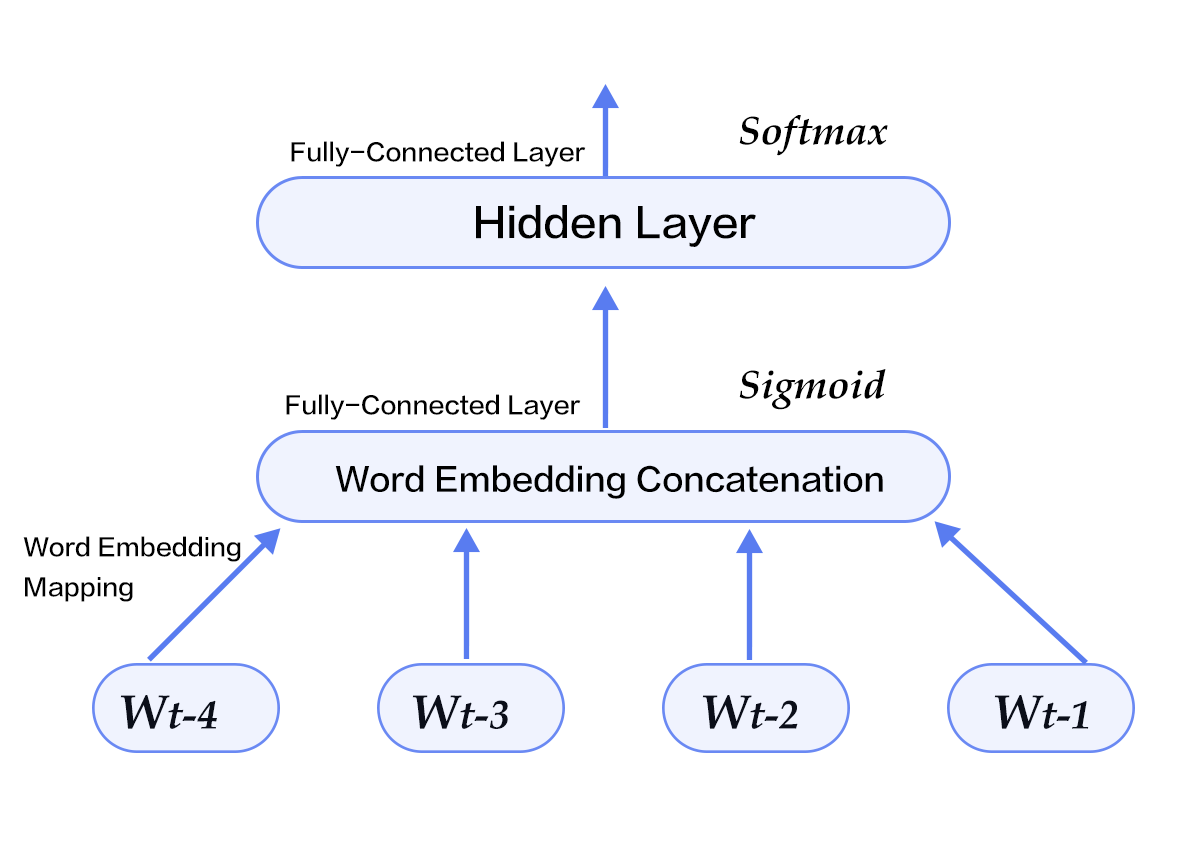

In [13]:
# save word dict and embedding table
import numpy
embeddings = parameters.get("_proj").reshape(len(word_dict), embsize)
save_dict_and_embedding(word_dict, embeddings)


In [14]:
# model application

# viewing word vector
embeddings = parameters.get("_proj").reshape(len(word_dict), embsize)

print embeddings[word_dict['apple']]


[ 0.0604338  -0.04156664 -0.02004204  0.00368996  0.08080749 -0.03177197
 -0.04515389  0.04546762 -0.07577305 -0.04330007 -0.0020747  -0.01055873
 -0.01276661 -0.03194548 -0.09011611 -0.03236387  0.06218651  0.06907444
  0.00834014  0.00375184 -0.03017448 -0.01123168 -0.023821   -0.08554357
  0.02328063  0.06905942  0.01495184 -0.00731522 -0.01183083 -0.0011765
  0.07971787 -0.05674021]


In [15]:
# modfiying word vector
# 
def modify_embedding(emb):
    # Add your modification here.
    pass

modify_embedding(embeddings)
parameters.set("_proj", embeddings)

In [16]:
# calculating cosine similarity is one way of quantifying the similarity betwwen two vectors.
from scipy import spatial

emb_1 = embeddings[word_dict['world']]
emb_2 = embeddings[word_dict['would']]

print spatial.distance.cosine(emb_1, emb_2)

1.2164951115846634


## Summary
1. the relationship between language model and word embeddings, and how to train NNs to learn word embeddings.
2. Cosine similarity of their word embeddings.